# Weather prediction in Neuchâtel
### Capstone Project by Régis STRAUBHAAR

### A. Context

#### **A.1. Issues addressed**

In this part, I will answer the questions: 

- What is the wider context of your problem and what story you would like to tell with the data?

*What is the weather like?* is perhaps one of the most common questions.  
*What will the weather be like?* is maybe one of the questions with the most expected answer.  
Weather is part of people's daily lives. Meteorological measurements are recorded in many places, at different time-scales to indicate what is the weather like.

Weather forecasts relies on mathematical models based on the laws of physics. The Machine Learning approch proposed here is not as reliable as these complex numerical methods to predict weather as a whole. It is not intended to be an alternative. But too great is the temptation to apply these new techniques to these data.

I am neither a weather specialist nor a meteorologist, just an inhabitant of Switzerland with basic ideas about the use of these features. You should have at least as much ideas about how these weather data can be used. For this project, I am interested in meteorological data on a daily basis in Switzerland. The website of [MeteoSwiss](https://www.meteoswiss.admin.ch/home/measurement-values.html) gives 975 measurement values like temperature, precipitation, wind, sunshine and so on for 2.749 weather stations. Some parameters are available in various scale (e.g. month total, daily total, percentage, ...), some are not available for each station (e.g. snow) and sometimes technical issues imply missing values.  
Globally, it gives a big picture of the weather in Switzerland. But what about the weather in a particular place ? Can we guess the weather in a place not hosting a station? Can we predict weather for the next day? Or recover missing data due to technical issues? What are the most "influent" parameters ? Can nearby stations be used for forecasts ?

- What problem would you like to address?

To avoid getting lost, I focus on a specific location and measurement. Concretely speaking, the main issue of this project is to predict the daily temperature in Neuchâtel for year 2020 based on the daily measurments of the 24 main stations of the Swiss Meteorogical Network (SwissMetNet) performed during the years 2014 to 2020 for the temperature and others indicators (year 2014 will only be used for computing extra lag variables). Of course the whole series of temperature for Neuchatel in 2020 will be removed and to predict the temperature in Neuchatel on D-day, all past data will be available as well as the other measurements on D-day. This context correspond to the case of missing values due to a technical problem for the temperature sensor in Neuchatel. Temperature forecasts without using temperature measurements on D-day are more tricky but will also be considered. It will be interesting to see how far away from the real values they are.  

A more distant alternative is to predict temperature in a station where this measure was never recorded. To address this question, the whole serie of temperature in Neuchatel will be erased  for forecasting.

To sum up, we will address these three different versions of the main issue : 
- The "technical problem";
- The "prediction problem";
- The "new station problem".

#### **A.2. About this notebook**

This notebook presents relatively raw results. Some are quite big but they are complete. They can be shrinked for easier reading. In addition, some warnings appear. This is to avoid concealing possible problems. Although the presentation could have been more concise, some passages have been kept to show complete reasoning (e.g. dropping a variable with too many missing values).
Lots of commentaries are written in the code cells, but they are not essential for the comprehension of the results. Explanations are provided throughout the notebook.

### B. The data

#### **B.1. Overview**

##### **B.1.1. Source and context of the data set**

The data comes from MeteoSwiss. They can be visualized on their [website](https://www.meteoswiss.admin.ch/home/measurement-values.html). A practical access to the database is done throught IDAweb, the data portal for education and research of MeteoSwiss. To use it, a registration signed by the user and his educational institution must be accepted by MeteoSwiss. You can obtain the form on https://gate.meteoswiss.ch/idaweb/login.do?language=en. Once this administrative step achieved, the data are easily collected through IDAweb, even if there exist some limitations to maximum 400 series (namely a continuous time serie of observations of one measurment in one station) and 2,000,000 observations by request.

More information is available on https://gate.meteoswiss.ch/idaweb/more.do.
Note that the (limited) access of the data with a scrapper is provided according to the [Robots exclusion standard](https://www.meteosuisse.admin.ch/robots.txt) of MeteoSwiss.

##### **B.1.2. Information captured by the features**

From the whole data base available through the IDAweb portal, I extracted the 7 following features:
    - gre000d0: Global radiation, daily mean in watt/square meter;
    - p06stads: Pressure at station level (QFE), current value at 6 UTC in hectopascal;
    - tre200d0: Air temperature 2 m above ground, daily mean in degree Celsius;
    - rre150d0: Precipitation homogeneous daily total (conventional) 0540 - 0540 following day in mm;
    - ure200d0: Relative air humidity 2 m above ground, daily mean in per cent;
    - sre000d0: Sunshine duration daily total in min;
    - fkl010d0: Wind speed scalar, daily mean in m/s;
    
 These features are extracted between 01.01.2014 and 31.12.2020 for the 24 main stations of the Swiss Meteorogical Network (SwissMetNet). The data is stored in the `order_92009_data.txt` file. It is a 2 Mo file, so it can be stored as is.
 Here is a small sample of the row entries, features, values.

In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
df = pd.read_csv(os.path.join('.', 'meteosuisse', 'commandes', 'order_92009_data.txt'), 
                 sep=';',
                 na_values='-'
                )
df.head()

stn      time gre000d0 p06stads tre200d0 rre150d0 ure200d0 sre000d0  \
0  ABO  20140101       66    865.2      0.5      0.0     65.0      286   
1  ABO  20140102       27    857.6      1.0      3.7     71.5       59   
2  ABO  20140103       44    862.2      3.1      2.2     61.6       54   
3  ABO  20140104       19    862.0      1.8      7.1     91.7        0   
4  ABO  20140105       67    858.1     -1.1      0.0     80.2      262   

  fkl010d0  
0      1.2  
1      2.2  
2      2.1  
3      1.1  
4      1.6

The 24 main stations of the SwissMetNet are :

In [3]:
index_stations = df.stn.unique()
index_stations = index_stations[index_stations != 'stn'] # irrelevant values are present in the orinigal data
whole_name = ['Adelboden', 'Altdorf', 'Basel / Binningen', 'Bern / Zollikofen', 'Buchs / Aarau', 'Chur', 'Davos', 'Disentis',
       'Engelberg', 'Genève / Cointrin', 'Interlaken', 'La Chaux-de-Fonds', 'Locarno / Monti', 'Lugano', 'Luzern', 'Neuchatel', 'Piotta',
       'Pully', 'Samedan', 'Schaffhausen', 'Sion', 'St. Gallen', 'Zermatt', 'Zürich / Fluntern']

stations = pd.DataFrame(data = {'stn': index_stations, 'station': whole_name})
stations

stn            station
0   ABO          Adelboden
1   ALT            Altdorf
2   BAS  Basel / Binningen
3   BER  Bern / Zollikofen
4   BUS      Buchs / Aarau
5   CHU               Chur
6   DAV              Davos
7   DIS           Disentis
8   ENG          Engelberg
9   GVE  Genève / Cointrin
10  INT         Interlaken
11  CDF  La Chaux-de-Fonds
12  OTL    Locarno / Monti
13  LUG             Lugano
14  LUZ             Luzern
15  NEU          Neuchatel
16  PIO             Piotta
17  PUY              Pully
18  SAM            Samedan
19  SHA       Schaffhausen
20  SIO               Sion
21  STG         St. Gallen
22  ZER            Zermatt
23  SMA  Zürich / Fluntern

Another data file (namely `stations_data.csv`) coming alongside the downloaded file contains geographical informations about the stations concerned. Let's import it, manipulate it for practical purpose and draw the stations on a map (namely `switzerland.geojson`) using geopandas.

In [4]:
# Import station infos
df_stn = pd.read_csv(os.path.join('.', 'meteosuisse', 'commandes', 'stations_data.csv'), 
                 sep=';',
                 na_values='-'
                )
df_stn.head()

Abbr  Measurement height [m. a. sea level] More information [m. a. ground]  \
0  TAE                                   540                          2.00 m   
1  COM                                   577                          2.00 m   
2  ABO                                  1324                          2.00 m   
3  AIG                                   383                          2.00 m   
4  ALT                                   440                          2.00 m   

    Coordinates (CH)    Latitude/Longitude Canton  
0  2710515 / 1259820  47.479853 / 8.904878     TG  
1  2714987 / 1146446  46.459472 / 8.935511     TI  
2  2609371 / 1148943  46.491733 / 7.560692     BE  
3  2560400 / 1130713  46.326642 / 6.924414     VD  
4  2690174 / 1193561  46.887042 / 8.621806     UR

In [5]:
# rename station name into 'stn' and altitude
df_stn.rename(columns={'Abbr': 'stn', 'Measurement height [m. a. sea level]': 'altitude', 'Canton': 'canton'}, inplace=True)

# get latitude and longitude
df_stn['latitude'] = df_stn['Latitude/Longitude'].str.split(' ').str[0]
df_stn['longitude'] = df_stn['Latitude/Longitude'].str.split(' ').str[2]
df_stn['latitude'] = df_stn['latitude'].astype(np.float)
df_stn['longitude'] = df_stn['longitude'].astype(np.float)

# get coordinates
df_stn['x_coord'] = df_stn['Coordinates (CH)'].str.split(' ').str[0]
df_stn['y_coord'] = df_stn['Coordinates (CH)'].str.split(' ').str[2]
df_stn['x_coord'] = df_stn['x_coord'].astype(np.float)
df_stn['y_coord'] = df_stn['y_coord'].astype(np.float)

# add the presence of a lake by hand
df_stn['lake'] = 0
df_stn.loc[df_stn['stn'].isin(['ALT', 'GVE', 'INT', 'OTL', 'LUG', 'LUZ', 'NEU', 'PUY']), 'lake'] = 1

# formatting
var_geo = ['altitude', 'latitude', 'longitude', 'lake', 'x_coord', 'y_coord']
df_stn_ok = df_stn[['stn', 'canton'] + var_geo]
df_stn_ok.head()

stn canton  altitude   latitude  longitude  lake    x_coord    y_coord
0  TAE     TG       540  47.479853   8.904878     0  2710515.0  1259820.0
1  COM     TI       577  46.459472   8.935511     0  2714987.0  1146446.0
2  ABO     BE      1324  46.491733   7.560692     0  2609371.0  1148943.0
3  AIG     VD       383  46.326642   6.924414     0  2560400.0  1130713.0
4  ALT     UR       440  46.887042   8.621806     1  2690174.0  1193561.0

In [6]:
# Merge stations characteristics with data 
df_stn_ok = pd.merge(stations, df_stn_ok, on=['stn'])
df_stn_ok

stn            station canton  altitude   latitude  longitude  lake  \
0   ABO          Adelboden     BE      1324  46.491733   7.560692     0   
1   ALT            Altdorf     UR       440  46.887042   8.621806     1   
2   BAS  Basel / Binningen     BL       318  47.541067   7.583556     0   
3   BER  Bern / Zollikofen     BE       555  46.990742   7.463997     0   
4   BUS      Buchs / Aarau     AG       389  47.384339   8.079461     0   
5   CHU               Chur     GR       558  46.870397   9.530583     0   
6   DAV              Davos     GR      1596  46.812956   9.843492     0   
7   DIS           Disentis     GR      1199  46.706525   8.853467     0   
8   ENG          Engelberg     OW      1037  46.821614   8.410450     0   
9   GVE  Genève / Cointrin     GE       413  46.247453   6.127722     1   
10  INT         Interlaken     BE       579  46.672231   7.870139     1   
11  CDF  La Chaux-de-Fonds     NE      1019  47.082944   6.792247     0   
12  OTL    Locarno / Monti     TI       369  46.172217   8.787486     1   
13  LUG             Lugano     TI       275  46.003833   8.960117     1   
14  LUZ             Luzern     LU       456  47.036417   8.300961     1   
15  NEU          Neuchatel     NE       486  46.999994   6.953106     1   
16  PIO             Piotta     TI       991  46.514775   8.688111     0   
17  PUY              Pully     VD       457  46.512278   6.667461     1   
18  SAM            Samedan     GR      1711  46.526244   9.879408     0   
19  SHA       Schaffhausen     SH       441  47.689803   8.620064     0   
20  SIO               Sion     VS       481  46.217492   7.315283     0   
21  STG         St. Gallen     SG       778  47.425456   9.398461     0   
22  ZER            Zermatt     VS      1641  46.029261   7.752397     0   
23  SMA  Zürich / Fluntern     ZH       558  47.377883   8.565733     0   

      x_coord    y_coord  
0   2609371.0  1148943.0  
1   2690174.0  1193561.0  
2   2610911.0  1265604.0  
3   2601929.0  1204409.0  
4   2648390.0  1248365.0  
5   2759472.0  1193156.0  
6   2783514.0  1187457.0  
7   2708190.0  1173788.0  
8   2674157.0  1186066.0  
9   2498903.0  1122624.0  
10  2633019.0  1169091.0  
11  2550914.0  1214862.0  
12  2704166.0  1114311.0  
13  2717859.0  1095840.0  
14  2665540.0  1209847.0  
15  2563072.0  1205552.0  
16  2695886.0  1152260.0  
17  2540815.0  1151510.0  
18  2787246.0  1155684.0  
19  2688698.0  1282799.0  
20  2590481.0  1118457.0  
21  2747861.0  1254585.0  
22  2624295.0  1097573.0  
23  2685117.0  1248061.0

In [7]:
import geopandas as gpd # to get polygonal curve (the map of Switzerland)
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In C:\Users\muriel\.conda\envs\exts-ml\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\muriel\.conda\envs\exts-ml\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\muriel\.conda\envs\exts-ml\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


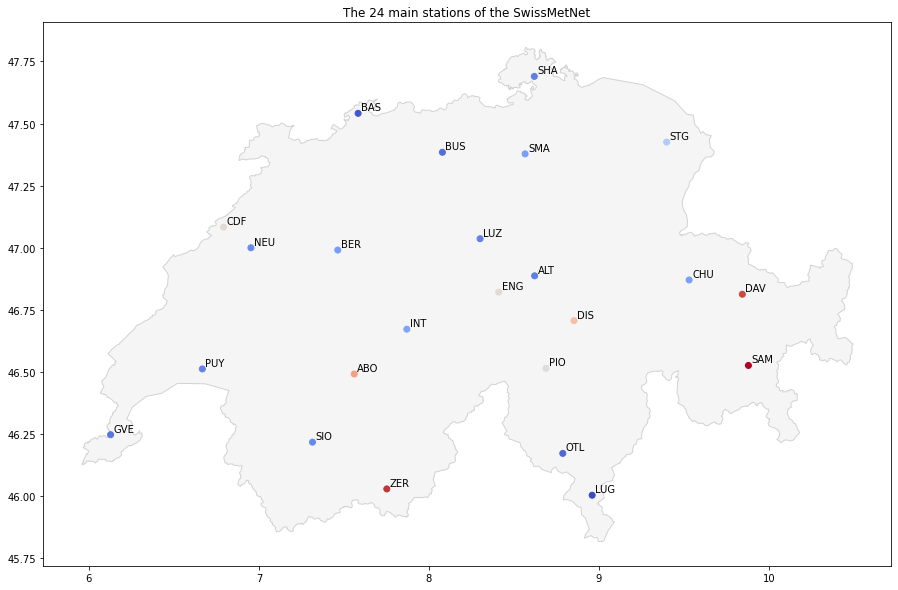

In [8]:
# Get the map of Switzerland
swiss_map = gpd.read_file(os.path.join('.', 'swiss-maps', 'switzerland.geojson')) # map from https://github.com/ZHB/switzerland-geojson/tree/master/country
# Plot the map
ax = swiss_map.plot(color='whitesmoke', edgecolor='lightgrey', figsize=(20, 10)) # Swiss border map
plt.scatter(df_stn_ok.longitude, df_stn_ok.latitude, c=df_stn_ok.altitude, cmap='coolwarm') # stations location
for x, y, label in zip(df_stn_ok.longitude, df_stn_ok.latitude, df_stn_ok.stn):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points") # stations name

plt.title('The 24 main stations of the SwissMetNet')
plt.show()

Later on the nearest geographical neighbour(s) of each station will be useful. So let's find the nearest three and compute their distance (the longitude/latitude is not relevant, the coordinates are more accurate).

In [9]:
geo_coord = df_stn_ok[['x_coord', 'y_coord']].values
nb_stn = len(geo_coord)

number_of_nn = 3 # number of recorded nearest neighbours
nn = []
nn_dist = []
for s in np.arange(nb_stn):
    s_x = geo_coord[s, 0]
    s_y = geo_coord[s, 1]
    dist_n = []
    for n in np.arange(nb_stn):
        dist_n.append((geo_coord[n, 0]-s_x)**2 + (geo_coord[n, 1]-s_y)**2) # compute the distance between s and n

    dist_n[s] = 10**12 # set an arbitrary high value instead of 0
    nn.append(list(np.argsort(dist_n)[:number_of_nn])) # get the index of the nns
    nn_dist.append(list(np.sort(dist_n)[:number_of_nn])) # get the distance of the nns

for i in np.arange(3):
    ind = [el[i] for el in nn] # indices of the i-th nns
    neigh_i = df_stn_ok.loc[ind, 'stn'].values # names of the i-th nns
    dist_i = [el[i] for el in nn_dist] # distances of the i-th nns
    df_stn_ok['neighbour_'+str(i)] = neigh_i
    df_stn_ok['neighbour_dist_'+str(i)] = dist_i

df_stn_ok

stn            station canton  altitude   latitude  longitude  lake  \
0   ABO          Adelboden     BE      1324  46.491733   7.560692     0   
1   ALT            Altdorf     UR       440  46.887042   8.621806     1   
2   BAS  Basel / Binningen     BL       318  47.541067   7.583556     0   
3   BER  Bern / Zollikofen     BE       555  46.990742   7.463997     0   
4   BUS      Buchs / Aarau     AG       389  47.384339   8.079461     0   
5   CHU               Chur     GR       558  46.870397   9.530583     0   
6   DAV              Davos     GR      1596  46.812956   9.843492     0   
7   DIS           Disentis     GR      1199  46.706525   8.853467     0   
8   ENG          Engelberg     OW      1037  46.821614   8.410450     0   
9   GVE  Genève / Cointrin     GE       413  46.247453   6.127722     1   
10  INT         Interlaken     BE       579  46.672231   7.870139     1   
11  CDF  La Chaux-de-Fonds     NE      1019  47.082944   6.792247     0   
12  OTL    Locarno / Monti     TI       369  46.172217   8.787486     1   
13  LUG             Lugano     TI       275  46.003833   8.960117     1   
14  LUZ             Luzern     LU       456  47.036417   8.300961     1   
15  NEU          Neuchatel     NE       486  46.999994   6.953106     1   
16  PIO             Piotta     TI       991  46.514775   8.688111     0   
17  PUY              Pully     VD       457  46.512278   6.667461     1   
18  SAM            Samedan     GR      1711  46.526244   9.879408     0   
19  SHA       Schaffhausen     SH       441  47.689803   8.620064     0   
20  SIO               Sion     VS       481  46.217492   7.315283     0   
21  STG         St. Gallen     SG       778  47.425456   9.398461     0   
22  ZER            Zermatt     VS      1641  46.029261   7.752397     0   
23  SMA  Zürich / Fluntern     ZH       558  47.377883   8.565733     0   

      x_coord    y_coord neighbour_0  neighbour_dist_0 neighbour_1  \
0   2609371.0  1148943.0         INT      9.651698e+08         SIO   
1   2690174.0  1193561.0         ENG      3.127193e+08         DIS   
2   2610911.0  1265604.0         BUS      1.701859e+09         BER   
3   2601929.0  1204409.0         NEU      1.511173e+09         INT   
4   2648390.0  1248365.0         SMA      1.348965e+09         BAS   
5   2759472.0  1193156.0         DAV      6.104964e+08         SAM   
6   2783514.0  1187457.0         CHU      6.104964e+08         SAM   
7   2708190.0  1173788.0         PIO      6.148432e+08         ALT   
8   2674157.0  1186066.0         ALT      3.127193e+08         LUZ   
9   2498903.0  1122624.0         PUY      2.591017e+09         SIO   
10  2633019.0  1169091.0         ABO      9.651698e+08         ENG   
11  2550914.0  1214862.0         NEU      2.344931e+08         BER   
12  2704166.0  1114311.0         LUG      5.286761e+08         PIO   
13  2717859.0  1095840.0         OTL      5.286761e+08         PIO   
14  2665540.0  1209847.0         ENG      6.397886e+08         ALT   
15  2563072.0  1205552.0         CDF      2.344931e+08         BER   
16  2695886.0  1152260.0         DIS      6.148432e+08         OTL   
17  2540815.0  1151510.0         GVE      2.591017e+09         NEU   
18  2787246.0  1155684.0         DAV      1.023451e+09         CHU   
19  2688698.0  1282799.0         SMA      1.219552e+09         BUS   
20  2590481.0  1118457.0         ABO      1.286228e+09         ZER   
21  2747861.0  1254585.0         CHU      3.908337e+09         SMA   
22  2624295.0  1097573.0         SIO      1.579528e+09         ABO   
23  2685117.0  1248061.0         SHA      1.219552e+09         BUS   

    neighbour_dist_1 neighbour_2  neighbour_dist_2  
0       1.286228e+09         ZER      2.861603e+09  
1       7.155478e+08         LUZ      8.720678e+08  
2       3.825504e+09         SMA      5.814287e+09  
3       2.213949e+09         CDF      2.711795e+09  
4       1.701859e+09         LUZ      1.777759e+09  
5       2.175546e+09         DIS      3.004963e+09  
6     

##### **B.1.3. Number and granularity of the features**

The main file contains 7 features corresponding to daily measurements, togheter with the station name and the day of the measurement, so 9 variables in total.

There are 7 years of daily measurments over 24 stations, so (7 x 365+2) x 24 = 61,368 samples.

Extra variables for the modelization will be created further.

##### **B.1.4. Quality of the data**

Data is of good quality. Some measurement are sometimes missing for a few dates and stations and some records are beginning later for some stations.

### C. Data processing and cleaning

#### **C.1. Data cleaning and data manipulation**

For convenience, we rename the variables

In [10]:
df.rename(columns={"gre000d0": "radiation", 
                   "p06stads": "pressure", 
                   "tre200d0": "temperature", 
                   "rre150d0": "precipitation", 
                   "ure200d0": "humidity", 
                   "sre000d0": "sunshine", 
                   "fkl010d0": "wind_speed"}, inplace=True)
df.head()

stn      time radiation pressure temperature precipitation humidity  \
0  ABO  20140101        66    865.2         0.5           0.0     65.0   
1  ABO  20140102        27    857.6         1.0           3.7     71.5   
2  ABO  20140103        44    862.2         3.1           2.2     61.6   
3  ABO  20140104        19    862.0         1.8           7.1     91.7   
4  ABO  20140105        67    858.1        -1.1           0.0     80.2   

  sunshine wind_speed  
0      286        1.2  
1       59        2.2  
2       54        2.1  
3        0        1.1  
4      262        1.6

In [11]:
df.dtypes

stn              object
time             object
radiation        object
pressure         object
temperature      object
precipitation    object
humidity         object
sunshine         object
wind_speed       object
dtype: object

All the variables are of dtype `object` and we want to convert them into `float` (except for `stn`). Note that the name of the variables (like a header) is repeted for each of the 24 stations (23 times plus the name of the DataFrame).

In [12]:
df.loc[df.temperature.str.contains('[A-Za-z]')==True] # check for entry in 'temperature' with letter(s)

stn  time radiation  pressure temperature precipitation  humidity  \
2557   stn  time  gre000d0  p06stads    tre200d0      rre150d0  ure200d0   
5115   stn  time  gre000d0  p06stads    tre200d0      rre150d0  ure200d0   
7673   stn  time  gre000d0  p06stads    tre200d0      rre150d0  ure200d0   
10231  stn  time  gre000d0  p06stads    tre200d0      rre150d0  ure200d0   
12789  stn  time  gre000d0  p06stads    tre200d0      rre150d0  ure200d0   
15347  stn  time  gre000d0  p06stads    tre200d0      rre150d0  ure200d0   
17905  stn  time  gre000d0  p06stads    tre200d0      rre150d0  ure200d0   
20463  stn  time  gre000d0  p06stads    tre200d0      rre150d0  ure200d0   
23021  stn  time  gre000d0  p06stads    tre200d0      rre150d0  ure200d0   
25579  stn  time  gre000d0  p06stads    tre200d0      rre150d0  ure200d0   
28137  stn  time  gre000d0  p06stads    tre200d0      rre150d0  ure200d0   
30695  stn  time  gre000d0  p06stads    tre200d0      rre150d0  ure200d0   
33253  stn  time  gre000d0  p06stads    tre200d0      rre150d0  ure200d0   
35811  stn  time  gre000d0  p06stads    tre200d0      rre150d0  ure200d0   
38369  stn  time  gre000d0  p06stads    tre200d0      rre150d0  ure200d0   
40927  stn  time  gre000d0  p06stads    tre200d0      rre150d0  ure200d0   
43485  stn  time  gre000d0  p06stads    tre200d0      rre150d0  ure200d0   
46043  stn  time  gre000d0  p06stads    tre200d0      rre150d0  ure200d0   
48601  stn  time  gre000d0  p06stads    tre200d0      rre150d0  ure200d0   
51159  stn  time  gre000d0  p06stads    tre200d0      rre150d0  ure200d0   
53717  stn  time  gre000d0  p06stads    tre200d0      rre150d0  ure200d0   
56275  stn  time  gre000d0  p06stads    tre200d0      rre150d0  ure200d0   
58833  stn  time  gre000d0  p06stads    tre200d0      rre150d0  ure200d0   

       sunshine wind_speed  
2557   sre000d0   fkl010d0  
5115   sre000d0   fkl010d0  
7673   sre000d0   fkl010d0  
10231  sre000d0   fkl010d0  
12789  sre000d0   fkl010d0  
15347  sre000d0   fkl010d0  
17905  fkl010d0   sre000d0  
20463  sre000d0   fkl010d0  
23021  sre000d0   fkl010d0  
25579  sre000d0   fkl010d0  
28137  sre000d0   fkl010d0  
30695  sre000d0   fkl010d0  
33253  sre000d0   fkl010d0  
35811  sre000d0   fkl010d0  
38369  sre000d0   fkl010d0  
40927  sre000d0   fkl010d0  
43485  sre000d0   fkl010d0  
46043  sre000d0   fkl010d0  
48601  sre000d0   fkl010d0  
51159  sre000d0   fkl010d0  
53717  sre000d0   fkl010d0  
56275  sre000d0   fkl010d0  
58833  sre000d0   fkl010d0

In [13]:
print(df.loc[df.temperature.str.contains('[A-Za-z]')==True].shape[0])

23


We drop it.

In [14]:
rows_to_clead = df.loc[df.temperature.str.contains('[A-Za-z]')==True].index
df.drop(rows_to_clead, axis=0, inplace=True)
df.loc[df.temperature.str.contains('[A-Za-z]')==True]

Empty DataFrame
Columns: [stn, time, radiation, pressure, temperature, precipitation, humidity, sunshine, wind_speed]
Index: []

Check for other non numeric entries

In [15]:
for c in df.columns:
    print('Number of non numeric entries in variable', c, ':', df.loc[df[c].str.contains('[A-Za-z]')==True].shape[0])

Number of non numeric entries in variable stn : 61368
Number of non numeric entries in variable time : 0
Number of non numeric entries in variable radiation : 0
Number of non numeric entries in variable pressure : 0
Number of non numeric entries in variable temperature : 0
Number of non numeric entries in variable precipitation : 0
Number of non numeric entries in variable humidity : 0
Number of non numeric entries in variable sunshine : 0
Number of non numeric entries in variable wind_speed : 0


Non-numeric entries cleaned. Converting is now possible.

In [16]:
# Converting to float is possible since non-numeric entries cleaned.
df.radiation = df.radiation.astype(np.float64, copy=False);
df.pressure = df.pressure.astype(np.float64, copy=False);
df.temperature = df.temperature.astype(np.float64, copy=False);
df.precipitation = df.precipitation.astype(np.float64, copy=False);
df.humidity = df.humidity.astype(np.float64, copy=False);
df.sunshine = df.sunshine.astype(np.float64, copy=False);
df.wind_speed = df.wind_speed.astype(np.float64, copy=False);

In [17]:
# Converting type of "time" variable into datetime 
time = pd.to_datetime(df.time)
df.time = time

Let's have a look to missing values.
First numerically ...

In [18]:
df.isnull().sum(axis=0)

stn                  0
time                 0
radiation         4256
pressure            32
temperature          0
precipitation       14
humidity             0
sunshine            68
wind_speed       14278
dtype: int64

In [19]:
for c in df.columns:
    pct_miss = df[c].isnull().sum(axis=0) / df.shape[0]
    print('Percentage of missing values in variable "{}" : {:.2%}'.format(c, pct_miss))

Percentage of missing values in variable "stn" : 0.00%
Percentage of missing values in variable "time" : 0.00%
Percentage of missing values in variable "radiation" : 6.94%
Percentage of missing values in variable "pressure" : 0.05%
Percentage of missing values in variable "temperature" : 0.00%
Percentage of missing values in variable "precipitation" : 0.02%
Percentage of missing values in variable "humidity" : 0.00%
Percentage of missing values in variable "sunshine" : 0.11%
Percentage of missing values in variable "wind_speed" : 23.27%


... Then graphically over time (missing values are represented in red (value set to 1).

In [20]:
from matplotlib.colors import ListedColormap
import seaborn as sns

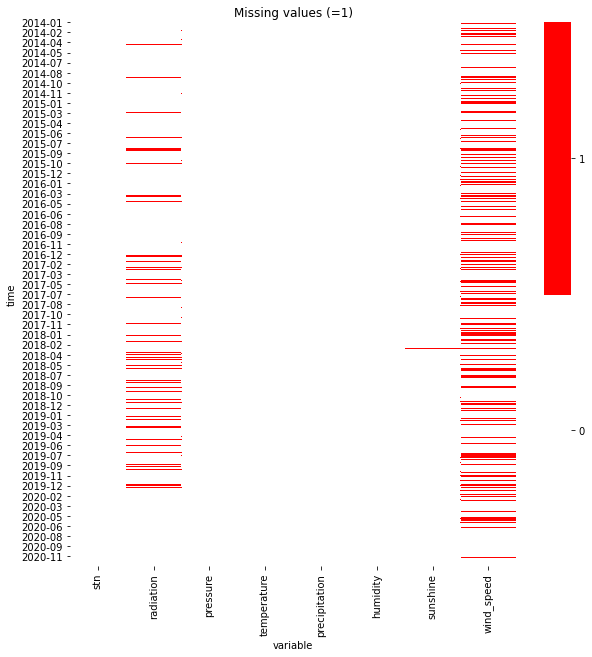

In [21]:
# Sort and format time
df_time_fmt = df.set_index('time').sort_values(by='time').copy()
df_time_fmt.index = pd.to_datetime(df_time_fmt.index, format = '%m/%d/%Y').strftime('%Y-%m')

# Plot the missing values
plt.figure(figsize=(10,10))
f = sns.heatmap(df_time_fmt.isnull(), cmap=ListedColormap(['white', 'red']))
colorbar = f.collections[0].colorbar
colorbar.set_ticks([.25, .75])
colorbar.set_ticklabels(['0', '1'])
f.set_xlabel('variable')
f.set_ylabel('time')
f.set_title('Missing values (=1)')

plt.show()

The variable `wind_speed` is missing for 23% observations *regularly* distributed over time. We decide to drop it.

In [22]:
df.drop('wind_speed', axis=1, inplace=True)

Let's investigate the other variables with missing observations, namely `radiation`, `pressure`, `precipitation` and `sunshine`. Let's first count the number of missing observations by station.

In [23]:
print('Total number of observations : {}.'.format(df.loc[df.stn=='ABO'].shape[0])) # Print the total number of rows.
var_miss = ['radiation', 'pressure', 'precipitation', 'sunshine']
var_miss_stn = ['stn'] + var_miss
df[var_miss_stn].groupby('stn', sort=False).count().rsub(df[var_miss_stn].groupby('stn', sort=False).size(), axis=0)

Total number of observations : 2557.


radiation  pressure  precipitation  sunshine
stn                                              
ABO          0         3              0         0
ALT          0         0              0         0
BAS          0         0              0         0
BER          0         0              0         0
BUS        818         0              0         0
CHU          0         2              0         0
DAV          0         0              0         0
DIS          0         2             14         0
ENG          0         0              0         0
GVE          0         1              0         0
INT       2283         5              0         0
CDF          0         0              0         0
OTL          0         0              0         0
LUG          0         0              0         0
LUZ          0         0              0         0
NEU          0         0              0         0
PIO       1140         0              0         0
PUY          0         1              0         0
SAM          0         0              0        11
SHA          0         1              0         0
SIO          0         0              0        12
STG         15         9              0        45
ZER          0         8              0         0
SMA          0         0              0         0

It seems relevent to remove the observations of stations `BUS`, `INT` and `PIO` since a large part of the 2,557 observations is missing for variable `radiation`. It is better to drop the data from these stations rather than the variable information since the records are complete for this variable in all the other stations except one.

In [24]:
stn_to_remove = ['BUS', 'INT', 'PIO']
df = df.loc[~df['stn'].isin(stn_to_remove)]
df.reset_index(inplace=True, drop=True)

In [25]:
df.loc[df['radiation'].isnull(), ['stn', 'time', 'radiation']]

stn       time  radiation
47580  STG 2018-04-04        NaN
47581  STG 2018-04-05        NaN
47582  STG 2018-04-06        NaN
47583  STG 2018-04-07        NaN
47584  STG 2018-04-08        NaN
47585  STG 2018-04-09        NaN
47586  STG 2018-04-10        NaN
47587  STG 2018-04-11        NaN
47588  STG 2018-04-12        NaN
47589  STG 2018-04-13        NaN
47590  STG 2018-04-14        NaN
47591  STG 2018-04-15        NaN
47592  STG 2018-04-16        NaN
47593  STG 2018-04-17        NaN
47594  STG 2018-04-18        NaN

The remaining missing values in variable 'radiation' concern only the station `STG` for some successive days. Let's fill these with the values of radiation of its geographically nearest neighbour. But first, let's remove stations `BUS`, `INT` and `PIO` from the DataFrame containing the stations informations, and update the nearest neighbours again.

In [26]:
df_stn_ok = df_stn_ok.loc[~df_stn_ok['stn'].isin(stn_to_remove + ['neighbour_0', 'neighbour_dist_0', 'neighbour_1', 'neighbour_dist_1', 'neighbour_2', 'neighbour_dist_2'])].copy()
df_stn_ok.reset_index(inplace=True, drop=True)

In [27]:
geo_coord = df_stn_ok[['x_coord', 'y_coord']].values
nb_stn = len(geo_coord)

number_of_nn = 3 # number of recorded nearest neighbours
nn = []
nn_dist = []
for s in np.arange(nb_stn):
    s_x = geo_coord[s, 0]
    s_y = geo_coord[s, 1]
    dist_n = []
    for n in np.arange(nb_stn):
        dist_n.append((geo_coord[n, 0]-s_x)**2 + (geo_coord[n, 1]-s_y)**2) # compute the distance between s and n

    dist_n[s] = 10**12 # set an arbitrary high value instead of 0
#     nn.append(np.argmin(dist_n)) # get the index of the nn
#     nn_dist.append(np.min(dist_n)) # get the distance of the nn
    nn.append(list(np.argsort(dist_n)[:number_of_nn])) # get the index of the nns
    nn_dist.append(list(np.sort(dist_n)[:number_of_nn])) # get the distance of the nns

for i in np.arange(3):
    ind = [el[i] for el in nn] # indices of the i-th nns
    neigh_i = df_stn_ok.loc[ind, 'stn'].values # names of the i-th nns
    dist_i = [el[i] for el in nn_dist] # distances of the i-th nns
    df_stn_ok['neighbour_'+str(i)] = neigh_i
    df_stn_ok['neighbour_dist_'+str(i)] = dist_i

df_stn_ok

stn            station canton  altitude   latitude  longitude  lake  \
0   ABO          Adelboden     BE      1324  46.491733   7.560692     0   
1   ALT            Altdorf     UR       440  46.887042   8.621806     1   
2   BAS  Basel / Binningen     BL       318  47.541067   7.583556     0   
3   BER  Bern / Zollikofen     BE       555  46.990742   7.463997     0   
4   CHU               Chur     GR       558  46.870397   9.530583     0   
5   DAV              Davos     GR      1596  46.812956   9.843492     0   
6   DIS           Disentis     GR      1199  46.706525   8.853467     0   
7   ENG          Engelberg     OW      1037  46.821614   8.410450     0   
8   GVE  Genève / Cointrin     GE       413  46.247453   6.127722     1   
9   CDF  La Chaux-de-Fonds     NE      1019  47.082944   6.792247     0   
10  OTL    Locarno / Monti     TI       369  46.172217   8.787486     1   
11  LUG             Lugano     TI       275  46.003833   8.960117     1   
12  LUZ             Luzern     LU       456  47.036417   8.300961     1   
13  NEU          Neuchatel     NE       486  46.999994   6.953106     1   
14  PUY              Pully     VD       457  46.512278   6.667461     1   
15  SAM            Samedan     GR      1711  46.526244   9.879408     0   
16  SHA       Schaffhausen     SH       441  47.689803   8.620064     0   
17  SIO               Sion     VS       481  46.217492   7.315283     0   
18  STG         St. Gallen     SG       778  47.425456   9.398461     0   
19  ZER            Zermatt     VS      1641  46.029261   7.752397     0   
20  SMA  Zürich / Fluntern     ZH       558  47.377883   8.565733     0   

      x_coord    y_coord neighbour_0  neighbour_dist_0 neighbour_1  \
0   2609371.0  1148943.0         SIO      1.286228e+09         ZER   
1   2690174.0  1193561.0         ENG      3.127193e+08         DIS   
2   2610911.0  1265604.0         BER      3.825504e+09         SMA   
3   2601929.0  1204409.0         NEU      1.511173e+09         CDF   
4   2759472.0  1193156.0         DAV      6.104964e+08         SAM   
5   2783514.0  1187457.0         CHU      6.104964e+08         SAM   
6   2708190.0  1173788.0         ALT      7.155478e+08         ENG   
7   2674157.0  1186066.0         ALT      3.127193e+08         LUZ   
8   2498903.0  1122624.0         PUY      2.591017e+09         SIO   
9   2550914.0  1214862.0         NEU      2.344931e+08         BER   
10  2704166.0  1114311.0         LUG      5.286761e+08         DIS   
11  2717859.0  1095840.0         OTL      5.286761e+08         DIS   
12  2665540.0  1209847.0         ENG      6.397886e+08         ALT   
13  2563072.0  1205552.0         CDF      2.344931e+08         BER   
14  2540815.0  1151510.0         GVE      2.591017e+09         NEU   
15  2787246.0  1155684.0         DAV      1.023451e+09         CHU   
16  2688698.0  1282799.0         SMA      1.219552e+09         STG   
17  2590481.0  1118457.0         ABO      1.286228e+09         ZER   
18  2747861.0  1254585.0         CHU      3.908337e+09         SMA   
19  2624295.0  1097573.0         SIO      1.579528e+09         ABO   
20  2685117.0  1248061.0         SHA      1.219552e+09         LUZ   

    neighbour_dist_1 neighbour_2  neighbour_dist_2  
0       2.861603e+09         BER      3.131861e+09  
1       7.155478e+08         LUZ      8.720678e+08  
2       5.814287e+09         NEU      5.894813e+09  
3       2.711795e+09         ABO      3.131861e+09  
4       2.175546e+09         DIS      3.004963e+09  
5       1.023451e+09         STG      5.777305e+09  
6       1.308994e+09         CHU      3.004963e+09  
7       6.397886e+08         DIS      1.308994e+09  
8       8.403894e+09         NEU      1.099471e+10  
9       2.711795e+09         PUY      4.115466e+09  
10      3.553706e+09         ENG      6.049320e+09  
11      6.169380e+09         SAM      8.395860e+09  
12      8.720678e+08         SMA      1.843569e+09  
13      1.511173e+09         PUY      3.415912e+09  
14      3.415912e

We can now fill the missing values for station `STG` with the values of radiation of its geographically nearest neighbour, namely Chur (`CHU`).

In [28]:
nn_STG = df_stn_ok.loc[df_stn_ok['stn']=='STG', 'neighbour_0'].iloc[0]
print("The nearest neighbour of 'STG' is '{}'.".format(nn_STG))

The nearest neighbour of 'STG' is 'CHU'.


In [29]:
time_to_fill_radiation = df.loc[df['radiation'].isnull(), 'time'] # Get the date of missing values
values_to_be_filled = df.loc[(df['stn']==nn_STG) & (df['time'].isin(time_to_fill_radiation)), 'radiation'].values.tolist() # Get the value to fill with
df.loc[df['radiation'].isnull(), 'radiation'] = values_to_be_filled # Fill the missing values with the previously computed values
df.loc[df['radiation'].isnull()] # no missing values remaining !

Empty DataFrame
Columns: [stn, time, radiation, pressure, temperature, precipitation, humidity, sunshine]
Index: []

Let's see where the variable `pressure` is missing.

In [30]:
df.loc[df['pressure'].isnull(), ['stn', 'time', 'pressure']]

stn       time  pressure
80     ABO 2014-03-22       NaN
81     ABO 2014-03-23       NaN
82     ABO 2014-03-24       NaN
10487  CHU 2014-09-17       NaN
10488  CHU 2014-09-18       NaN
15636  DIS 2014-10-22       NaN
15638  DIS 2014-10-24       NaN
22568  GVE 2019-10-14       NaN
36819  PUY 2016-10-18       NaN
42487  SHA 2018-04-25       NaN
46323  STG 2014-10-25       NaN
46324  STG 2014-10-26       NaN
46325  STG 2014-10-27       NaN
46326  STG 2014-10-28       NaN
46327  STG 2014-10-29       NaN
46328  STG 2014-10-30       NaN
46329  STG 2014-10-31       NaN
46330  STG 2014-11-01       NaN
46331  STG 2014-11-02       NaN
50055  ZER 2018-01-12       NaN
50056  ZER 2018-01-13       NaN
50057  ZER 2018-01-14       NaN
50058  ZER 2018-01-15       NaN
50059  ZER 2018-01-16       NaN
50595  ZER 2019-07-06       NaN
50596  ZER 2019-07-07       NaN
50597  ZER 2019-07-08       NaN

Fill the missing pressure measurement at D-day by the last non null value, let set it is at day D1, corrected by the mean over the other stations of the difference of pressure between D-day and D1. This way of imputing the pressure seems relevant since the measure at D-day highly depends on the pressure on the previous day.

In [31]:
# Define a function to fill a missing value with the previous non null + the mean of the difference in the other stations.
def fill_with_previous_notnull(var_name, df):
    # var_name: name of the variable to fill
    # df: dataframe to fill
    
    null_index = df.loc[df[var_name].isnull()].index
    for i in null_index: # Browse the index corresponding to missing values
        null_day = df.loc[i, 'time'] # Get the corresponding day
        k = i-1
        while k >= 0: # Go backwards to find a non-null value (namely the previous one)
#             if k not in null_index: # For not getting a filled value
            if ~np.isnan(df.loc[k, var_name]):
                not_null_day = df.loc[k, 'time'] # Get the day of the non-null value            
                df_tmp = df.loc[df['time']==null_day, var_name].reset_index(drop=True) - df.loc[df['time']==not_null_day, var_name].reset_index(drop=True) # compute the difference of var_name between null_day and non_null_day 
                df.loc[i, var_name] = df.loc[k, var_name] + df_tmp.mean(axis=0) # compute the mean of this difference over the other stations and add it to the value on non_null_day at the missing station
                print("Row {} corresponding to day {:%Y-%m-%d} for variable '{}' filled with {:.3f}".format(i, null_day, var_name, df.loc[i, var_name]))
                k=-1
            else:
                k -= 1

In [32]:
fill_with_previous_notnull('pressure', df)

Row 80 corresponding to day 2014-03-22 for variable 'pressure' filled with 859.490
Row 81 corresponding to day 2014-03-23 for variable 'pressure' filled with 855.480
Row 82 corresponding to day 2014-03-24 for variable 'pressure' filled with 859.875
Row 10487 corresponding to day 2014-09-17 for variable 'pressure' filled with 950.240
Row 10488 corresponding to day 2014-09-18 for variable 'pressure' filled with 949.665
Row 15636 corresponding to day 2014-10-22 for variable 'pressure' filled with 882.940
Row 15638 corresponding to day 2014-10-24 for variable 'pressure' filled with 882.595
Row 22568 corresponding to day 2019-10-14 for variable 'pressure' filled with 968.680
Row 36819 corresponding to day 2016-10-18 for variable 'pressure' filled with 968.960
Row 42487 corresponding to day 2018-04-25 for variable 'pressure' filled with 965.970
Row 46323 corresponding to day 2014-10-25 for variable 'pressure' filled with 930.635
Row 46324 corresponding to day 2014-10-26 for variable 'pressur

Let's see where the variable `precipitation` is missing.

In [33]:
df.loc[df['precipitation'].isnull(), ['stn', 'time', 'precipitation']]

stn       time  precipitation
16601  DIS 2017-06-13            NaN
16602  DIS 2017-06-14            NaN
16603  DIS 2017-06-15            NaN
16604  DIS 2017-06-16            NaN
16605  DIS 2017-06-17            NaN
16606  DIS 2017-06-18            NaN
16607  DIS 2017-06-19            NaN
16608  DIS 2017-06-20            NaN
16609  DIS 2017-06-21            NaN
16610  DIS 2017-06-22            NaN
16611  DIS 2017-06-23            NaN
16612  DIS 2017-06-24            NaN
16613  DIS 2017-06-25            NaN
16614  DIS 2017-06-26            NaN

It is only missing at station `DIS` (probably due to a technical problem) between '2017-06-13' and '2017-06-26'. We will not fill these missing values as before. Indeed, in contrast to pressure, precipitation does not seem as related to the previous day's measurement. Moreover, values are missing on a period of successive days, which makes the imputation tricky.

A way to fill these missing values is to get the geographically nearest neighbourg of `DIS` (Disentis) computed above, namely `ALT` (Altdorf), although they do not share other topographical characteristics (presence of a lake, altitude, ...).

In [34]:
nn_DIS = df_stn_ok.loc[df_stn_ok['stn']=='DIS', 'neighbour_0'].iloc[0]
print("The nearest neighbour of 'DIS' is '{}'.".format(nn_DIS))

The nearest neighbour of 'DIS' is 'ALT'.


In [35]:
time_to_fill_precipitation = df.loc[df['precipitation'].isnull(), 'time'] # Get the date of missing values
values_to_be_filled = df.loc[(df['stn']==nn_DIS) & (df['time'].isin(time_to_fill_precipitation)), 'precipitation'].values.tolist() # Get the value to fill with
df.loc[df['precipitation'].isnull(), 'precipitation'] = values_to_be_filled # Fill the missing values with the previously computed values
df.loc[df['precipitation'].isnull()] # no missing values remaining !

Empty DataFrame
Columns: [stn, time, radiation, pressure, temperature, precipitation, humidity, sunshine]
Index: []

Let's see where the variable `sunshine` is missing.

In [36]:
df.loc[df['sunshine'].isnull(), ['stn', 'time', 'sunshine']]

stn       time  sunshine
40276  SAM 2019-04-06       NaN
40277  SAM 2019-04-07       NaN
40278  SAM 2019-04-08       NaN
40279  SAM 2019-04-09       NaN
40280  SAM 2019-04-10       NaN
40281  SAM 2019-04-11       NaN
40282  SAM 2019-04-12       NaN
40283  SAM 2019-04-13       NaN
40284  SAM 2019-04-14       NaN
40285  SAM 2019-04-15       NaN
40286  SAM 2019-04-16       NaN
45599  SIO 2019-11-01       NaN
45600  SIO 2019-11-02       NaN
45601  SIO 2019-11-03       NaN
45602  SIO 2019-11-04       NaN
45603  SIO 2019-11-05       NaN
45604  SIO 2019-11-06       NaN
45605  SIO 2019-11-07       NaN
45606  SIO 2019-11-08       NaN
45607  SIO 2019-11-09       NaN
45608  SIO 2019-11-10       NaN
45609  SIO 2019-11-11       NaN
45610  SIO 2019-11-12       NaN
47545  STG 2018-02-28       NaN
47546  STG 2018-03-01       NaN
47547  STG 2018-03-02       NaN
47548  STG 2018-03-03       NaN
47549  STG 2018-03-04       NaN
47550  STG 2018-03-05       NaN
47551  STG 2018-03-06       NaN
...    ...        ...       ...
47560  STG 2018-03-15       NaN
47561  STG 2018-03-16       NaN
47562  STG 2018-03-17       NaN
47563  STG 2018-03-18       NaN
47564  STG 2018-03-19       NaN
47565  STG 2018-03-20       NaN
47566  STG 2018-03-21       NaN
47567  STG 2018-03-22       NaN
47568  STG 2018-03-23       NaN
47569  STG 2018-03-24       NaN
47570  STG 2018-03-25       NaN
47571  STG 2018-03-26       NaN
47572  STG 2018-03-27       NaN
47573  STG 2018-03-28       NaN
47574  STG 2018-03-29       NaN
47580  STG 2018-04-04       NaN
47581  STG 2018-04-05       NaN
47582  STG 2018-04-06       NaN
47583  STG 2018-04-07       NaN
47584  STG 2018-04-08       NaN
47585  STG 2018-04-09       NaN
47586  STG 2018-04-10       NaN
47587  STG 2018-04-11       NaN
47588  STG 2018-04-12       NaN
47589  STG 2018-04-13       NaN
47590  STG 2018-04-14       NaN
47591  STG 2018-04-15       NaN
47592  STG 2018-04-16       NaN
47593  STG 2018-04-17       NaN
47594  STG 2018-04-18       NaN

[68 rows x 3 columns]

As for the variable 'precipitation', the missing values concern a couple of stations for some successive days. Also, the nature of this variable (sunshine duration daily total) indicates that we can fill these with the geographically nearest neighbour:
- For `SAM` (Samedan) : `DAV` (Davos)
- For `SIO` (Sion) : `ZER` (Adelboden). The local topography is really different for these stations !
- For `STG` (Sankt-Gallen) : `CHU` (Chur).

In [37]:
nn_SAM = df_stn_ok.loc[df_stn_ok['stn']=='SAM', 'neighbour_0'].iloc[0]
print("The nearest neighbour of 'SAM' is '{}'.".format(nn_SAM))
nn_SIO = df_stn_ok.loc[df_stn_ok['stn']=='SIO', 'neighbour_0'].iloc[0]
print("The nearest neighbour of 'SIO' is '{}'.".format(nn_SIO))
nn_STG = df_stn_ok.loc[df_stn_ok['stn']=='STG', 'neighbour_0'].iloc[0]
print("The nearest neighbour of 'STG' is '{}'.".format(nn_STG))

The nearest neighbour of 'SAM' is 'DAV'.
The nearest neighbour of 'SIO' is 'ABO'.
The nearest neighbour of 'STG' is 'CHU'.


Note that local topography is really different in Sion and Adelboden !

In [38]:
stn_null_sunshine = ['SAM', 'SIO', 'STG'] # List of the station with missing values in 'sunshine'
dict_nn = {'SAM': nn_SAM, 'SIO': nn_SIO, 'STG': nn_STG} # dictionary giving the corresponding nn
for s in stn_null_sunshine:
    time_to_fill = df.loc[(df['sunshine'].isnull()) & (df['stn']==s), 'time'] # Get the date of missing values
    values_to_be_filled = df.loc[(df['stn']==dict_nn[s]) & (df['time'].isin(time_to_fill)), 'sunshine'].values.tolist() # Get the value to fill with
    df.loc[(df['sunshine'].isnull()) & (df['stn']==s), 'sunshine'] = values_to_be_filled # Fill the missing values with the previously computed values

In [39]:
df.isnull().sum(axis=0)

stn              0
time             0
radiation        0
pressure         0
temperature      0
precipitation    0
humidity         0
sunshine         0
dtype: int64

The way we proceed to deal with missing values keep the time series complete from 2014 to 2020. We can now compute basic statistcs.

In [40]:
df.drop(['stn', 'time'], axis=1).describe() # relevant since entries are of type numeric

radiation      pressure   temperature  precipitation      humidity  \
count  53697.000000  53697.000000  53697.000000   53697.000000  53697.000000   
mean     151.342794    929.884545      9.668967       2.991229     72.772820   
std       99.869865     50.442279      7.728248       7.501291     13.838383   
min        1.000000    790.000000    -20.400000       0.000000     14.900000   
25%       65.000000    892.700000      3.900000       0.000000     63.300000   
50%      134.000000    954.800000      9.600000       0.000000     74.100000   
75%      233.000000    967.600000     15.500000       2.300000     83.600000   
max      405.000000   1006.800000     29.600000     216.500000    100.000000   

           sunshine  
count  53697.000000  
mean     287.760491  
std      255.055040  
min        0.000000  
25%       20.000000  
50%      256.000000  
75%      494.000000  
max      922.000000

No outliers seem to be present and cleaned. A complementary graphical analysis will be performed later in part D.

Remark : another way to fill missing values is to consider kNN-imputers which use characteristics of k-Nearest Neighbors, see the [scikit learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html).

#### **C.2. Feature engineering**

New variables can be computed from the present variables: lagged values (value the days/year before), mean of recent past values, month/season, duration of the day, ratio rain/humidity, ... . Some characteristics of the stations can also be taken into account as the altitude, presence of lake, ... (source https://www.meteoswiss.admin.ch/home/measurement-values.html?param=messwerte-lufttemperatur-10min&table=true).

In [41]:
 # add variables year, month and day
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['day'] = df['time'].dt.day

# add variable season
df.loc[df['month'].isin([12, 1, 2]), 'season'] = 1 # meteorological winter
df.loc[df['month'].isin([3, 4, 5]), 'season'] = 2 # meteorological spring
df.loc[df['month'].isin([6, 7, 8]), 'season'] = 3 # meteorological summer
df.loc[df['month'].isin([9, 10, 11]), 'season'] = 4 # meteorological automn

# add variable quotient of precipitation by humidity
df['r_rain_humidity'] = df['precipitation'] / df['humidity'] # does not seem to be relevant later...

Remark : Other combinations of variables could have been computed, but none proved significantly. The ratio `r_rain_humidity` is kept here to indicate that adding combinations of variables has been considered in the feature engineering.

Compute lag temperatures for the last 7 days and for last year (temparature the same day, one year ago). Later on, year 2014 will only be used to compute lag, not for  training the models.

In [42]:
# add lag for the 7 last days

nb_daily_lag = 7

for i in np.arange(1, nb_daily_lag+1):
    lag = 't_'+np.str(i) # name of the lag
    df_lag = pd.DataFrame(columns=['stn', 'time']) # create empty DF to get the lag i
    for s in df['stn'].unique():
        lag_stn_time = df.loc[df.stn==s, 'time'] # get time for station s
        lag_stn_temp = df.loc[df.stn==s, 'temperature'].shift(periods=i) # get temperature lag i for station s
        lag_stn_temp.rename(lag, inplace=True) # rename lag in t_i
        lag_stn = pd.concat([lag_stn_time, lag_stn_temp], axis=1) # correspondance time - lag 
        lag_stn['stn'] = s # add the name
        df_lag = pd.concat([df_lag, lag_stn], sort=False) # concat data of station s to already computed stations. 'sort=False': To avoid a warning (index ok in our case)
        
    df = pd.merge(df, df_lag, on=['stn', 'time']) # merge the lag i temperature to already computed lag

df.head()

stn       time  radiation  pressure  temperature  precipitation  humidity  \
0  ABO 2014-01-01       66.0     865.2          0.5            0.0      65.0   
1  ABO 2014-01-02       27.0     857.6          1.0            3.7      71.5   
2  ABO 2014-01-03       44.0     862.2          3.1            2.2      61.6   
3  ABO 2014-01-04       19.0     862.0          1.8            7.1      91.7   
4  ABO 2014-01-05       67.0     858.1         -1.1            0.0      80.2   

   sunshine  year  month  day  season  r_rain_humidity  t_1  t_2  t_3  t_4  \
0     286.0  2014      1    1     1.0         0.000000  NaN  NaN  NaN  NaN   
1      59.0  2014      1    2     1.0         0.051748  0.5  NaN  NaN  NaN   
2      54.0  2014      1    3     1.0         0.035714  1.0  0.5  NaN  NaN   
3       0.0  2014      1    4     1.0         0.077426  3.1  1.0  0.5  NaN   
4     262.0  2014      1    5     1.0         0.000000  1.8  3.1  1.0  0.5   

   t_5  t_6  t_7  
0  NaN  NaN  NaN  
1  NaN  NaN  NaN  
2  NaN  NaN  NaN  
3  NaN  NaN  NaN  
4  NaN  NaN  NaN

In [43]:
# add lag for the last n years (shift is not used here to lag date-to-date even in leap year)

y_i = 2014
y_f = 2020
nb_yearly_lag = 1

for i in 1+np.arange(nb_yearly_lag):
    lag = 't_y'+np.str(i) # name of the lag
    df_lag_i = df.loc[df['time'].dt.year <= y_f-i, ['stn', 'time', 'temperature']].copy() # select year where the lag can be computed
    df_lag_i['time'] = df_lag_i['time'] + pd.DateOffset(years=i) # get temperature lag i for station s
    
    id_leap = df_lag_i.duplicated(subset=['stn', 'time']) # mark duplicates due to for leap year, 28-02 is duplicated (see e.g. 2017-02-28)
    df_lag_i = df_lag_i.loc[~id_leap].copy() # drop duplicates

    df_lag_i.rename(columns={'temperature': lag}, inplace=True) # rename lag in ty_i
    df = pd.merge(df, df_lag_i, on=['stn', 'time'], how='left') # merge the lag i temperature to already computed lag
    
df.head()

stn       time  radiation  pressure  temperature  precipitation  humidity  \
0  ABO 2014-01-01       66.0     865.2          0.5            0.0      65.0   
1  ABO 2014-01-02       27.0     857.6          1.0            3.7      71.5   
2  ABO 2014-01-03       44.0     862.2          3.1            2.2      61.6   
3  ABO 2014-01-04       19.0     862.0          1.8            7.1      91.7   
4  ABO 2014-01-05       67.0     858.1         -1.1            0.0      80.2   

   sunshine  year  month  ...  season  r_rain_humidity  t_1  t_2  t_3  t_4  \
0     286.0  2014      1  ...     1.0         0.000000  NaN  NaN  NaN  NaN   
1      59.0  2014      1  ...     1.0         0.051748  0.5  NaN  NaN  NaN   
2      54.0  2014      1  ...     1.0         0.035714  1.0  0.5  NaN  NaN   
3       0.0  2014      1  ...     1.0         0.077426  3.1  1.0  0.5  NaN   
4     262.0  2014      1  ...     1.0         0.000000  1.8  3.1  1.0  0.5   

   t_5  t_6  t_7  t_y1  
0  NaN  NaN  NaN   NaN  
1  NaN  NaN  NaN   NaN  
2  NaN  NaN  NaN   NaN  
3  NaN  NaN  NaN   NaN  
4  NaN  NaN  NaN   NaN  

[5 rows x 21 columns]

In [44]:
# Deal with t_y1 on day 02-29: impute the value on 02-28 one year ago
id_02_29 = df.loc[(df.month == 2) & (df.time.dt.day == 29)].index # id of 02-29
id_02_28_before_29 = id_02_29 - 1 # id of 02-28
t_y1_02_29 = df.loc[id_02_28_before_29, 't_y1'] # t_y1 on 02-29
df.loc[id_02_29, 't_y1'] = t_y1_02_29.array

In [45]:
# add mean over previous week
df['t_mean7'] = (df['t_1']+df['t_2']+df['t_3']+df['t_4']+df['t_5']+df['t_6']+df['t_7'])/7

In [46]:
# Merge stations characteristics with data 
df_ok = pd.merge(df, df_stn_ok, on=['stn'])
df_ok.head()

stn       time  radiation  pressure  temperature  precipitation  humidity  \
0  ABO 2014-01-01       66.0     865.2          0.5            0.0      65.0   
1  ABO 2014-01-02       27.0     857.6          1.0            3.7      71.5   
2  ABO 2014-01-03       44.0     862.2          3.1            2.2      61.6   
3  ABO 2014-01-04       19.0     862.0          1.8            7.1      91.7   
4  ABO 2014-01-05       67.0     858.1         -1.1            0.0      80.2   

   sunshine  year  month  ...  longitude  lake    x_coord    y_coord  \
0     286.0  2014      1  ...   7.560692     0  2609371.0  1148943.0   
1      59.0  2014      1  ...   7.560692     0  2609371.0  1148943.0   
2      54.0  2014      1  ...   7.560692     0  2609371.0  1148943.0   
3       0.0  2014      1  ...   7.560692     0  2609371.0  1148943.0   
4     262.0  2014      1  ...   7.560692     0  2609371.0  1148943.0   

   neighbour_0  neighbour_dist_0  neighbour_1  neighbour_dist_1  neighbour_2  \
0          SIO      1.286228e+09          ZER      2.861603e+09          BER   
1          SIO      1.286228e+09          ZER      2.861603e+09          BER   
2          SIO      1.286228e+09          ZER      2.861603e+09          BER   
3          SIO      1.286228e+09          ZER      2.861603e+09          BER   
4          SIO      1.286228e+09          ZER      2.861603e+09          BER   

   neighbour_dist_2  
0      3.131861e+09  
1      3.131861e+09  
2      3.131861e+09  
3      3.131861e+09  
4      3.131861e+09  

[5 rows x 36 columns]

Remark : the number of das for computing lags (7) is a somehow arbitrary. Of course it corresponds to a week, and it's about the length of the weather forecast. It means that considering earlier days is maybe not very informative. However, to set the number of lags more significantly, an autocorrelation plot could be use, see [the pandas documentation](https://pandas.pydata.org/docs/reference/api/pandas.plotting.autocorrelation_plot.html).

### D. Exploratory data analysis (EDA)

#### **D.1. Preliminary EDA**

##### **D.1.1 Descriptive statistics and seasonal adjustment**

Descriptive statistics can be performed as at the end of point C.1. also for the added variables (when relevant):

In [47]:
df_ok.drop(['stn', 'time', 'year', 'month', 'day', 'season', 't_1', 't_2', 't_3', 't_4', 't_5', 't_6', 't_7', 't_y1'], axis=1).describe() # relevant since entries are of type numeric

radiation      pressure   temperature  precipitation      humidity  \
count  53697.000000  53697.000000  53697.000000   53697.000000  53697.000000   
mean     151.342794    929.884545      9.668967       2.991229     72.772820   
std       99.869865     50.442279      7.728248       7.501291     13.838383   
min        1.000000    790.000000    -20.400000       0.000000     14.900000   
25%       65.000000    892.700000      3.900000       0.000000     63.300000   
50%      134.000000    954.800000      9.600000       0.000000     74.100000   
75%      233.000000    967.600000     15.500000       2.300000     83.600000   
max      405.000000   1006.800000     29.600000     216.500000    100.000000   

           sunshine  r_rain_humidity       t_mean7      altitude  \
count  53697.000000     53697.000000  53550.000000  53697.000000   
mean     287.760491         0.036625      9.694099    767.238095   
std      255.055040         0.089424      7.397862    457.852430   
min        0.000000         0.000000    -16.857143    275.000000   
25%       20.000000         0.000000      4.042857    441.000000   
50%      256.000000         0.000000      9.457143    555.000000   
75%      494.000000         0.029448     15.428571   1037.000000   
max      922.000000         2.599040     28.057143   1711.000000   

           latitude     longitude          lake       x_coord       y_coord  \
count  53697.000000  53697.000000  53697.000000  5.369700e+04  5.369700e+04   
mean      46.783017      8.189928      0.333333  2.657271e+06  1.182128e+06   
std        0.478776      1.049084      0.471409  8.018707e+04  5.321966e+04   
min       46.003833      6.127722      0.000000  2.498903e+06  1.095840e+06   
25%       46.491733      7.463997      0.000000  2.601929e+06  1.148943e+06   
50%       46.821614      8.410450      0.000000  2.674157e+06  1.187457e+06   
75%       47.036417      8.853467      1.000000  2.708190e+06  1.209847e+06   
max       47.689803      9.879408      1.000000  2.787246e+06  1.282799e+06   

       neighbour_dist_0  neighbour_dist_1  neighbour_dist_2  
count      5.369700e+04      5.369700e+04      5.369700e+04  
mean       1.274747e+09      2.886898e+09      4.497506e+09  
std        1.065763e+09      1.942488e+09      2.372218e+09  
min        2.344931e+08      6.397886e+08      8.720678e+08  
25%        5.286761e+08      1.511173e+09      3.004963e+09  
50%        1.023451e+09      2.711795e+09      3.559212e+09  
75%        1.511173e+09      3.553706e+09      5.894813e+09  
max        3.908337e+09      8.403894e+09      1.099471e+10

A quick big picture can be made through histograms.

C:\Users\muriel\.conda\envs\exts-ml\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\muriel\.conda\envs\exts-ml\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\muriel\.conda\envs\exts-ml\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\muriel\.conda\envs\exts-ml\lib\site-packages\pandas\plot

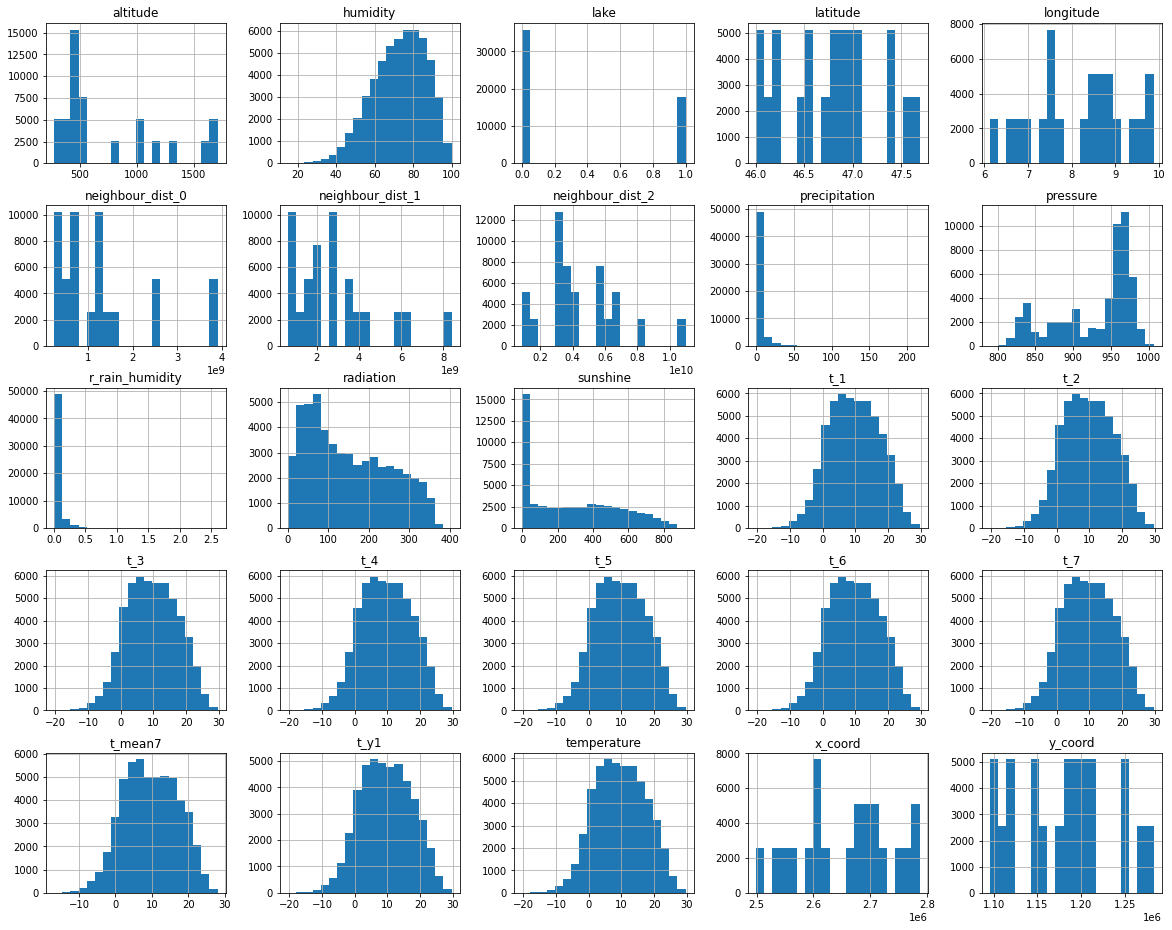

In [48]:
df_ok.drop(['stn', 'time', 'year', 'month', 'day', 'season'], axis=1).hist(figsize=(20,16), bins=20);

Analysis of the skewness in the original features.

In [49]:
# Analysis of the skewness (after 0 removal)
from scipy.stats import skew

orig_feat = ['radiation', 'pressure', 'temperature', 'precipitation', 'humidity', 'sunshine']

for c in orig_feat:
    s = skew(df_ok.loc[df_ok[c]!=0, c].dropna())
    print('Skewness of variable', c, ': {0:.2f}'.format(s))

Skewness of variable radiation : 0.41
Skewness of variable pressure : -0.86
Skewness of variable temperature : -0.05
Skewness of variable precipitation : 4.09
Skewness of variable humidity : -0.46
Skewness of variable sunshine : 0.24


Only the variable precipitaion is really skewed (after zeros removal). Let's apply a log-transform to it to remove skewness.

In [50]:
df_ok.loc[:, 'precipitation'] = np.log1p(df_ok['precipitation'])
print("Skewness of the log-transformed variable 'precipitation' : {0:.2f}".format(skew(df_ok.loc[df_ok['precipitation']!=0, 'precipitation'].dropna())))

Skewness of the log-transformed variable 'precipitation' : 0.35


As suggested in the additionnal notebook of [Unit 04.02.05](https://learn.extensionschool.ch/learn/programs/applied-data-science-machine-learning-v2/subjects/k-nearest-neighbors-v2/units/standardization-and-k-nn-v2) called *Standardization and k-NN*, the trend, saisonality and variance's evolution ot the time serie must be analyzed.

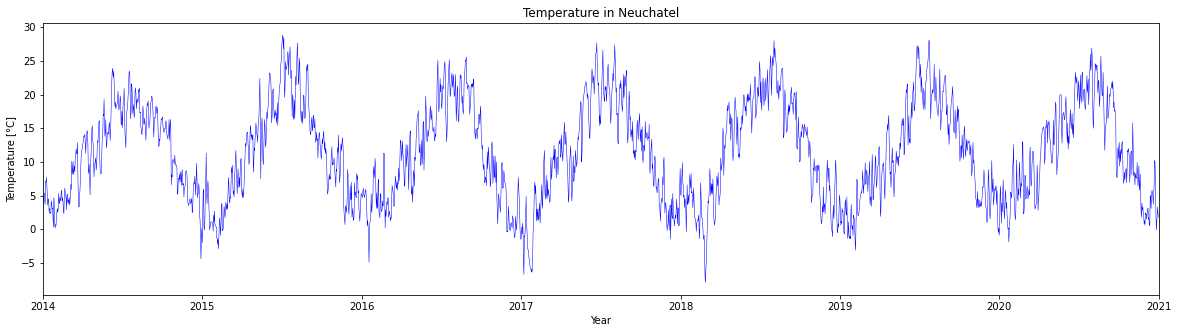

In [51]:
# Plot the temperature
fig, ax = plt.subplots(figsize=(20,5))

dates = matplotlib.dates.date2num(df_ok.loc[df_ok['stn']=='NEU', ['time']])
values = df_ok.loc[df_ok['stn']=='NEU', ['temperature']]
plt.plot_date(dates, values, 'b-', linewidth=0.5)

ax.set_xlim(xmin="2014-01-01", xmax="2021-01-01")

plt.xlabel('Year')
plt.ylabel('Temperature [°C]')
plt.title('Temperature in Neuchatel')

plt.show()

No trend or variance evolution over time seem to be present, but clearly seasonality appears. One way to remove it from the time serie is to difference it by substracting to the temperature the value the same day one year ago. Or better, to avoid *extreme values influence*, to substract a moving average over a couple of days last year (be carefull with this : it could kill the dependency on the temperature one year before, because it includes a common period of time to consecutive days which smoothes the adjusted temperature).

In [52]:
# Define a function to adjust a series t by substracting a moving average over a couple of values of t_y1.
def seas_adj(t_serie, nb_rolling):
    # t_serie : Time serie to be seasonal adjusted
    # nb_rolling : number of lag in the rolling mean
    
    lags = pd.DataFrame()
    for l in np.arange(nb_rolling):
        to_add = t_serie.shift(periods=l) # compute lag
        to_add.rename('lag_'+np.str(l), inplace=True) # name of the lag
        lags = pd.concat([lags, to_add], axis=1)

    
    roll_mean = lags.mean(axis=1) # compute mean
    roll_mean.rename('mean_'+np.str(nb_rolling), inplace=True) # name of the mean
    lags = pd.concat([lags, roll_mean], axis=1)
    return lags    

Let's adjust the temperature serie by substracting a moving average over 7 days one year ago. Let's do it for each station.

In [53]:
nb_roll_mean = 7
# rolling_mean = seas_adj(df_ok.t_y1, nb_roll_mean)
t_adj = pd.Series([])
    
for s in df_ok.stn.unique():
    rolling_mean = seas_adj(df_ok.loc[df_ok['stn']==s, 't_y1'], nb_roll_mean)
    deseas_values = df_ok.loc[df_ok['stn']==s, 'temperature'] - rolling_mean['mean_'+np.str(nb_roll_mean)]
    t_adj = t_adj.append(deseas_values)

df_ok['t_adj'] = t_adj
# old version : substracting the value the same day one year ago (correspondng to seas_adj(df_ok.t_y1, 1)
# deseas_values = df_ok.loc[df_ok['stn']=='NEU', 'temperature'] - df_ok.loc[df_ok['stn']=='NEU', 't_y1']

Let's plot the adjusted temperature in Neuchatel.

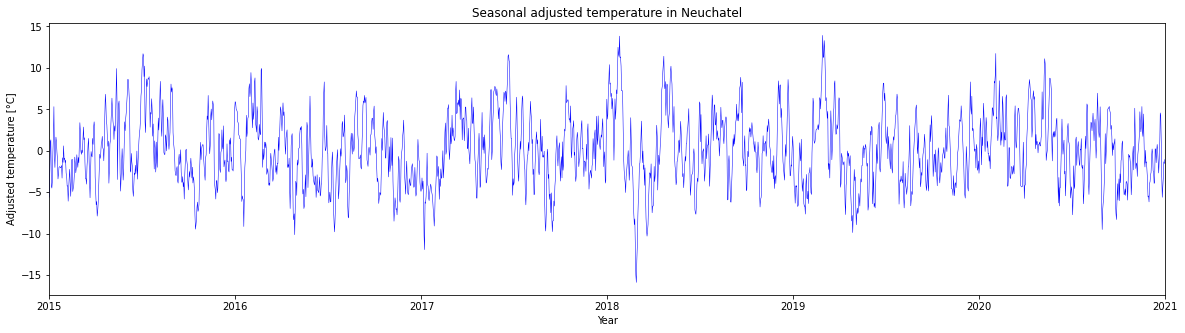

In [54]:
# Plot the seasanal adjusted temperature
fig, ax = plt.subplots(figsize=(20,5))

plt.plot_date(dates, df_ok.loc[df_ok['stn']=='NEU', 't_adj'] , 'b-', linewidth=0.5)
# plt.plot(df_ok.loc[df_ok['stn']=='NEU', ['temperature']])

ax.set_xlim(xmin="2015-01-01", xmax="2021-01-01")

plt.xlabel('Year')
plt.ylabel('Adjusted temperature [°C]')
plt.title('Seasonal adjusted temperature in Neuchatel')

plt.show()

Remark : No use of the seasonal adjusted temperature is made in this notebook. However, an additionnal notebook, namely *Weather_prediction_in_Neuchatel_adjusted_version* deals with seasonal adjusted measurements.

In order to work with a complete DataFrame for station Neuchatel, let's add (vertically) to the observations (=rows) about station `NEU` the measurements (temperature, radiation, pressure, precipitation, humidity and sunshine) the same days in all the other stations.

In [55]:
df_NEU = df_ok.loc[df_ok['stn']=='NEU']
for s in df_ok['stn'].unique():
    if s != 'NEU':
        var_temp = 't_'+np.str(s) # name of the temperature in station s
        var_radiation = 'rad_'+np.str(s) # name of the radiation in station s
        var_pressure = 'press_'+np.str(s) # name of the pressure in station s
        var_precipitation = 'preci_'+np.str(s) # name of the precipitation in station s
        var_humidity = 'hum_'+np.str(s) # name of the humidity in station s
        var_sunshine = 'sun_'+np.str(s) # name of the sunshine in station s
        var_altitude = 'alt_'+np.str(s) # name of the altitude in station s
        var_longitude = 'long_'+np.str(s) # name of the longitude in station s
        var_latitude = 'lat_'+np.str(s) # name of the latitude in station s
        var_lake = 'lake_'+np.str(s) # name of the presence of a lake in station s
        df_to_add = df_ok.loc[df_ok['stn']==s, ['time', 'temperature', 'radiation', 'pressure', 'precipitation', 'humidity', 'sunshine', 'altitude', 'longitude', 'latitude', 'lake']] # keep the lag also ???????????????????????????????????
        df_to_add.rename(columns={'temperature': var_temp, 
                                  'radiation': var_radiation,
                                  'pressure': var_pressure,
                                  'precipitation': var_precipitation,
                                  'humidity': var_humidity,
                                  'sunshine': var_sunshine,
                                  'altitude': var_altitude,
                                  'longitude': var_longitude,
                                  'latitude': var_latitude,
                                  'lake': var_lake}, inplace=True)
        df_to_add.drop_duplicates(subset=['time'],inplace=True)
        df_NEU = pd.merge(df_NEU, df_to_add, on=['time'], how='left') # merge the lag i temperature to already computed lag

print(df_NEU.shape)
df_NEU.head()   

(2557, 237)


stn       time  radiation  pressure  temperature  precipitation  humidity  \
0  NEU 2014-01-01       37.0     959.8          3.6       1.308333      90.9   
1  NEU 2014-01-02       15.0     950.6          4.4       2.360854      93.5   
2  NEU 2014-01-03       13.0     956.4          4.9       1.504077      93.5   
3  NEU 2014-01-04        4.0     955.7          5.4       3.250374      96.1   
4  NEU 2014-01-05       66.0     952.4          4.4       0.000000      79.7   

   sunshine  year  month  ...  t_SMA  rad_SMA  press_SMA  preci_SMA  hum_SMA  \
0      97.0  2014      1  ...    2.8     57.0      951.1   0.182322     77.8   
1      13.0  2014      1  ...    3.5     20.0      942.0   0.641854     86.8   
2       0.0  2014      1  ...    4.5     20.0      947.6   0.693147     80.6   
3       0.0  2014      1  ...    4.9      6.0      947.2   2.163323     90.8   
4     302.0  2014      1  ...    3.5     37.0      942.6   0.262364     86.2   

   sun_SMA  alt_SMA  long_SMA    lat_SMA  lake_SMA  
0    246.0      558  8.565733  47.377883         0  
1     36.0      558  8.565733  47.377883         0  
2      3.0      558  8.565733  47.377883         0  
3      0.0      558  8.565733  47.377883         0  
4    136.0      558  8.565733  47.377883         0  

[5 rows x 237 columns]

Some variables (e.g. 'canton') take only a single value. They do not add any information and can be dropped.

In [56]:
col_unique_value = df_NEU.nunique()[df_NEU.nunique()==1].index
col_unique_value

Index(['stn', 'station', 'canton', 'altitude', 'latitude', 'longitude', 'lake',
       'x_coord', 'y_coord', 'neighbour_0', 'neighbour_dist_0', 'neighbour_1',
       'neighbour_dist_1', 'neighbour_2', 'neighbour_dist_2', 'alt_ABO',
       'long_ABO', 'lat_ABO', 'lake_ABO', 'alt_ALT', 'long_ALT', 'lat_ALT',
       'lake_ALT', 'alt_BAS', 'long_BAS', 'lat_BAS', 'lake_BAS', 'alt_BER',
       'long_BER', 'lat_BER', 'lake_BER', 'alt_CHU', 'long_CHU', 'lat_CHU',
       'lake_CHU', 'alt_DAV', 'long_DAV', 'lat_DAV', 'lake_DAV', 'alt_DIS',
       'long_DIS', 'lat_DIS', 'lake_DIS', 'alt_ENG', 'long_ENG', 'lat_ENG',
       'lake_ENG', 'alt_GVE', 'long_GVE', 'lat_GVE', 'lake_GVE', 'alt_CDF',
       'long_CDF', 'lat_CDF', 'lake_CDF', 'alt_OTL', 'long_OTL', 'lat_OTL',
       'lake_OTL', 'alt_LUG', 'long_LUG', 'lat_LUG', 'lake_LUG', 'alt_LUZ',
       'long_LUZ', 'lat_LUZ', 'lake_LUZ', 'alt_PUY', 'long_PUY', 'lat_PUY',
       'lake_PUY', 'alt_SAM', 'long_SAM', 'lat_SAM', 'lake_SAM', 'alt_SHA',
       '

In [57]:
df_NEU.drop(col_unique_value, axis=1, inplace=True)

Before going further let's have a look to dtype of the variables

In [58]:
non_float_var = df_NEU.dtypes.loc[df_NEU.dtypes!='float64'] # df_ok.dtypes has a not friendly output
non_float_var

time     datetime64[ns]
year              int64
month             int64
day               int64
dtype: object

In [59]:
df_NEU[['t_1', 't_2', 't_3', 't_4', 't_5', 't_6', 't_7', 't_y1']].isnull().sum()

t_1       1
t_2       2
t_3       3
t_4       4
t_5       5
t_6       6
t_7       7
t_y1    365
dtype: int64

Missing values are present in lag variables by construction. As mentioned at the beginning, let's use year 2014 to compute lag values and drop it.

In [60]:
df_NEU = df_NEU.loc[df_NEU['time'] >= '2015-01-01'].copy()
df_NEU.isnull().sum()[df_NEU.isnull().sum()!=0]

Series([], dtype: int64)

No more variable will be added later on to the DataFrame df_NEU.

##### **D.1.2 Train-validation split and standardization**

It is time to split the data in order to predict value for temperature in 2020.

- The train set covers years 2015 to 2018.
- The validation set consist in the year 2019.
- The test set: year 2020 will be used to predict data.

The target variable is the temperature. The adjusted temperature `t_adj` will be removed (it's a linear combination of the target variable and some features). In the validation and test sets, the temperature will not be used for predictions but only to check the quality of them.

In [61]:
# Create X/y arrays
X_orig = df_NEU.drop('t_adj', axis=1).loc[df_NEU.time<'2020-01-01'].copy() # observations of years before 2019 will be used for training and testing.
X_orig_tr = X_orig.loc[(X_orig.time<'2019-01-01')].copy() # observations of years up to 2018 will be used for training.
X_orig_te = X_orig.loc[(X_orig.time>='2019-01-01') & (X_orig.time<'2020-01-01')].copy() # observations of year 2019 will be used for testing.
X_to_predict = df_NEU.drop('t_adj', axis=1).loc[df_NEU.time>='2020-01-01'].copy() # observations of year 2020 will be predicted.

time_te = X_orig.loc[(X_orig.time>='2019-01-01') & (X_orig.time<'2020-01-01')].time
time_to_predict = X_to_predict.time

y = X_orig.temperature.copy()
y_tr = X_orig_tr.temperature.copy()
y_te = X_orig_te.temperature.copy()
y_to_predict = X_to_predict.temperature.copy()

# drop variable 'temperature' in "X_" Dataframe
X_orig.drop('temperature', axis=1, inplace=True)
X_orig_tr.drop('temperature', axis=1, inplace=True)
X_orig_te.drop('temperature', axis=1, inplace=True)
X_to_predict.drop('temperature', axis=1, inplace=True)

print('X_orig:', X_orig.shape)
print('y:', y.shape, y.dtypes)

X_orig: (1826, 140)
y: (1826,) float64


Let's standardize the features using 'StandardScaler' from Scikit-learn.

In [62]:
from sklearn.preprocessing import StandardScaler

# Create the StandardScaler object and fit it to train data
scaler = StandardScaler()
scaler.fit(X_orig_tr.drop(['time'], axis=1).astype(float)) # To standardize the features, all variable must be of type `float` (or `int`, but a warning is displayed for 'int').

StandardScaler(copy=True, with_mean=True, with_std=True)

In [63]:
# Standardize features
X_orig_rescaled_array = scaler.transform(X_orig.drop(['time'], axis=1).astype(float))
X_orig_tr_rescaled_array = scaler.transform(X_orig_tr.drop(['time'], axis=1).astype(float))
X_orig_te_rescaled_array = scaler.transform(X_orig_te.drop(['time'], axis=1).astype(float))
X_to_predict_rescaled_array = scaler.transform(X_to_predict.drop(['time'], axis=1).astype(float))

# Transform the array into DataFrame
col_rescaled = X_orig_tr.drop(['time'], axis=1).columns
X_orig_rescaled = pd.DataFrame(data = X_orig_rescaled_array, columns = col_rescaled)
X_orig_tr_rescaled = pd.DataFrame(data = X_orig_tr_rescaled_array, columns = col_rescaled)
X_orig_te_rescaled = pd.DataFrame(data = X_orig_te_rescaled_array, columns = col_rescaled)
X_to_predict_rescaled = pd.DataFrame(data = X_to_predict_rescaled_array, columns = col_rescaled)

Remark : To avoid considering a year having special characteristics (e.g. a low temperature mean) as a validation test, we could use the [Time Series Split from scikit learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html). This cross-validation object is a variation of [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) which provides train/test indices to split time series data samples that are observed at fixed time intervals, in train/test sets. In each split, test indices must be higher than before, and thus shuffling in cross validator is inappropriate.

##### **D.1.3. Relationships among the features themselves and with the target**

First, let's compute the correlation between all the variables and the target.

In [64]:
corr_y_tr = X_orig_tr_rescaled.corrwith(y_tr, axis=0, drop=False, method='pearson')
corr_y_tr.sort_values()

hum_GVE         -0.477718
hum_SIO         -0.458719
humidity        -0.456114
hum_PUY         -0.447194
hum_BER         -0.446237
hum_SHA         -0.429495
hum_BAS         -0.401206
hum_SMA         -0.367573
hum_LUZ         -0.343336
hum_CDF         -0.269682
hum_STG         -0.207564
hum_CHU         -0.176748
hum_SAM         -0.118847
hum_ALT         -0.115157
hum_DIS         -0.083202
preci_GVE       -0.074758
preci_SIO       -0.070175
preci_CDF       -0.069745
hum_LUG         -0.067446
hum_OTL         -0.067028
hum_ZER         -0.066750
hum_DAV         -0.060736
press_LUG       -0.049389
preci_PUY       -0.049179
precipitation   -0.046397
preci_ZER       -0.028970
preci_BAS       -0.027935
hum_ENG         -0.021659
press_OTL       -0.018044
preci_SHA       -0.017652
                   ...   
rad_SIO          0.707796
t_ABO            0.739533
t_STG            0.752023
t_ENG            0.758628
t_CDF            0.769057
t_DIS            0.773869
t_ALT            0.779656
t_DAV       

And for measurements in Neuchatel only.

In [65]:
var_meas = ['humidity', 'precipitation', 'pressure', 'sunshine', 'radiation']
corr_y_tr[var_meas + ['season', 'year', 'month']].sort_values()

humidity        -0.456114
precipitation   -0.046397
year            -0.017251
pressure         0.032054
month            0.170021
sunshine         0.500294
season           0.516054
radiation        0.674871
dtype: float64

Unsurprisingly, temperatures the same day in the other stations and temperature's lags are highly correlated to temperature in Neuchatel (decreasing with the lag). The presence of sun (variables `sunshine` and `radiation`), the `season` and `humidity` also are.

Now let's do the same between some *relevant* variables themselves. Temperature in the others stations is not displayed for ease of reading.

In [66]:
# select relevant columns
corr_columns = var_meas + ['year', 'month', 'season', 'r_rain_humidity', 't_1', 't_y1', 't_mean7']
X_orig_tr_corr = X_orig_tr_rescaled[corr_columns].corr(method='pearson')

# determine threshold
corr_thresh = 0.5

id_corr = X_orig_tr_corr>corr_thresh
X_orig_tr_corr[id_corr]

humidity  precipitation  pressure  sunshine  radiation  year  \
humidity              1.0            NaN       NaN       NaN        NaN   NaN   
precipitation         NaN       1.000000       NaN       NaN        NaN   NaN   
pressure              NaN            NaN       1.0       NaN        NaN   NaN   
sunshine              NaN            NaN       NaN  1.000000   0.912893   NaN   
radiation             NaN            NaN       NaN  0.912893   1.000000   NaN   
year                  NaN            NaN       NaN       NaN        NaN   1.0   
month                 NaN            NaN       NaN       NaN        NaN   NaN   
season                NaN            NaN       NaN       NaN        NaN   NaN   
r_rain_humidity       NaN       0.881742       NaN       NaN        NaN   NaN   
t_1                   NaN            NaN       NaN  0.563939   0.703008   NaN   
t_y1                  NaN            NaN       NaN       NaN   0.670678   NaN   
t_mean7               NaN            NaN       NaN  0.534113   0.692890   NaN   

                    month    season  r_rain_humidity       t_1      t_y1  \
humidity              NaN       NaN              NaN       NaN       NaN   
precipitation         NaN       NaN         0.881742       NaN       NaN   
pressure              NaN       NaN              NaN       NaN       NaN   
sunshine              NaN       NaN              NaN  0.563939       NaN   
radiation             NaN       NaN              NaN  0.703008  0.670678   
year                  NaN       NaN              NaN       NaN       NaN   
month            1.000000  0.574696              NaN       NaN       NaN   
season           0.574696  1.000000              NaN  0.522970  0.531908   
r_rain_humidity       NaN       NaN         1.000000       NaN       NaN   
t_1                   NaN  0.522970              NaN  1.000000  0.799406   
t_y1                  NaN  0.531908              NaN  0.799406  1.000000   
t_mean7               NaN  0.574919              NaN  0.945577  0.824429   

                  t_mean7  
humidity              NaN  
precipitation         NaN  
pressure              NaN  
sunshine         0.534113  
radiation        0.692890  
year                  NaN  
month                 NaN  
season           0.574919  
r_rain_humidity       NaN  
t_1              0.945577  
t_y1             0.824429  
t_mean7          1.000000

Unsurprisingly, temperature-lags are correlated. Precipitations and the ratio of itself by humidity also is, as well as radiation and sunshine. To complete this comparison, let's perform a pairplot of the variables selected from the IDAweb portal.

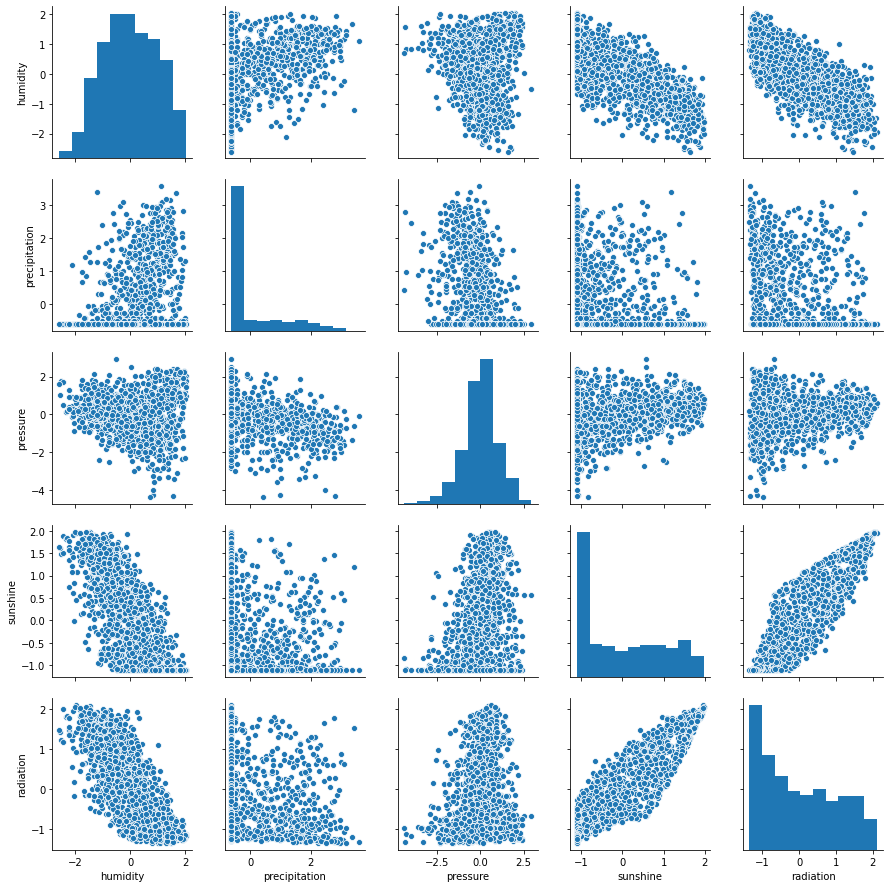

In [67]:
import seaborn as sns
check_coor = X_orig_tr_rescaled[var_meas]
# check_coor = X_orig_tr[var_meas] # correlation computed with non rescaled data
sns.pairplot(check_coor);

##### **D.1.4. Check for missing values and outliers**

Removal of missing values is already performed.

In [68]:
# missing values
X_orig_rescaled.isnull().sum()[X_orig_rescaled.isnull().sum() != 0]

Series([], dtype: int64)

C:\Users\muriel\.conda\envs\exts-ml\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\muriel\.conda\envs\exts-ml\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\muriel\.conda\envs\exts-ml\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\muriel\.conda\envs\exts-ml\lib\site-packages\pandas\plot

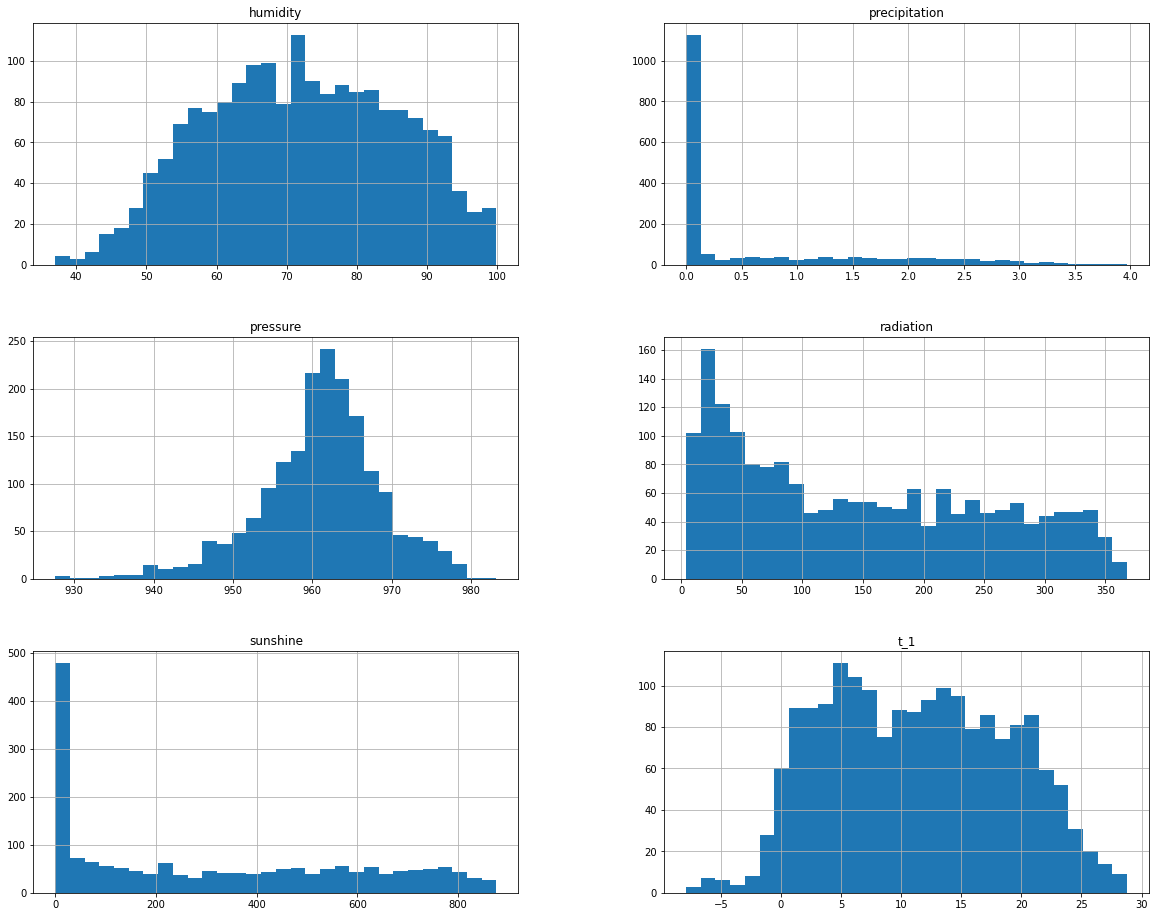

In [69]:
X_orig[var_meas + ['t_1']].hist(figsize=(20,16), bins=30);

No outliers seem to be present. Days without sunshine or precipitation are clearly visible.

#### **D.2. Principal Component Analysis**

##### **D.2.1 PCA**

##### **D.2.1.1 PCA with a selection of variables**

In [70]:
from sklearn.decomposition import PCA

In [71]:
# Components selection
# n_comp = 7 # number of components
# n_comp = .8 # select the number of components such that the amount of variance that needs to be explained is > the percentage specified.

# Create PCA transformer
# pca = PCA(n_components=n_comp, svd_solver='full') # svd_solver = 'full' if n_comp is a percentage.
pca = PCA(n_components=None) # Compute all the components in order to display the scree plot below

# Apply PCA
# var_pca = var_meas + ['season', 'month', 'year', 't_1', 't_y1']
var_pca = var_meas + ['season', 'month', 'year']
X_pca = X_orig_rescaled[var_pca].values
pca.fit(X_pca, y=None); # Unsupervised learning, no y variable

# Project data onto the first n_comp components
X_pca_ndim = pca.transform(X_pca)

In [72]:
# Create DataFrame with variance and the principal components
df_pca = pd.DataFrame({'variance': X_pca.var(axis=0)}).set_index([var_pca])
for k in np.arange(pca.n_components_):
    k_comp = 'loading vector ' + np.str(k+1) # name of k-th column
    df_pca[k_comp] = pca.components_[k]
    

# Sort DataFrame by variance
df_pca.sort_values('variance', ascending=False)

variance  loading vector 1  loading vector 2  loading vector 3  \
year           1.600438          0.006479         -0.916926          0.216879   
pressure       1.061462         -0.247190          0.290279          0.019039   
precipitation  1.009545          0.339549         -0.123548          0.008623   
radiation      1.000296         -0.515610         -0.096317         -0.065788   
month          0.999901         -0.010277          0.175849          0.716094   
season         0.999888         -0.177450          0.071427          0.645410   
sunshine       0.999189         -0.532255         -0.065549         -0.046291   
humidity       0.999011          0.492766          0.100608          0.129272   

               loading vector 4  loading vector 5  loading vector 6  \
year                   0.327654          0.053906         -0.042082   
pressure               0.675225          0.556508         -0.280698   
precipitation         -0.486339          0.777691         -0.021112   
radiation             -0.249497          0.160990          0.153285   
month                  0.089806          0.061268          0.637693   
season                -0.291804         -0.099310         -0.662616   
sunshine              -0.124009          0.190485          0.218466   
humidity               0.171312          0.082294          0.045342   

               loading vector 7  loading vector 8  
year                   0.002773         -0.011247  
pressure              -0.070853         -0.069515  
precipitation         -0.162954          0.032256  
radiation              0.350221         -0.697298  
month                 -0.186085         -0.055520  
season                 0.102486          0.047748  
sunshine               0.329370          0.708795  
humidity               0.831954         -0.004941

No loading vector has a coordinate close to 1 (meanning that it corresponds to a feature). Variable `year` has the largest absolute variance and the corresponding coordinate of `component 2` is about -.92.

Remark: variance is about 1 because of the standardization applied before

Let's now display a 2D plot of the PCA components. In order to do that, let define the following function to display scatter plots with markers defined by values of year. The code source comes from https://github.com/matplotlib/matplotlib/issues/11155.

In [73]:
#see https://github.com/matplotlib/matplotlib/issues/11155
def mscatter(x,y,ax=None, m=None, **kw):
    import matplotlib.markers as mmarkers
    if not ax: ax=plt.gca()
    sc = ax.scatter(x,y,**kw)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

In [74]:
import matplotlib.patheffects as path_effects

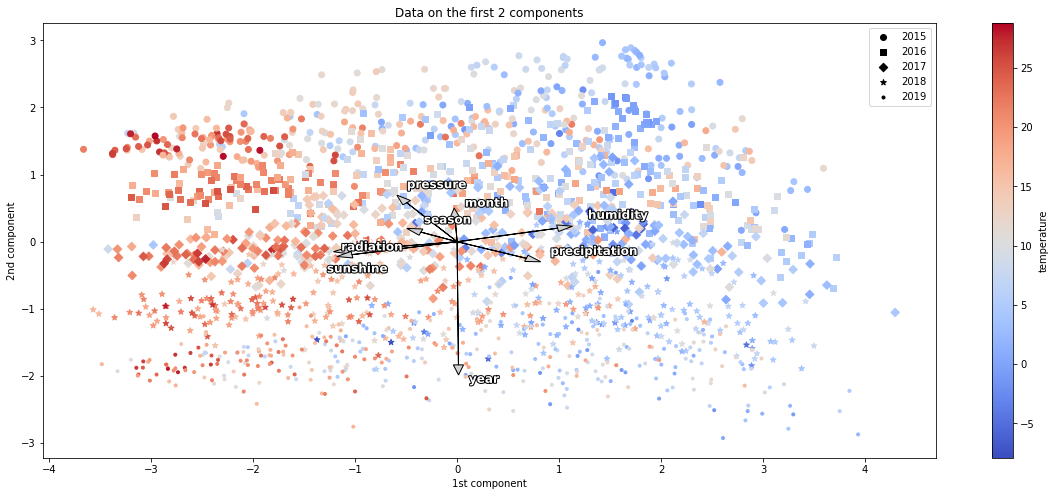

In [75]:
# Plot
fig, ax = plt.subplots(figsize=(20,8))

# Define a correspondance between years and markers to plot each year with a different marker
years = X_orig.year.unique()
markers = np.array(["o", "s", "D", "*", "."])
years_markers_dict = dict(zip(years, markers))
m = X_orig.replace({'year': years_markers_dict}).year

# use the function defined above to display the scatter plot
scatter = mscatter(X_pca_ndim[:, 0], X_pca_ndim[:, 1], c=y, cmap='coolwarm', m=m, ax=ax) # color in function of the temperature
fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=np.min(y), vmax=np.max(y)), cmap='coolwarm'), ax=ax, label='temperature') # add the bar on the right

# Plot a few features using the weights in the loading vectors
for feature in var_pca:
    # Get weights
    weight1 = df_pca.loc[feature, 'loading vector 1']*2 # rescale them
    weight2 = df_pca.loc[feature, 'loading vector 2']*2 # (2 is arbitrary)
    # Plot arrows
    plt.arrow(
        0, 0, # Vector starts at (x,y)=(0,0)
        weight1, weight2, # ends at (x,y)=(weight1, weight2)
        head_width=0.1, head_length=0.15, fc='lightgrey', ec='black')
    # Add text
    text = plt.text(
        weight1 * 1.2 + 0.1, # x location (1.2 is arbitrary)
        weight2 * 1.2 + 0.1, # y location
        feature, # Feature name
        weight='bold', color='white', size=12)
    if feature == 'sunshine': # to avoid overlapping of 'radiation' and 'sunshine'
        text = plt.text(
            weight1 * 1.2, # x location (1.2 is arbitrary)
            weight2 * 1.2 - 0.3, # y location
            feature, # Feature name
            weight='bold', color='white', size=12)      
    # Make the text stand out
    text.set_path_effects([
        path_effects.Stroke(linewidth=2, foreground='black'),
        path_effects.Normal()])

# add the correspondance years <-> markers in the legend
custom_handles = []
for year, mark, n in zip(years, markers, np.arange(len(years))):
    custom_handles.append(plt.scatter([], [], c='black', marker=mark, label=str(year)))
plt.legend(handles=custom_handles)
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.title('Data on the first 2 components')
plt.show()

The plot on the two first components shows a particular pattern: points corresponding to high (resp. low) temperature have a low (resp. large) 1<sup>st</sup> component. It makes the *colour gradient* horizontally. Moreover, radiation, sunshine and in a less pronounced way 'pressure'  point to high temperatures, while 'precipitation' and 'humidity' point to low temperatures. This seems to be logical. 

Vertically, the five different years seem to be separated on the 2<sup>nd</sup> component (each year is represented by a marker with a different shape). This was already highlighted by the first coordinate of the second loading vector for the `year` feature. A 3D-plot emphasizes better the separation by years (using module `Axes3D`from library `mpl_toolkits` and adapted from https://www.studytonight.com/matplotlib/matplotlib-3d-plotting-line-and-scatter-plot).

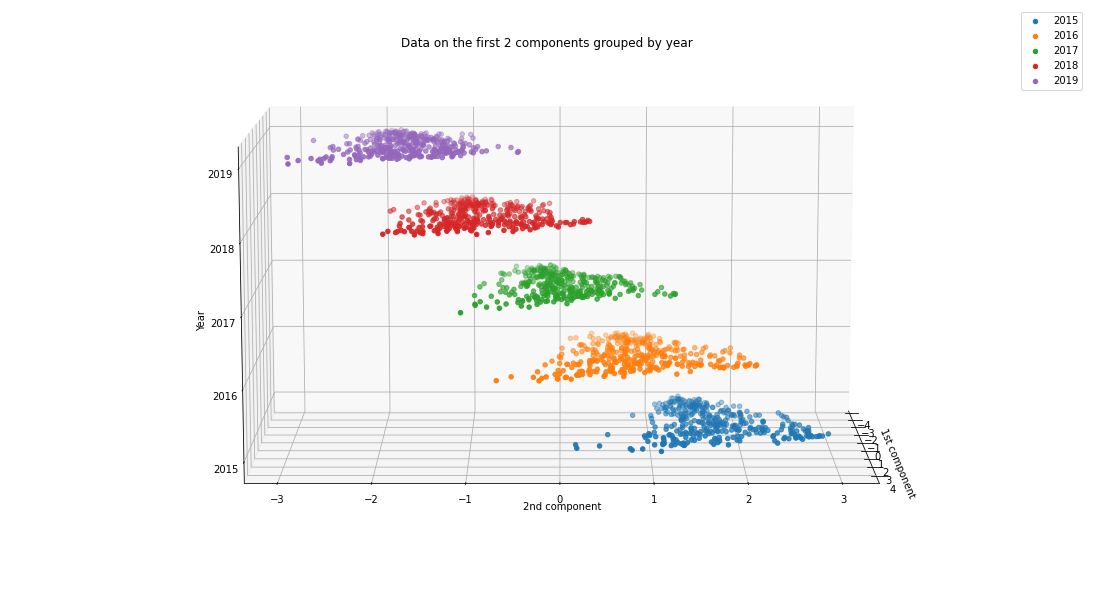

In [76]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,8)) # Size of the figure
ax = Axes3D(fig)

# Plot each year in a different colour
years_rescaled_dict = dict(zip(np.unique(X_pca[:,-1]), X_orig.year.unique()))

# for kind in np.unique(X_orig.year):
for kind in np.unique(X_pca[:,-1]):

    # Image samples of this type
    idx = (X_pca[:,-1] == kind)

    # Plot their components
    ax.scatter(X_pca_ndim[idx, 0], X_pca_ndim[idx, 1], X_pca[idx, -1], label=years_rescaled_dict[kind])
    ax.view_init(elev=10, azim=0) # set a view where the clusters are clearly visibles

# set z ticks and labels
ax.set_zticks(list(years_rescaled_dict.keys()))
ax.set_zticklabels(years_rescaled_dict.values())

# Labels and legend
plt.legend()
ax.set_xlabel('1st component')
ax.set_ylabel('2nd component')
ax.set_zlabel('Year', rotation=90)
plt.title('Data on the first 2 components grouped by year')
plt.show()

On this plot, Data points are projected on the first two components (horizontally in 2D), vertically grouped and coloured by year. We can clearly see that data points are shifted on the second component in function to the year.

Now let's compute the explained variance ratio b component.

In [77]:
# Display variance info
pve = pca.explained_variance_ratio_.transpose() # Proportion of variance explained
df_explained_variance_ratio_ = pd.DataFrame(data=pve, columns=(['explained variance ratio']), index=1 + np.arange(pca.n_components_))
df_explained_variance_ratio_.index.set_names(['component'], inplace=True)
display(df_explained_variance_ratio_)

explained variance ratio
component                          
1                          0.353399
2                          0.192143
3                          0.179766
4                          0.133436
5                          0.066797
6                          0.036430
7                          0.028932
8                          0.009096

To visualize these ratios, let's display a Scree plot, that is a bar chart with the proportion of variance explained for each component.

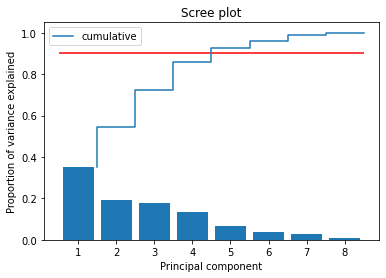

In [78]:
# Create bar plot
xcor = 1 + np.arange(len(pve)) # 1,2,..,n_components
plt.bar(xcor, pve)
plt.hlines(y=0.9, xmin=.5, xmax=len(pve)+.5, color='red') # display the threshold of 90%
plt.xticks(xcor)

# Add cumulative sum
pve_cumsum = np.cumsum(pve)
plt.step(
    xcor+0.5, # 1.5,2.5,..,n_components+0.5
    pve_cumsum, # Cumulative sum
    label='cumulative'
)

# Add labels
plt.title('Scree plot')
plt.xlabel('Principal component')
plt.ylabel('Proportion of variance explained')
plt.legend()
plt.show()

Five components are required to explain 90% of the variance (only 4 are needed to reach 80%).

##### **D.2.1.2 PCA with all variables**

In [79]:
# Create PCA transformer
pca_all = PCA(n_components=None) # Compute all the components in order to display the scree plot below

# Apply PCA
var_pca_all = X_orig_rescaled.columns
X_pca_all = X_orig_rescaled.values
pca_all.fit(X_pca_all, y=None); # Unsupervised learning, no y variable

# Project data onto the first n_comp components
X_pca_all_ndim = pca_all.transform(X_pca_all)

In [80]:
# Create DataFrame with variance and the principal components
df_pca_all = pd.DataFrame({'variance': X_pca_all.var(axis=0)}).set_index([var_pca_all])
for k in np.arange(pca_all.n_components_):
    k_comp = 'loading vector ' + np.str(k+1) # name of k-th column
    df_pca_all[k_comp] = pca_all.components_[k]
    

# Sort DataFrame by variance
df_pca_all.sort_values('variance', ascending=False).head()

variance  loading vector 1  loading vector 2  loading vector 3  \
year       1.600438         -0.000954         -0.024058          0.040377   
sun_DIS    1.173347          0.041455         -0.068729          0.050313   
press_BAS  1.072608          0.048222          0.154217         -0.134219   
hum_CDF    1.072126         -0.093264         -0.038843         -0.070661   
press_SHA  1.066452          0.052920          0.151344         -0.134686   

           loading vector 4  loading vector 5  loading vector 6  \
year              -0.005755          0.013560          0.038865   
sun_DIS           -0.025543         -0.017871          0.189092   
press_BAS          0.001279         -0.062188          0.024800   
hum_CDF           -0.116030         -0.048594         -0.132336   
press_SHA          0.014856         -0.044554          0.016158   

           loading vector 7  loading vector 8  loading vector 9  ...  \
year               0.037405          0.698170          0.660217  ...   
sun_DIS           -0.030346         -0.126655          0.330127  ...   
press_BAS          0.062886         -0.035101          0.050001  ...   
hum_CDF           -0.045790         -0.073275          0.034082  ...   
press_SHA          0.058001         -0.035627          0.050350  ...   

           loading vector 130  loading vector 131  loading vector 132  \
year                -0.004820            0.005535           -0.003547   
sun_DIS             -0.001597            0.000649           -0.000970   
press_BAS           -0.116019           -0.092451            0.009007   
hum_CDF             -0.007603           -0.003931           -0.000929   
press_SHA            0.035134           -0.166698           -0.288896   

           loading vector 133  loading vector 134  loading vector 135  \
year                -0.000656            0.003361            0.000159   
sun_DIS             -0.001162           -0.000136            0.000625   
press_BAS            0.140708           -0.121420            0.017663   
hum_CDF             -0.004556            0.002335            0.004695   
press_SHA           -0.505894            0.431937            0.043247   

           loading vector 136  loading vector 137  loading vector 138  \
year                -0.005509            0.000450           -0.001506   
sun_DIS             -0.000404            0.000120           -0.000792   
press_BAS           -0.080716           -0.048730           -0.032804   
hum_CDF             -0.002016           -0.000586            0.000405   
press_SHA           -0.011342            0.102165           -0.190503   

           loading vector 139  
year             1.320871e-17  
sun_DIS         -0.000000e+00  
press_BAS       -4.510281e-17  
hum_CDF         -2.775558e-17  
press_SHA       -8.951173e-16  

[5 rows x 140 columns]

Let's now display a 2D plot of the PCA components.

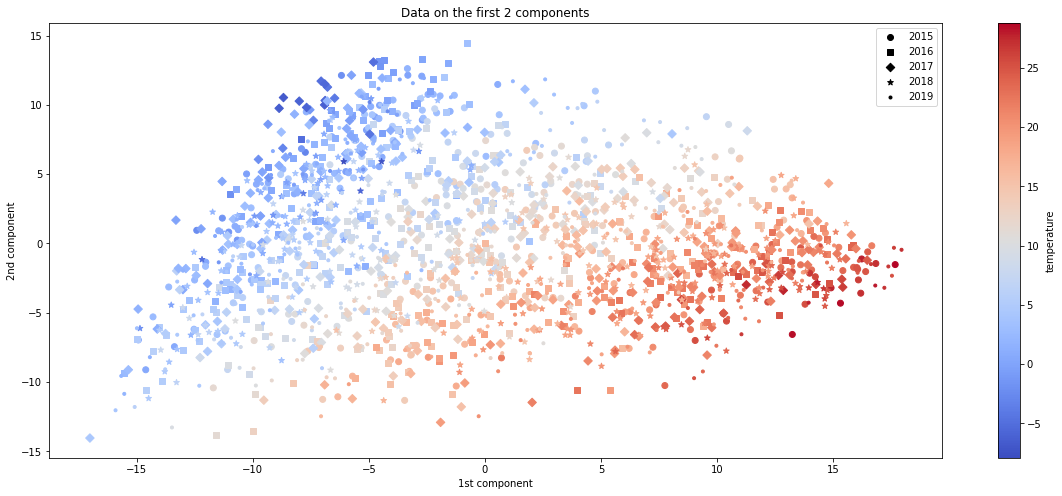

In [81]:
# Plot
fig, ax = plt.subplots(figsize=(20,8))

# Define a correspondance between years and markers to plot each year with a different marker
years = X_orig.year.unique()
markers = np.array(["o", "s", "D", "*", "."])
years_markers_dict = dict(zip(years, markers))
m = X_orig.replace({'year': years_markers_dict}).year

# use the function defined above to display the scatter plot
scatter = mscatter(X_pca_all_ndim[:, 0], X_pca_all_ndim[:, 1], c=y, cmap='coolwarm', m=m, ax=ax) # color in function of the temperature
fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=np.min(y), vmax=np.max(y)), cmap='coolwarm'), ax=ax, label='temperature') # add the bar on the right

# Plot a few features using the weights in the loading vectors
# for feature in var_pca_all:
#     # Get weights
#     weight1 = df_pca_all.loc[feature, 'loading vector 1']*2 # rescale them
#     weight2 = df_pca_all.loc[feature, 'loading vector 2']*2 # (2 is arbitrary)
#     # Plot arrows
#     plt.arrow(
#         0, 0, # Vector starts at (x,y)=(0,0)
#         weight1, weight2, # ends at (x,y)=(weight1, weight2)
#         head_width=0.1, head_length=0.15, fc='lightgrey', ec='black')
#     # Add text
#     text = plt.text(
#         weight1 * 100 + 0.1, # x location (10 is arbitrary)
#         weight2 * 100 + 0.1, # y location
#         feature, # Feature name
#         weight='bold', color='white', size=12)
#     if feature == 'sunshine': # to avoid overlapping of 'radiation' and 'sunshine'
#         text = plt.text(
#             weight1 * 100, # x location (1.2 is arbitrary)
#             weight2 * 100 - 0.3, # y location
#             feature, # Feature name
#             weight='bold', color='white', size=12)      
#     # Make the text stand out
#     text.set_path_effects([
#         path_effects.Stroke(linewidth=2, foreground='black'),
#         path_effects.Normal()])

# add the correspondance years <-> markers in the legend
custom_handles = []
for year, mark, n in zip(years, markers, np.arange(len(years))):
    custom_handles.append(plt.scatter([], [], c='black', marker=mark, label=str(year)))
plt.legend(handles=custom_handles)
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.title('Data on the first 2 components')
plt.show()

The plot on the two first components shows a particular pattern: points corresponding to high (resp. low) temperature have a high (resp. low) 1<sup>st</sup> component. It makes the *colour gradient* almost horizontally. 

Now let's compute the explained variance ratio b component.

In [82]:
# Display variance info
pve_all = pca_all.explained_variance_ratio_.transpose() # Proportion of variance explained
df_all_explained_variance_ratio_ = pd.DataFrame(data=pve_all, columns=(['explained variance ratio']), index=1 + np.arange(pca_all.n_components_))
df_all_explained_variance_ratio_.index.set_names(['component'], inplace=True)
display(df_all_explained_variance_ratio_.head())

explained variance ratio
component                          
1                          0.434363
2                          0.186199
3                          0.097903
4                          0.045662
5                          0.041220

To visualize these ratios, let's display a Scree plot, that is a bar chart with the proportion of variance explained for each component.

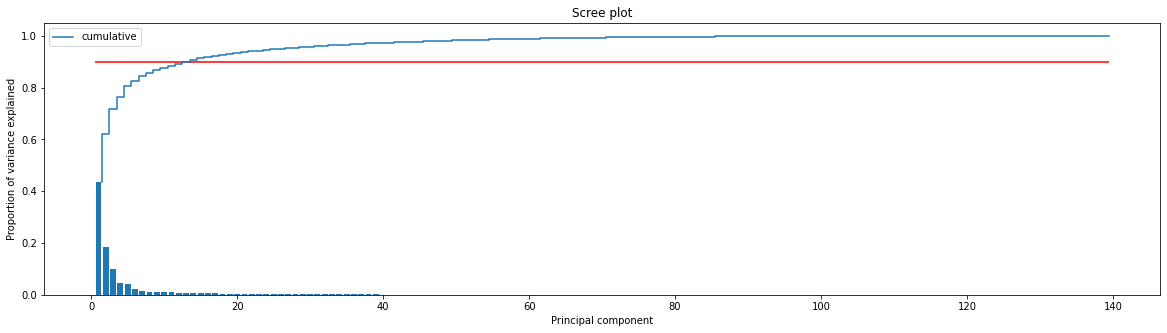

In [83]:
fig, ax = plt.subplots(figsize=(20, 5))

# Create bar plot
xcor_all = 1 + np.arange(len(pve_all)) # 1,2,..,n_components
plt.bar(xcor_all, pve_all)
plt.hlines(y=0.9, xmin=.5, xmax=len(pve_all)+.5, color='red') # display the threshold of 90%
# plt.xticks(xcor_all)

# Add cumulative sum
pve_cumsum_all = np.cumsum(pve_all)
plt.step(
    xcor_all+0.5, # 1.5,2.5,..,n_components+0.5
    pve_cumsum_all, # Cumulative sum
    label='cumulative'
)

# Add labels
plt.title('Scree plot')
plt.xlabel('Principal component')
plt.ylabel('Proportion of variance explained')
plt.legend()

In [84]:
first = 0
for i in np.arange(len(pve_cumsum_all)):
    if first == 0:
        if pve_cumsum_all[i] > .9:
            print('{} components are required to explain 90% of the variance.'.format(i))
            first = 1

12 components are required to explain 90% of the variance.


##### **D.2.2 SelectKBest based on p-value**

In order to analyze the most influent variables, let's select the k best variables according to the p-value. First among the measurements and the lags.

In [85]:
from sklearn.feature_selection import SelectKBest, f_regression

In [86]:
X_tr_intermediate_tmp = X_orig_tr[var_meas + ['t_1', 't_y1']].copy() # consider only the original measurement and the temperature
dates = matplotlib.dates.date2num(X_orig_tr['time'])
X_tr_intermediate_tmp['time'] = dates
y_tr_intermediate = y_tr.copy()

# Number of features considered
k = 5 

# Create the selecter object
skb = SelectKBest(f_regression, k=k)

# Fit the selecter to the data
X_tr_intermediate_tmp2 = skb.fit_transform(X_tr_intermediate_tmp, y_tr_intermediate)

# Extract the top k features from the `pvalues_` attribute
k_feat = np.argsort(skb.pvalues_)[:k]
var_skb_meas = X_tr_intermediate_tmp.columns[k_feat]
var_skb_meas

Index(['t_1', 't_y1', 'radiation', 'sunshine', 'humidity'], dtype='object')

Then among all variables.

In [87]:
from sklearn.feature_selection import SelectKBest, f_regression

# convert variable 'time' from TimeStamp to dates
X_tr_intermediate_tmp = X_orig_tr.drop(['time'], axis=1) # consider all variables
dates = matplotlib.dates.date2num(X_orig_tr['time'])
X_tr_intermediate_tmp['time'] = dates
y_tr_intermediate = y_tr.copy()

# Number of features considered
k = 5 

# Create the selecter object
skb = SelectKBest(f_regression, k=k)

# Fit the selecter to the data
X_tr_intermediate_tmp2 = skb.fit_transform(X_tr_intermediate_tmp, y_tr_intermediate)

# Extract the top k features from the `pvalues_` attribute
k_feat = np.argsort(skb.pvalues_)[:k]
var_skb_meas_all = X_tr_intermediate_tmp.columns[k_feat]
var_skb_meas_all

Index(['t_ZER', 't_DIS', 't_OTL', 't_BER', 't_ALT'], dtype='object')

Note that the temperature in the geographical nearest neighbours (`CDF`) are not present in these selected variables (the difference of altitude and topography could explain that). No measurements other than temperature are present anymore.

##### **D.2.3 Final check**

Let's take again a final look at the dataset to confirm everything is ready for the machine learning part. First let's plot each variable as a time serie (grouped by measurement).

C:\Users\muriel\.conda\envs\exts-ml\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\muriel\.conda\envs\exts-ml\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\muriel\.conda\envs\exts-ml\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\muriel\.conda\envs\exts-ml\lib\site-packages\pandas\plot

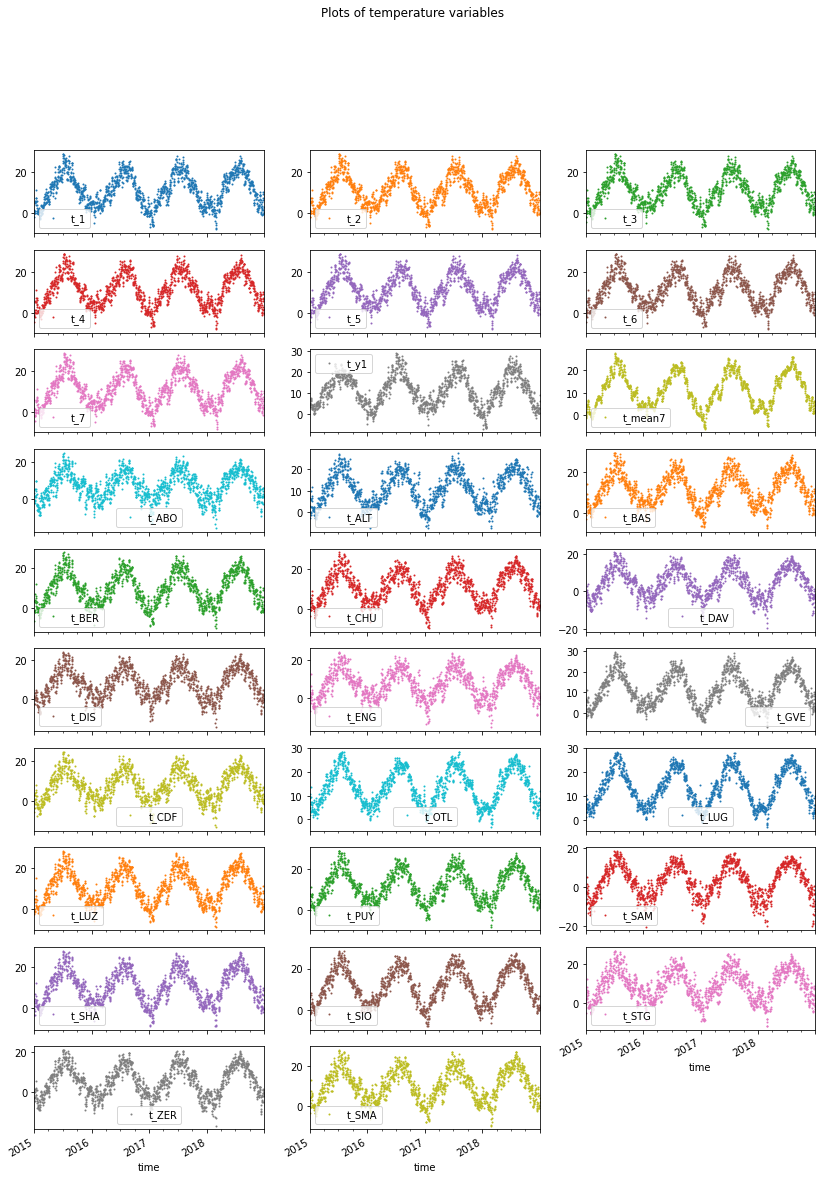

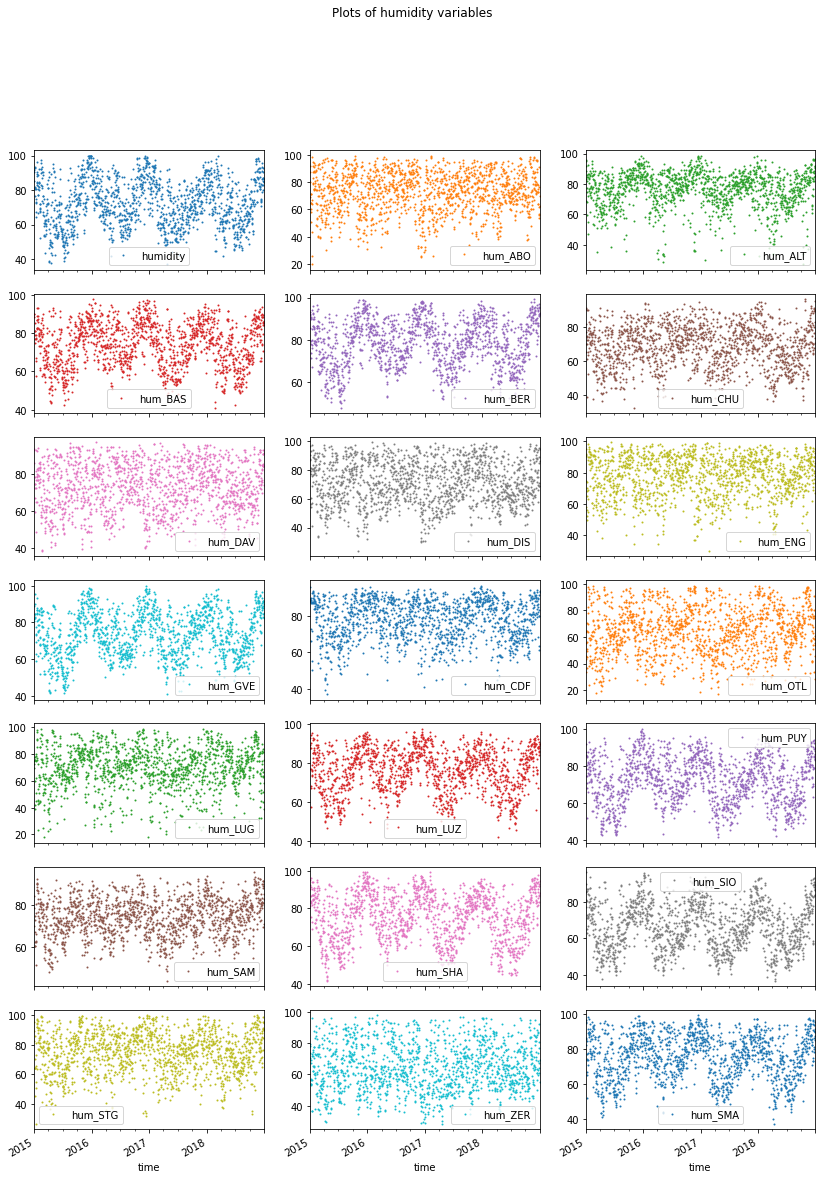

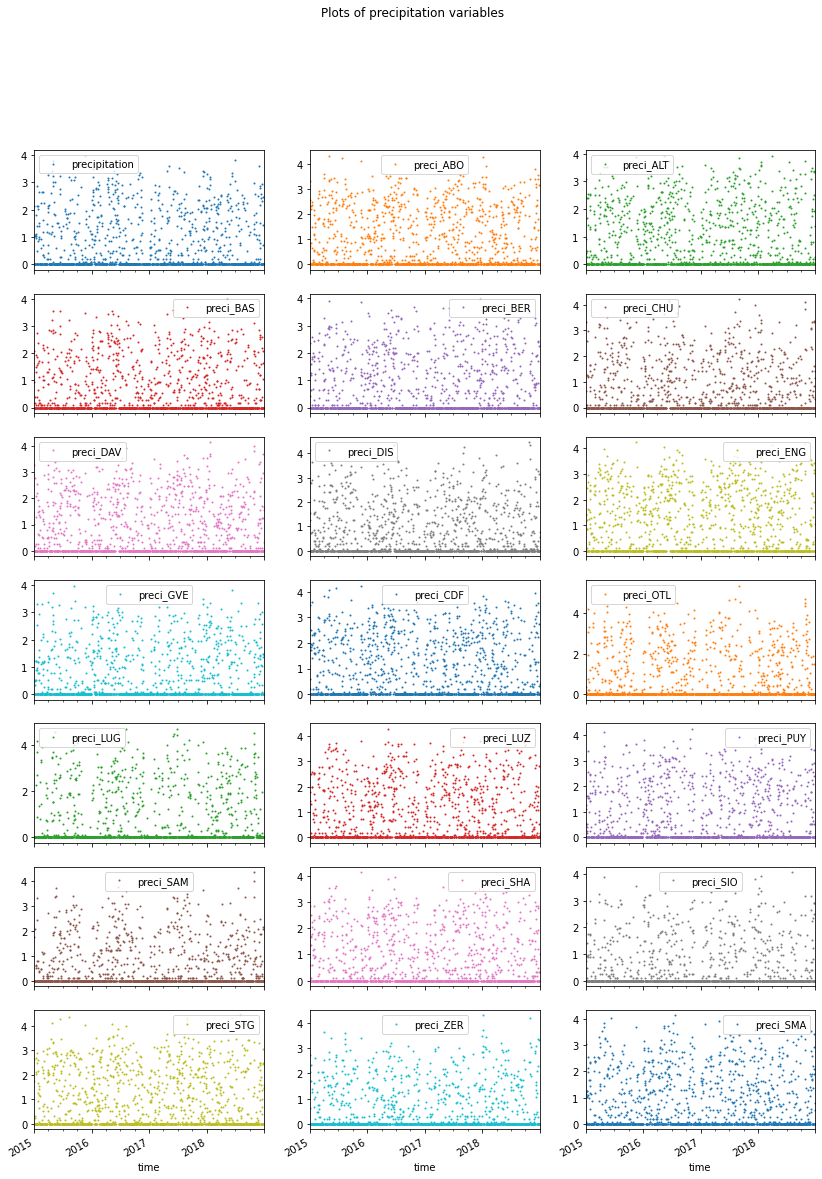

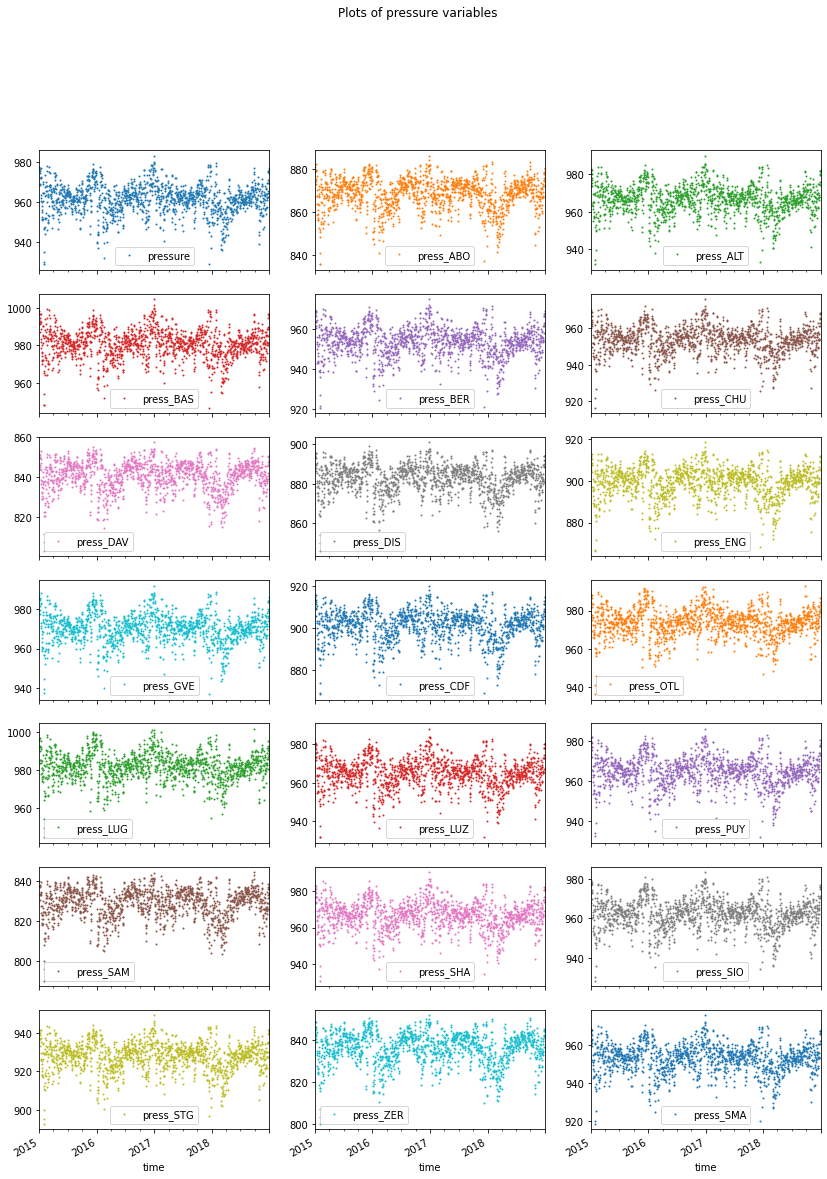

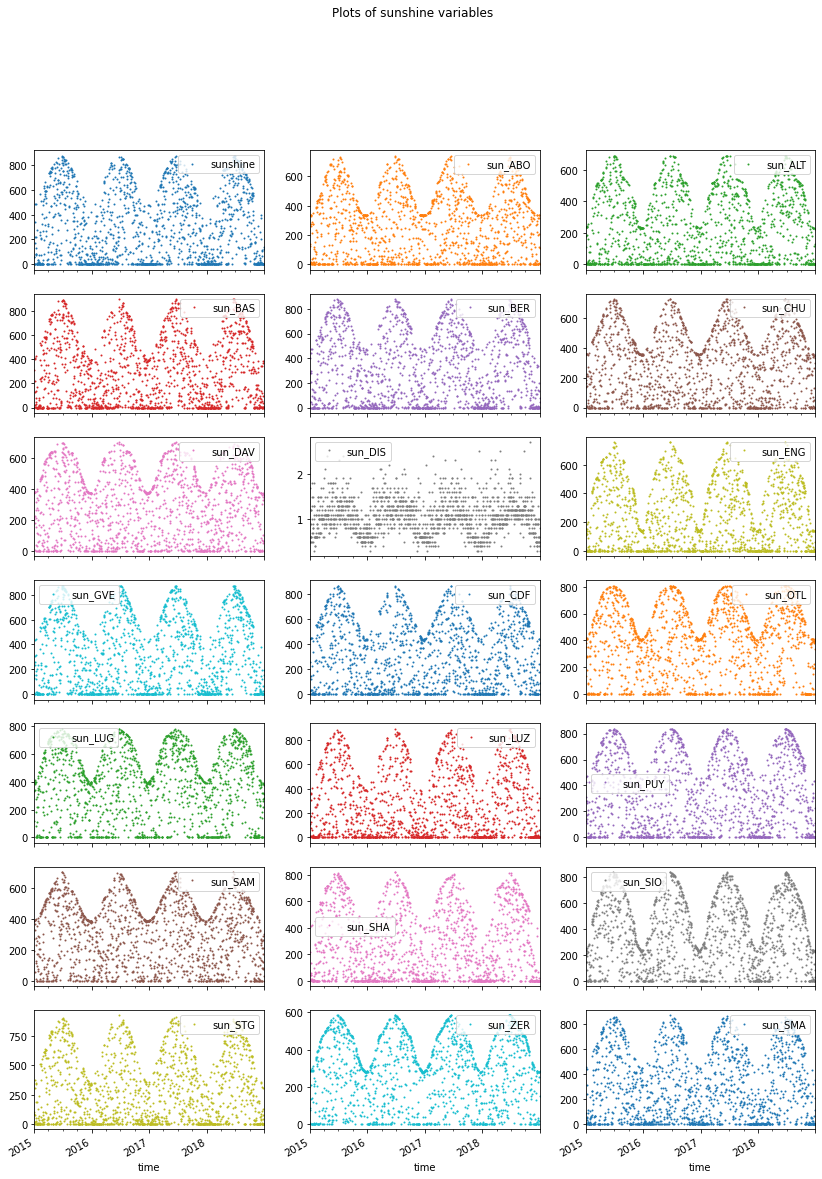

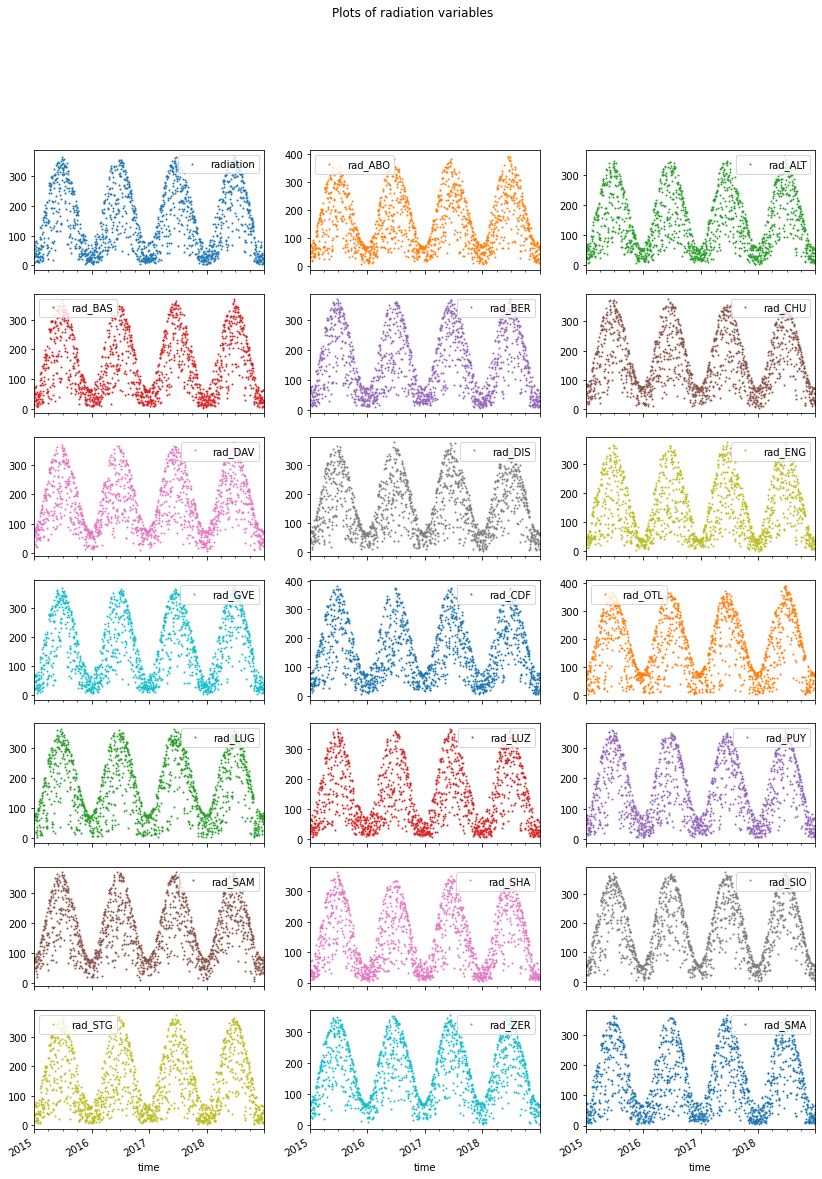

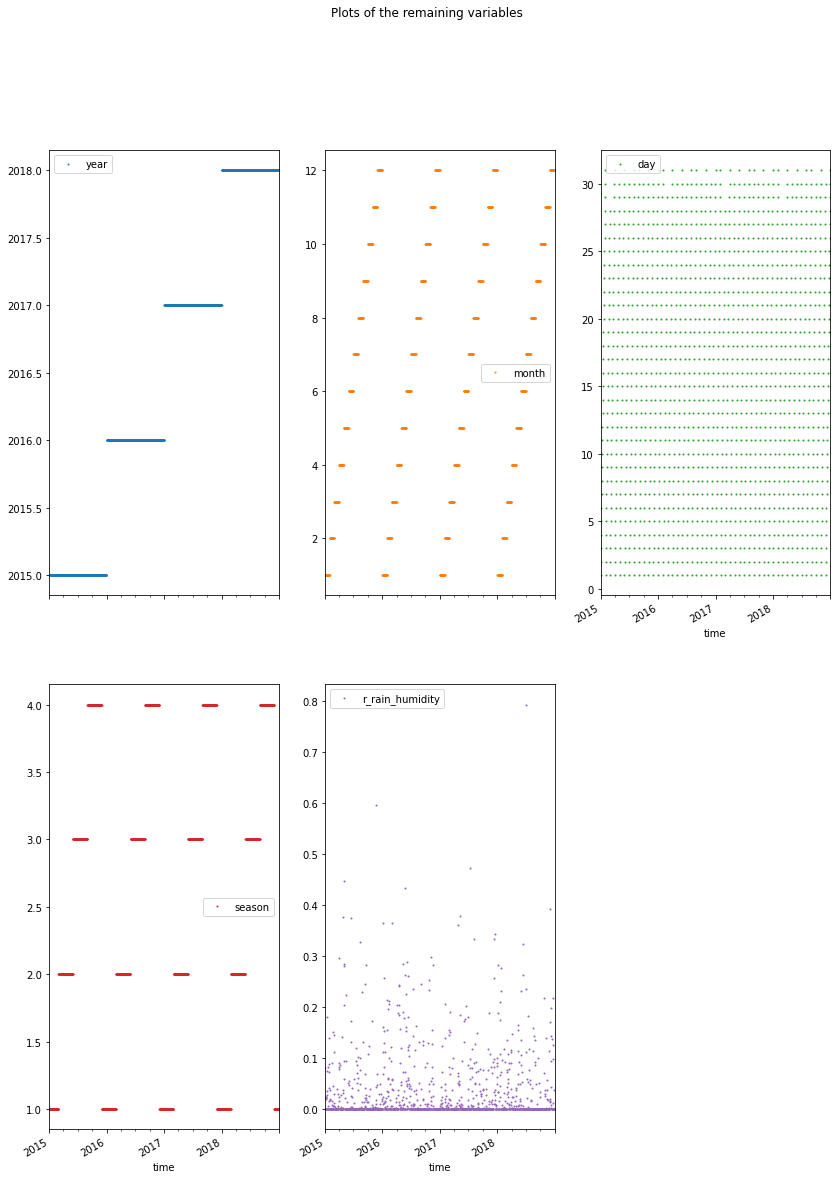

In [88]:
filter_col = [col for col in X_orig_tr if col.startswith('t_')]
X_orig_tr.set_index('time').loc[:, filter_col].plot(lw=0, marker='.', subplots=True, layout=(-1,3), figsize=(14, 20), markersize=2, title='Plots of temperature variables');
diplayed_col = filter_col

for v in var_meas:
    prefix = v[0:3]
    if prefix == 'pre':
        prefix = v[0:4]
    filter_col = [col for col in X_orig_tr if col.startswith(prefix)]
    # plot
    X_orig_tr.set_index('time').loc[:, filter_col].plot(lw=0, marker='.', subplots=True, layout=(-1,3), figsize=(14, 20), markersize=2, 
                                                        title='Plots of '+ v +' variables');
    diplayed_col = diplayed_col + filter_col

filter_col = [col for col in X_orig_tr if col not in diplayed_col]
filter_col.remove('time')
X_orig_tr.set_index('time').loc[:, filter_col].plot(lw=0, marker='.', subplots=True, layout=(-1,3), figsize=(14, 20), markersize=2, title='Plots of the remaining variables');

Seasonality is clearly visible for the original measurements (less pronounced for 'precipitation'). Maybe a one-hot encoding for variable `year` could remove the dependency on the value of the year itself.

Then look at the relationship (i.e. the pearson correlation) between the features with heatmaps.

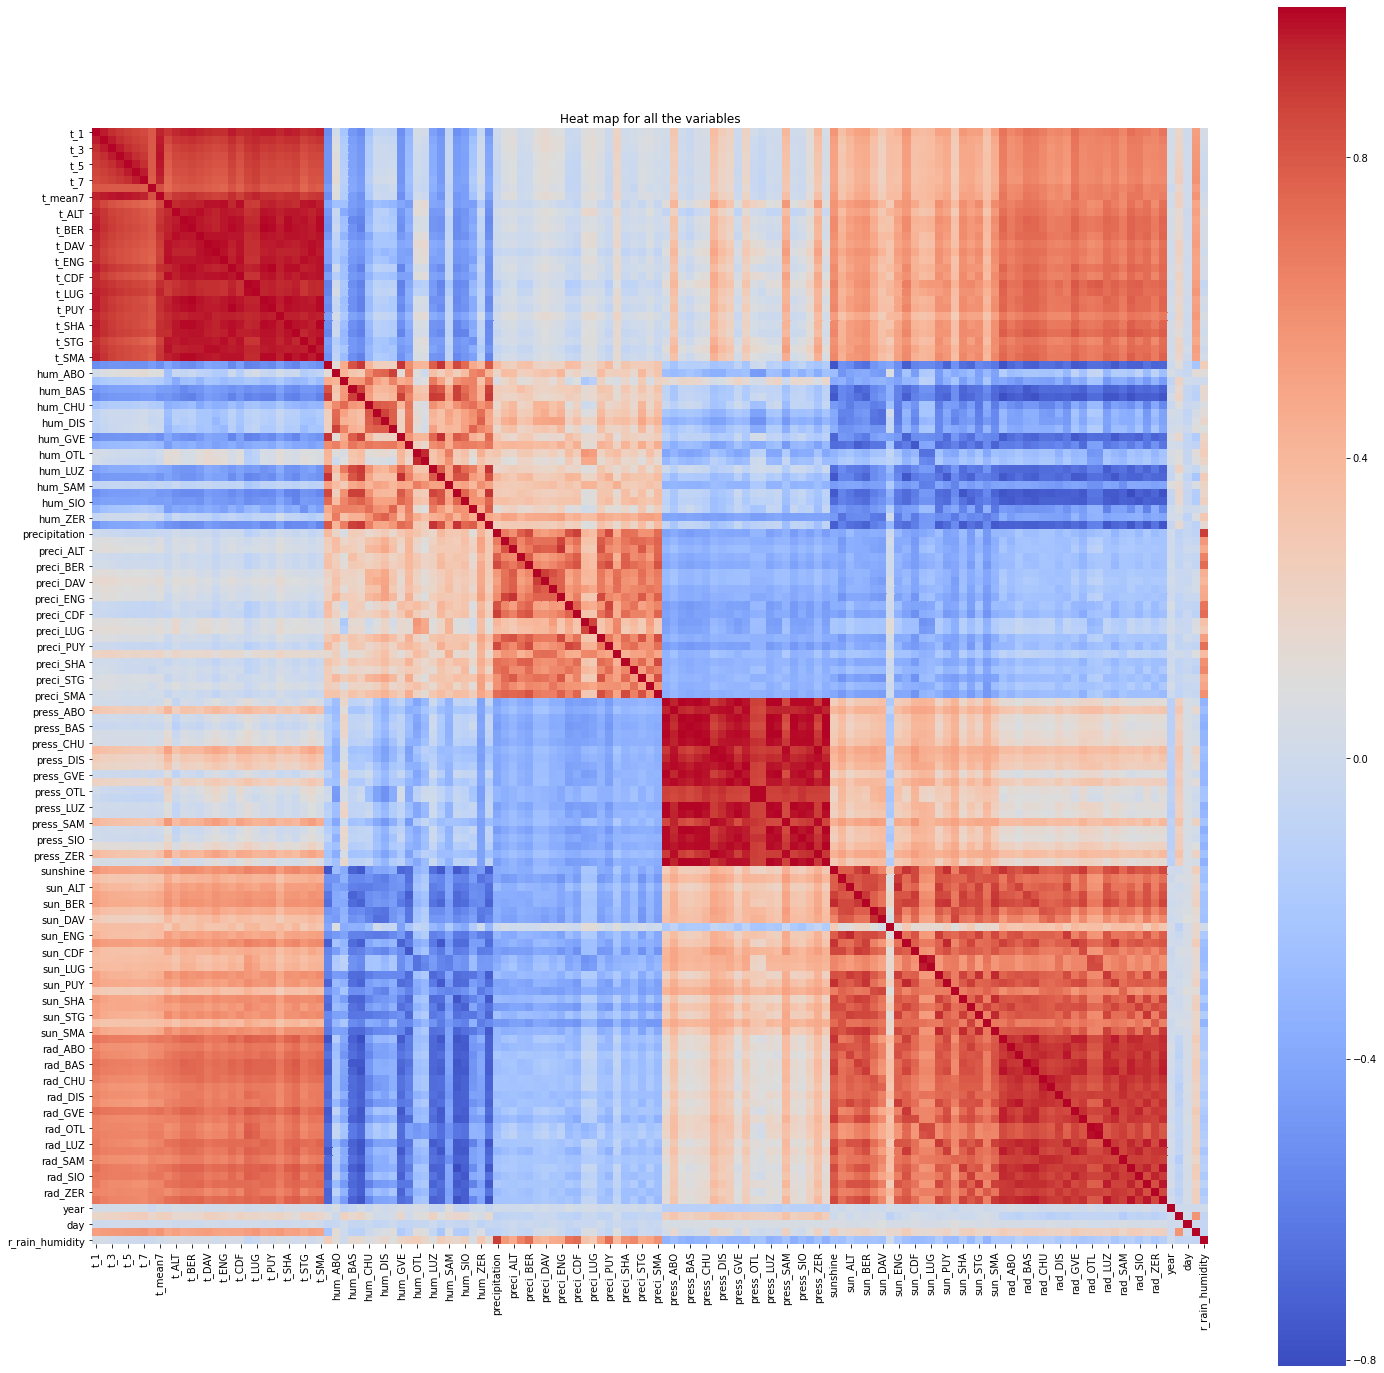

In [89]:
tot_col = diplayed_col + filter_col
plt.figure(figsize=(25, 25))
plt.title('Heat map for all the variables');
sns.heatmap(X_orig_tr.loc[:, tot_col].corr(), square=True, cmap='coolwarm');

Each kind of measurements (e.g. temperatures variables, humidity variables, ...) is clearly visible in the heatmap. Inside a kind of measurements, the correlation is mostly higher in comparison to the other variables. It gives a *partition* in rectangles and highlights *super-square* patterns along the diagonal.

#### **D.3. Complementary discussion**

Data appears to be of good quality after the cleaning process. A log-transform to remove skewnees from the variable 'precipitation' and a seasonal adjustment for the temperature have been performed. The seasonality is also removed from the other measurements in the other notebook.

The Principal Component Analysis show that 5 variables are required to explain more than 90% of the variance. Natural relationship between variables are clearly visible ('sunshine', 'radiation' and 'pressure' associated to high temperatures, 'humidity' and 'precipitation' to low temperatures). Each year is more or less well clustered, which can also be seen in the value of the first coordinate of the second loading vector.

The highest correlated measurements with temperature are sunshine, radiation, humidity and season. They can reasonably be considered to predict temperature. Models based on these variables will be considered, as well as full-variables models to compare with. Other selections (e.g. with the "SelectKBest" module of SciKitLearn, or based on geographically characteristics, ...) will be performed as well.

A word about the baseline : The high correlations between temperature and its lag indicate that the `t_1`-baseline for prediction will be challenging to beat.

#### **D.4. Export cleaned data**

In [90]:
# Save the principal data
X_orig.to_csv('X_orig.txt',index=False)

### E. Machine learning 

The goal of the project is to guess the temperature in Neuchâtel for year 2020 based on the daily measurments of the 24 main stations of the Swiss Meteorogical Network (SwissMetNet) performed during the years 2015 to 2020. To compute these predictions:

- Several models based on various regressors (kNN, Ridge, Lasso, RandomForest) will be compared to baselines;
- Different selections of variables will be considered :
    - the whole set of available variables;   
    - most correlated variables with the temperature in Neuchatel;
    - using SelectKBest;
    - a couple of the nearest geographical stations, but without any weather measurements in Neuchatel;
    - measurements in Neuchâtel only (without any information from the other stations);
    - without temperature variables variants.
    
With all variables, this is the "technical problem" version. On the other hand, the "prediction problem" consisting in guessing the temperature on next day is addressed in the latter by selecting only temperatures lags (and the other features). Lastly, the "new station problem" corresponds to the variables selection without temperature in Neuchatel "without t in NEU".

Finally, the whole notebook can be runned again with adjusted temperature.

#### **E.1. Baselines**

##### **E.2.1 Baseline 1: temperature one year before**

In [91]:
# Validation set
y_te_baseline_y = X_orig_te.loc[(X_orig_te.time>='2019-01-01') & (X_orig_te.time<'2020-01-01'), ['t_y1']]
y_te_baseline_y = y_te_baseline_y.squeeze() # Squeeze 1 dimensional axis objects into scalars.

# Predictions
y_pred_baseline_y = X_to_predict.loc[(X_to_predict.time>='2020-01-01'), ['t_y1']]
y_pred_baseline_y = y_pred_baseline_y.squeeze() # Squeeze 1 dimensional axis objects into scalars.

In [92]:
# Validation set
delta_y_te_baseline_y = y_te - y_te_baseline_y

# Predictions
delta_y_pred_baseline_y = y_to_predict - y_pred_baseline_y

Compute and display model performance for baseline.

In [93]:
# Mean Absolute error (MAE)
def MAE(y, y_pred):    
    return(np.mean(np.abs(y-y_pred)))

# Mean Square error (MSE)
def MSE(y, y_pred):
    return np.mean(np.square(y-y_pred))

# Compute model error
def model_error(y, y_pred):
#    score = MSE(y, y_pred) # MSE version
    score = MAE(y, y_pred) # MAE version
    return score

In [94]:
# Model performance on the Validation set
MAE_te_baseline_y = model_error(y_te, y_te_baseline_y)
print('Baseline 1: Validation set - MAE score: {:.2f} degres'.format(MAE_te_baseline_y))

# Model performance for predictions
MAE_pred_baseline_y = model_error(y_to_predict, y_pred_baseline_y)
print('Baseline 1: Predictions - MAE score: {:.2f} degres'.format(MAE_pred_baseline_y))

Baseline 1: Validation set - MAE score: 3.71 degres
Baseline 1: Predictions - MAE score: 3.46 degres


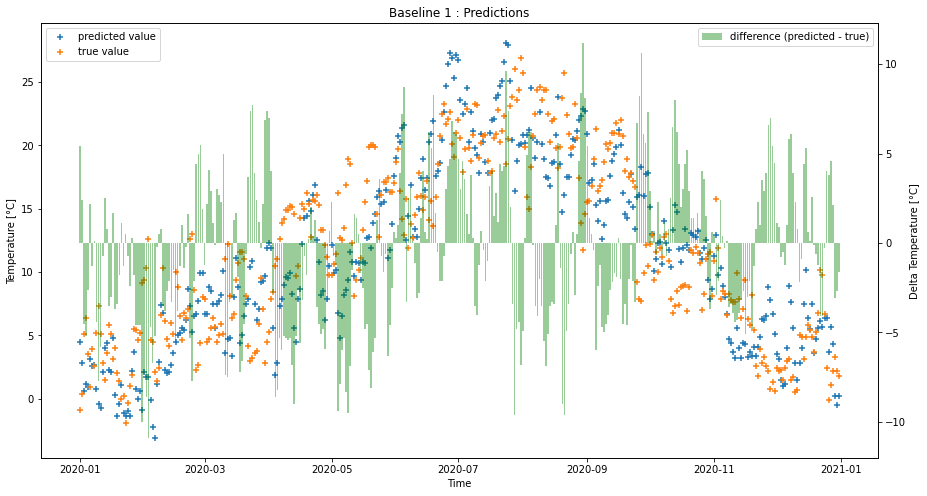

In [95]:
# Bar plot
fig, ax1 = plt.subplots(figsize=(15,8))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax1.scatter(time_to_predict, y_pred_baseline_y, marker='+', label='predicted value')
ax1.scatter(time_to_predict, y_to_predict, marker='+', label='true value')
ax2.bar(time_to_predict, y_pred_baseline_y - y_to_predict, label='difference (predicted - true)', color='green', alpha=.4)

plt.title('Baseline 1 : Predictions')
ax1.set_xlabel('Time')
ax1.set_ylabel('Temperature [°C]')
ax2.set_ylabel('Delta Temperature [°C]')
ax1.legend(loc=2) # legend for y values upper left
ax2.legend(loc=1) # legend for difference upper right
plt.show()    

##### **E.2.2 Baseline 2: temperature one day before**

In [96]:
# Validation set
y_te_baseline_1 = X_orig_te.loc[(X_orig_te.time>='2019-01-01') & (X_orig_te.time<'2020-01-01'), ['t_1']]
y_te_baseline_1 = y_te_baseline_1.squeeze() # Squeeze 1 dimensional axis objects into scalars.

# Predictions
y_pred_baseline_1 = X_to_predict.loc[(X_to_predict.time>='2020-01-01'), ['t_1']]
y_pred_baseline_1 = y_pred_baseline_1.squeeze() # Squeeze 1 dimensional axis objects into scalars.

In [97]:
# Validation set
delta_y_te_baseline_1 = y_te - y_te_baseline_1

# Predictions
delta_y_pred_baseline_1 = y_to_predict - y_pred_baseline_1

Compute and display model performance for baseline.

In [98]:
# Model performance on the Validation set
MAE_te_baseline_1 = model_error(y_te, y_te_baseline_1)
print('Baseline 2: Validation set - MAE score: {:.2f} degres'.format(MAE_te_baseline_1))

# Model performance for predictions
MAE_pred_baseline_1 = model_error(y_to_predict, y_pred_baseline_1)
print('Baseline 2: Predictions - MAE score: {:.2f} degres'.format(MAE_pred_baseline_1))

Baseline 2: Validation set - MAE score: 1.55 degres
Baseline 2: Predictions - MAE score: 1.68 degres


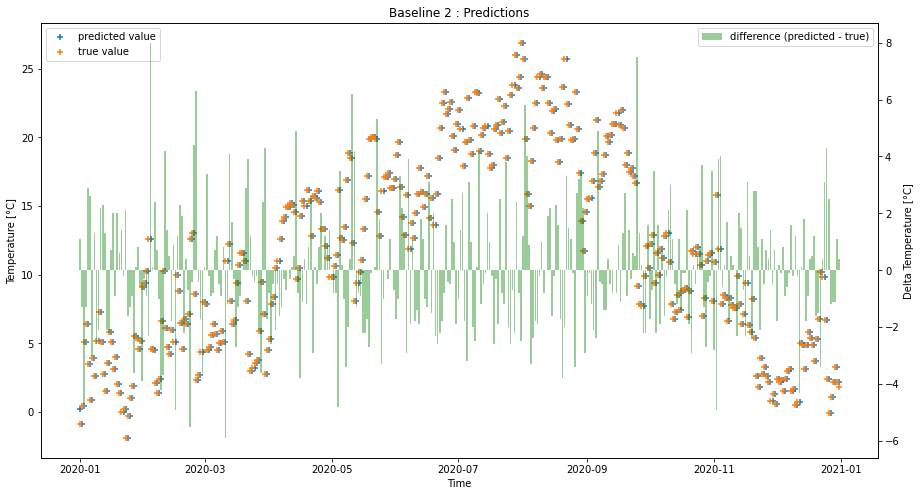

In [99]:
# Bar plot
fig, ax1 = plt.subplots(figsize=(15,8))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax1.scatter(time_to_predict, y_pred_baseline_1, marker='+', label='predicted value')
ax1.scatter(time_to_predict, y_to_predict, marker='+', label='true value')
ax2.bar(time_to_predict, y_pred_baseline_1 - y_to_predict, label='difference (predicted - true)', color='green', alpha=.4)

plt.title('Baseline 2 : Predictions')
ax1.set_xlabel('Time')
ax1.set_ylabel('Temperature [°C]')
ax2.set_ylabel('Delta Temperature [°C]')
ax1.legend(loc=2) # legend for y values upper left
ax2.legend(loc=1) # legend for difference upper right
plt.show()    

#### **E.2. Regressors**

First, let's encode the time with LabelEncoder (to avoid technical issues) and modify dtype for variables of type `int` to `float` to avoid warnings with Standardscaler below.

In [100]:
# Encode target variable Temperature as int (for use in k-NN and LogReg)
from sklearn import preprocessing
from sklearn import utils

# Encode the time variable
lab_enc = preprocessing.LabelEncoder()
X_orig_tr_enc_tmp = X_orig_tr.copy()
X_orig_te_enc_tmp = X_orig_te.copy()
X_to_predict_enc_tmp = X_to_predict.copy()
X_orig_tr_enc_tmp.loc[:, 'time'] = lab_enc.fit_transform(X_orig_tr.time) # Timestamp not allowed in knn-Regressor.
X_orig_te_enc_tmp.loc[:, 'time'] = lab_enc.fit_transform(X_orig_te.time)
X_to_predict_enc_tmp.loc[:, 'time'] = lab_enc.fit_transform(X_to_predict.time)

# Convert from int to float the integer variables 
col_int_to_float = X_orig_tr_enc_tmp.columns[(X_orig_tr_enc_tmp.dtypes=='int64').values].values # columns of type int
X_orig_tr_enc = X_orig_tr_enc_tmp.copy()
X_orig_tr_enc[col_int_to_float] = X_orig_tr_enc[col_int_to_float].astype(float, copy=False) # int -> float
X_orig_te_enc = X_orig_te_enc_tmp.copy()
X_orig_te_enc[col_int_to_float] = X_orig_te_enc[col_int_to_float].astype(float, copy=False) # int -> float
X_to_predict_enc = X_to_predict_enc_tmp.copy()
X_to_predict_enc[col_int_to_float] = X_to_predict_enc[col_int_to_float].astype(float, copy=False) # int -> float
print('Variables encoded from int to float :', col_int_to_float)

Variables encoded from int to float : ['time' 'year' 'month' 'day']


In order to replicate the various Machine Learning modelization's process (standardize, fit and transform, predict, get results and plots) for each model, let's define two functions and a class object to get the results of the modelization.

In [101]:
class ML_modelize_class():
    
    def __init__(self, scaler, estimator, df_res, df_best_res, best_estim, y_te_pred, delta_y_te): 
        self.scaler = scaler              # scaler
        self.estimator = estimator        # estimator 
        self.df_res = df_res              # result of the grid search in a DF
        self.df_best_res = df_best_res    # best result from df_res
        self.best_estim = best_estim      # best estimator
        self.y_te_pred = y_te_pred        # predicted target of the validation set
        self.delta_y_te = delta_y_te      # y_te_pred - y_te        

In [102]:
def ML_modelize(scaler, estimator, df_tr, df_te, y_tr, y_te, gs_param, gs_range, **kwargs):
    # function to fit, transform and perform a grid search
    
    # scaler    : name of the scaler
    # estimator : name of the estimator
    # df_tr     : dataframe of the training set
    # df_te     : dataframe of the validation set
    # y_tr      : target of the training set
    # y_te      : target of the validation set
    # gs_param  : parameter of the grid_search
    # gs_range  : range of the values for the grid_search
    # **kwargs  : optionnal paremeter-value pairs to set for the estimator/regressor
    
    # Create pipeline
    pipe = Pipeline([
        ('scaler', scaler),
        ('estimator', estimator)
    ])
    
    # set parameters passed in kwargs through a dictionary
    for key, value in kwargs.items():
        param = {'estimator__'+key: value} # create dict to set parameters passed in **kwargs
        pipe.set_params(**param)
    
    # Variable to store the results
    gs_results = []

    # Grid search
    for gsp in gs_range:
        # Set hyperparameter
        gsparam = {'estimator__'+gs_param: gsp}
        pipe.set_params(**gsparam)

        # Fit the estimator
        pipe.fit(df_tr, y_tr)

        # Save model and its performance on train/validation sets
        gs_results.append({
            'gs_param': gsp,
            'train_mse': MSE(y_tr, pipe.predict(df_tr)),
            'train_mae': MAE(y_tr, pipe.predict(df_tr)),
            'test_mse': MSE(y_te, pipe.predict(df_te)),
            'test_mae': MAE(y_te, pipe.predict(df_te)),
        })

    # Convert results to DataFrame
    gs_results = pd.DataFrame(gs_results)
    
    
    # Get entry with the best validation MAE
    best_result = gs_results.loc[gs_results.test_mae.idxmin()]

    # Model performance
    best_gsp = best_result.gs_param
    best_MAE_te = best_result.test_mae
    print('{}-regressor: Validation set - MAE score: {:.2f} degrees'.format(estimator.__class__.__name__, best_MAE_te))
    
    
    # Model predictions with best hyperparameter
    if abs(best_gsp-int(best_gsp)) < 1e-10:
        # integer parameter
        bgsp = {'estimator__'+gs_param: int(best_gsp)}
    else:
        # non-integer parameter
        bgsp = {'estimator__'+gs_param: best_gsp}
    pipe.set_params(**bgsp)
    pipe.fit(df_tr, y_tr)
    y_te_pred = pipe.predict(df_te)
    delta_y_te = y_te_pred - y_te
    best_estim = pipe
    
    return ML_modelize_class(scaler, estimator, gs_results, best_result, best_estim, y_te_pred, delta_y_te)

In [103]:
def ML_plot_predictions(time, y_true, y_pred, regr_name):
        
    # Bar plot
    fig, ax1 = plt.subplots(figsize=(15,8))
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    ax1.scatter(time, y_pred, marker='+', label='predicted value')
    ax1.scatter(time, y_true, marker='+', label='true value')
    ax2.bar(time, y_pred - y_true, label='difference (predicted - true)', color='green', alpha=.4)

    plt.title('{} : Predictions'.format(regr_name))
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Temperature [°C]')
    ax2.set_ylabel('Delta Temperature [°C]')
    ax1.legend(loc=2) # legend for y values upper left
    ax2.legend(loc=1) # legend for difference upper right
    plt.show()
    
    return

In [104]:
def ML_plot_val_curves(ML_modelize_class_inst, regr_name, regr_param, log_scale=0):
    # Plot the validation curves
    plt.figure(figsize=(15,5)) # Size of the figure
    
    if log_scale == 0:
        plt.plot(ML_modelize_class_inst.df_res['gs_param'], ML_modelize_class_inst.df_res['train_mae'], label='train curve')
        plt.plot(ML_modelize_class_inst.df_res['gs_param'], ML_modelize_class_inst.df_res['test_mae'], label='validation curve')
        plt.scatter(ML_modelize_class_inst.df_best_res.gs_param, ML_modelize_class_inst.df_best_res.test_mae, marker='x', c='red', zorder=10) # Mark best gs_param value
    else:
        plt.plot(np.log10(ML_modelize_class_inst.df_res['gs_param']), ML_modelize_class_inst.df_res['train_mae'], label='train curve')
        plt.plot(np.log10(ML_modelize_class_inst.df_res['gs_param']), ML_modelize_class_inst.df_res['test_mae'], label='validation curve')
        plt.scatter(np.log10(ML_modelize_class_inst.df_best_res.gs_param), ML_modelize_class_inst.df_best_res.test_mae, marker='x', c='red', zorder=10) # Mark best gs_param value
    

    plt.title('{} : Best {}: {:.3f} - mae: {:,.3f} degrees'.format(regr_name, regr_param, ML_modelize_class_inst.df_best_res.gs_param, ML_modelize_class_inst.df_best_res.test_mae))
    if log_scale == 0:
        plt.xlabel(regr_param)
    else:
        plt.xlabel('$log_{10}$('+regr_param+')')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()
    
    return

##### **E.2.1 kNN-Regression**

As suggested in [Unit 04.02.05](https://learn.extensionschool.ch/learn/programs/applied-data-science-machine-learning-v2/subjects/k-nearest-neighbors-v2/units/standardization-and-k-nn-v2) *Standardization and k-NN*, kNN-Regression leads to better results when applied to standardized data, so we apply the `StandardScaler()` in the preprocessing step.

In [105]:
# k-NN
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline

KNeighborsRegressor-regressor: Validation set - MAE score: 1.30 degrees


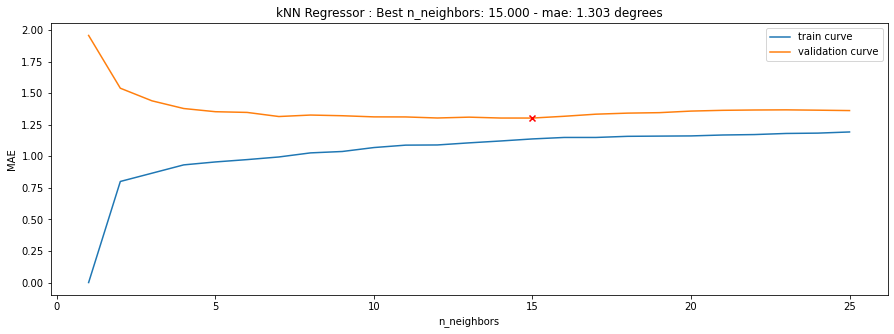

knn-regressor: Validation set - MAE score: 1.30 degres


In [106]:
gs_results_knn = ML_modelize(StandardScaler(), # scaler
                             KNeighborsRegressor(), # knn estimator
                             X_orig_tr_enc, # dataframe of the training set
                             X_orig_te_enc, # dataframe of the validation set
                             y_tr, # target of the training set
                             y_te, # target of the validation set
                             'n_neighbors', # parameter of the grid_search
                             1+np.arange(25), # parameter range
                             algorithm='brute') # additional arguments to the estimator

ML_plot_val_curves(gs_results_knn, 'kNN Regressor', 'n_neighbors')

# Model performance on the validation set
MAE_te_knn = gs_results_knn.df_best_res.test_mae
print('knn-regressor: Validation set - MAE score: {:.2f} degres'.format(MAE_te_knn))

Let's perform the predictions for year 2020 with the best hyperparemeter defined on the validation set.

kNN-regressor: MAE score for predictions: 1.21 degrees


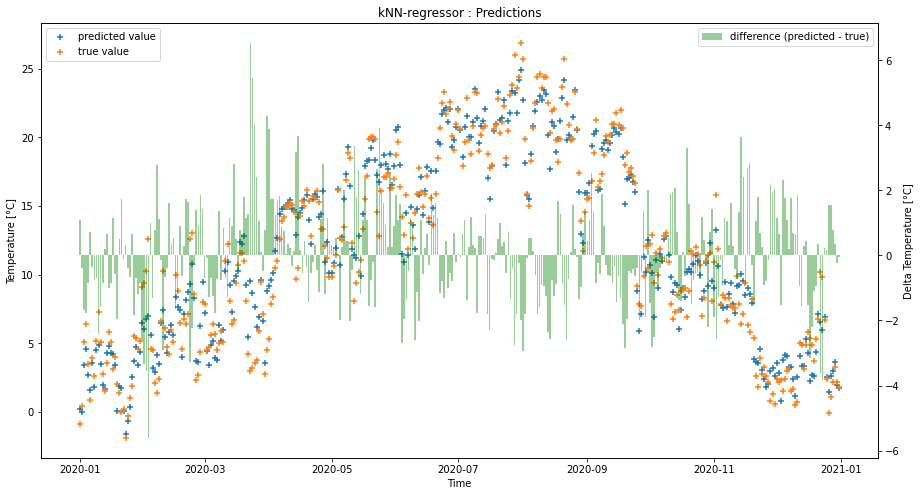

In [107]:
# Predictions from the model
y_pred_knn = gs_results_knn.best_estim.predict(X_to_predict_enc)

# Predictions score (Model performance for the predictions)
MAE_pred_knn = model_error(y_to_predict, y_pred_knn)
print('kNN-regressor: MAE score for predictions: {:.2f} degrees'.format(MAE_pred_knn))

# Plot of the predictions
ML_plot_predictions(time_to_predict, y_to_predict, y_pred_knn, 'kNN-regressor')

##### **E.2.2 Ridge-Regression**

In [108]:
from sklearn.linear_model import Ridge

C:\Users\muriel\.conda\envs\exts-ml\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=2.1464e-20): result may not be accurate.
  overwrite_a=True).T
C:\Users\muriel\.conda\envs\exts-ml\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.54632e-20): result may not be accurate.
  overwrite_a=True).T
C:\Users\muriel\.conda\envs\exts-ml\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.42094e-20): result may not be accurate.
  overwrite_a=True).T
C:\Users\muriel\.conda\envs\exts-ml\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=9.26069e-20): result may not be accurate.
  overwrite_a=True).T
C:\Users\muriel\.conda\envs\exts-ml\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.44172e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\mu

Ridge-regressor: Validation set - MAE score: 0.26 degrees


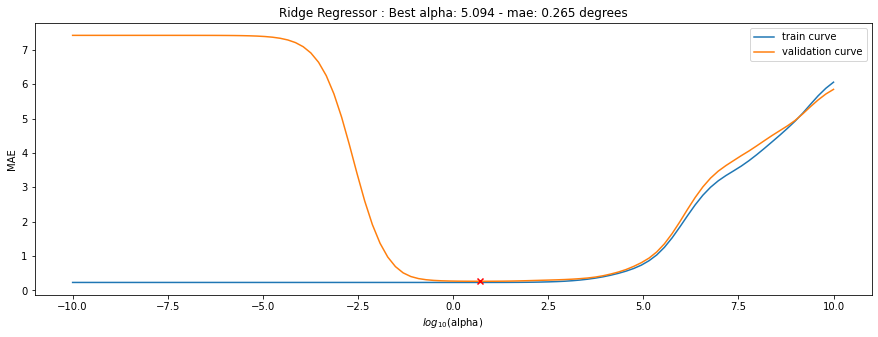

Ridge-regressor: Validation set - MAE score: 0.26 degres


In [109]:
# Without preprocessed standardization
gs_results_ridge = ML_modelize(None, Ridge(), X_orig_tr_enc, X_orig_te_enc, y_tr, y_te, 'alpha', np.logspace(-10, 10, num=100))
ML_plot_val_curves(gs_results_ridge, 'Ridge Regressor', 'alpha', log_scale=1)
# Model performance
MAE_te_ridge = gs_results_ridge.df_best_res.test_mae
print('Ridge-regressor: Validation set - MAE score: {:.2f} degres'.format(MAE_te_ridge))

To avoid working with ill-conditioned matrices, let's standarize the data first.

Ridge-regressor: Validation set - MAE score: 0.24 degrees


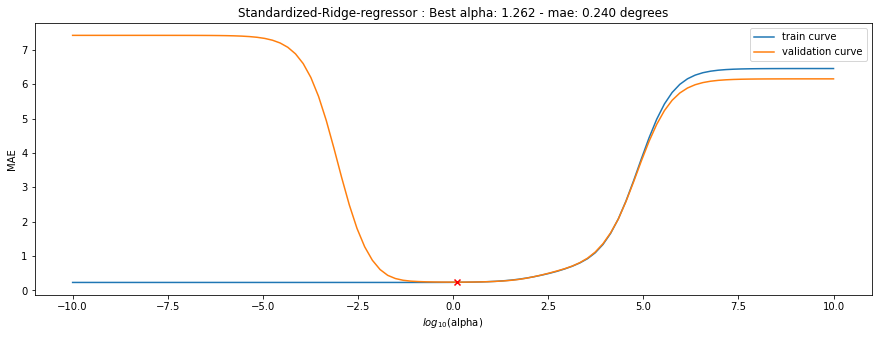

Standardized-Ridge-regressor: Validation set - MAE score: 0.24 degres


In [110]:
# With preprocessed standardization
gs_results_ridge_std = ML_modelize(StandardScaler(), Ridge(), X_orig_tr_enc, X_orig_te_enc, y_tr, y_te, 'alpha', np.logspace(-10, 10, num=100))
ML_plot_val_curves(gs_results_ridge_std, 'Standardized-Ridge-regressor', 'alpha', log_scale=1)
# Model performance
MAE_te_ridge_std = gs_results_ridge_std.df_best_res.test_mae
print('Standardized-Ridge-regressor: Validation set - MAE score: {:.2f} degres'.format(MAE_te_ridge_std))

Note that the best validation score is just slightly improved with the standardization performed in the preprocessing. Another remark is that the validation curves are even more smooth with regularization.

In [111]:
# save the best hyperparameter
best_alpha_ridge_std = gs_results_ridge_std.df_best_res.gs_param
print('Hyperparameter of the best model : alpha = {:.3f}'.format(best_alpha_ridge_std))

Hyperparameter of the best model : alpha = 1.262


Let's plot the prediction with the model optimized on the standardized data.

Standardized-Ridge-regressor: MAE score for predictions: 0.28 degrees


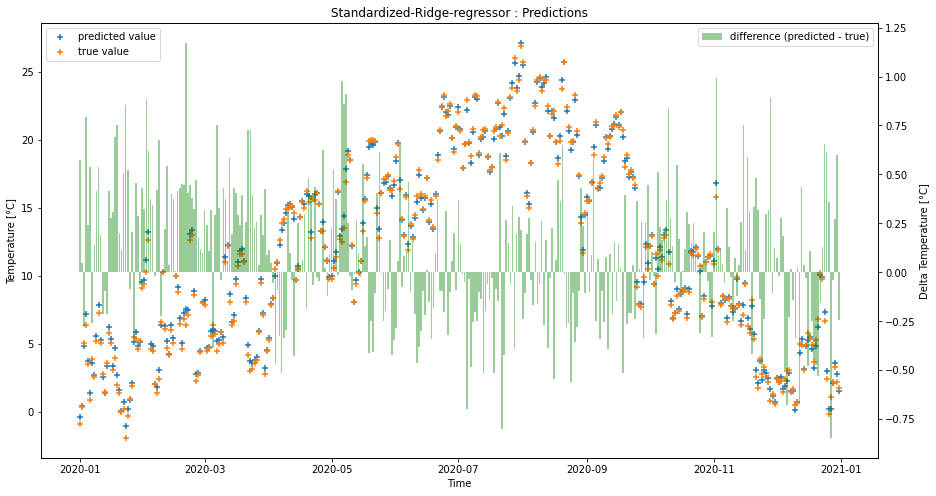

In [112]:
# Predictions from the model
y_pred_ridge_std = gs_results_ridge_std.best_estim.predict(X_to_predict_enc)

# Predictions score (Model performance for the predictions)
MAE_pred_ridge_std = model_error(y_to_predict, y_pred_ridge_std)
print('Standardized-Ridge-regressor: MAE score for predictions: {:.2f} degrees'.format(MAE_pred_ridge_std))

# Plot of the predictions
ML_plot_predictions(time_to_predict, y_to_predict, y_pred_ridge_std, 'Standardized-Ridge-regressor')

##### **E.2.3 Lasso-Regression**

In [113]:
from sklearn.linear_model import Lasso

First, without standardization in the preprocessing.

C:\Users\muriel\.conda\envs\exts-ml\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso-regressor: Validation set - MAE score: 0.26 degrees


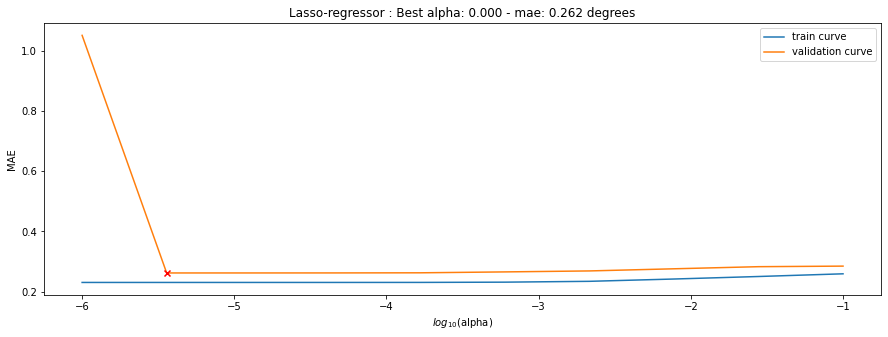

Lasso-regressor: Validation set - MAE score: 0.26 degres


In [114]:
gs_results_lasso = ML_modelize(None, Lasso(), X_orig_tr_enc, X_orig_te_enc, y_tr, y_te, 'alpha', np.logspace(-6,-1, num=10), max_iter=2e5)
ML_plot_val_curves(gs_results_lasso, 'Lasso-regressor', 'alpha', log_scale=1)
# Model performance
MAE_te_lasso = gs_results_lasso.df_best_res.test_mae
print('Lasso-regressor: Validation set - MAE score: {:.2f} degres'.format(MAE_te_lasso))

Let's refine around the best value of the hyperparameter found to get more accurate results.

C:\Users\muriel\.conda\envs\exts-ml\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\muriel\.conda\envs\exts-ml\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso-regressor: Validation set - MAE score: 0.26 degrees


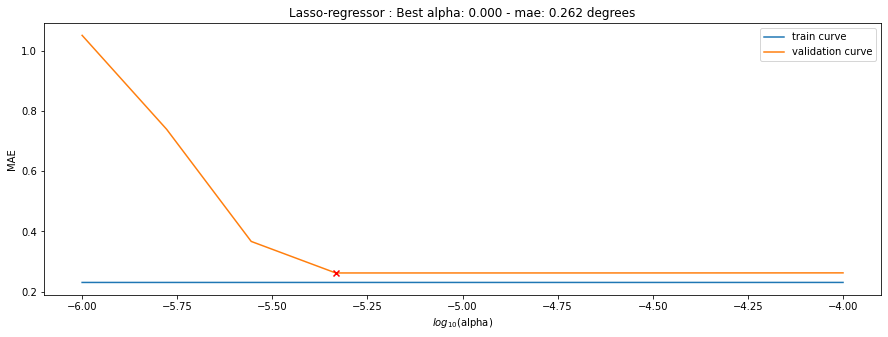

Lasso-regressor: Validation set - MAE score: 0.26 degres


In [115]:
gs_results_lasso = ML_modelize(None, Lasso(), X_orig_tr_enc, X_orig_te_enc, y_tr, y_te, 'alpha', np.logspace(-6, -4, num=10), max_iter=2e5)
ML_plot_val_curves(gs_results_lasso, 'Lasso-regressor', 'alpha', log_scale=1)
# Model performance
MAE_te_lasso = gs_results_lasso.df_best_res.test_mae
print('Lasso-regressor: Validation set - MAE score: {:.2f} degres'.format(MAE_te_lasso))

Then, with standardization in the preprocessing.

Lasso-regressor: Validation set - MAE score: 0.24 degrees


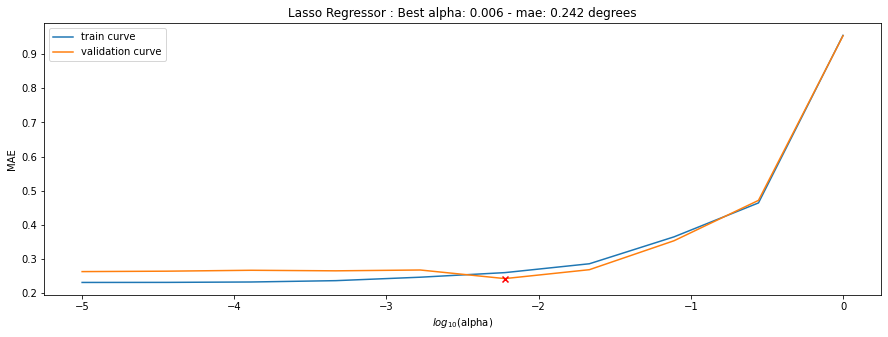

Standardized-Lasso-regressor: Validation set - MAE score: 0.24 degres


In [116]:
gs_results_lasso_std = ML_modelize(StandardScaler(), Lasso(), X_orig_tr_enc, X_orig_te_enc, y_tr, y_te, 'alpha', np.logspace(-5, 0, num=10), max_iter=2e5)
ML_plot_val_curves(gs_results_lasso_std, 'Lasso Regressor', 'alpha', log_scale=1)
# Model performance
MAE_te_lasso_std = gs_results_lasso_std.df_best_res.test_mae
print('Standardized-Lasso-regressor: Validation set - MAE score: {:.2f} degres'.format(MAE_te_lasso_std))

The best validation score is slightly improved with the standardization performed in the preprocessing. Let's plot the prediction with the model optimized on the standardized data.

Standardized-Lasso-regressor: MAE score for predictions: 0.28 degrees


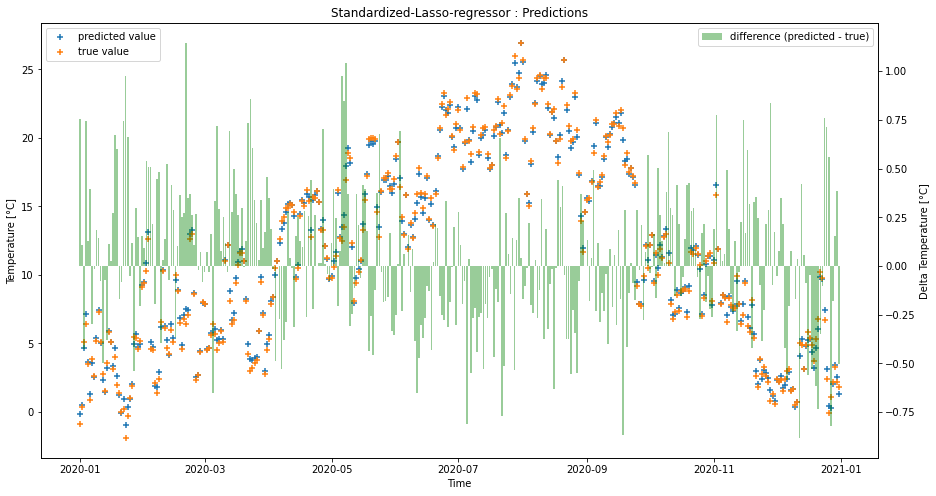

In [117]:
# Predictions from the model
y_pred_lasso_std = gs_results_lasso_std.best_estim.predict(X_to_predict_enc)

# Predictions score (Model performance for the predictions)
MAE_pred_lasso_std = model_error(y_to_predict, y_pred_lasso_std)
print('Standardized-Lasso-regressor: MAE score for predictions: {:.2f} degrees'.format(MAE_pred_lasso_std))

# Plot of the predictions
ML_plot_predictions(time_to_predict, y_to_predict, y_pred_lasso_std, 'Standardized-Lasso-regressor')

##### **E.2.4 RandomForest-Regression**

In [118]:
from sklearn.ensemble import RandomForestRegressor

RandomForestRegressor-regressor: Validation set - MAE score: 0.44 degrees


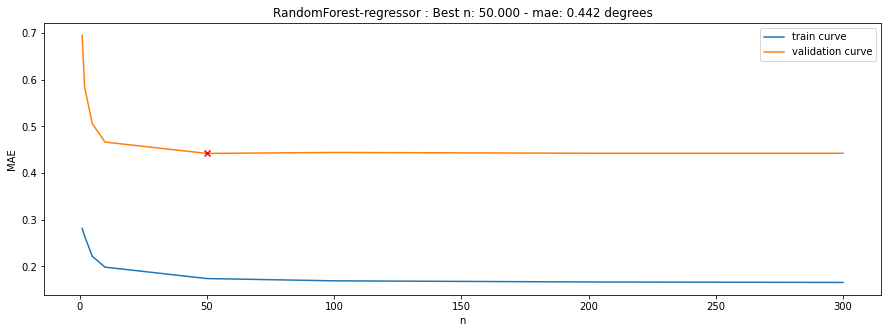

In [119]:
gs_rf_range = [1, 2, 5, 10, 50, 100, 200, 300]
gs_results_rf = ML_modelize(None, RandomForestRegressor(), X_orig_tr_enc, X_orig_te_enc, y_tr, y_te, 'n_estimators', gs_rf_range, random_state=0)
ML_plot_val_curves(gs_results_rf, 'RandomForest-regressor', 'n')

In [120]:
# Displays the score in function of the parameter value
gs_results_rf.df_res

gs_param  test_mae  test_mse  train_mae  train_mse
0         1  0.695068  0.848411   0.281520   0.339624
1         2  0.583562  0.571685   0.264648   0.203092
2         5  0.505753  0.433030   0.221520   0.099624
3        10  0.466411  0.369083   0.198515   0.072985
4        50  0.442104  0.331384   0.173995   0.052696
5       100  0.444186  0.336874   0.169146   0.049361
6       200  0.442464  0.332583   0.166671   0.046902
7       300  0.442450  0.332930   0.165676   0.046389

The model reaching the best score contains 50 trees. It is overfitting (low bias but high variance). A plateau seems to appears from around 50 trees. Let's refine the grid search around this number of estimators.

RandomForestRegressor-regressor: Validation set - MAE score: 0.44 degrees


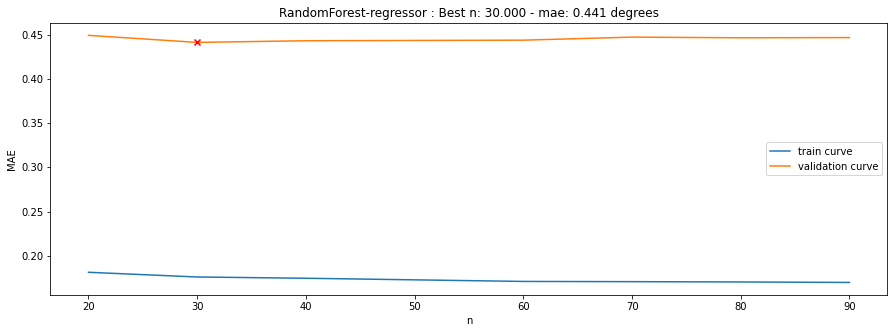

In [121]:
gs_rf_range2 = [20, 30, 40, 60, 70, 80, 90]
gs_results_rf2 = ML_modelize(None, RandomForestRegressor(), X_orig_tr_enc, X_orig_te_enc, y_tr, y_te, 'n_estimators', gs_rf_range2, random_state=0)
ML_plot_val_curves(gs_results_rf2, 'RandomForest-regressor', 'n')

In [122]:
# Displays the score in function of the parameter value
gs_results_rf2.df_res

gs_param  test_mae  test_mse  train_mae  train_mse
0        20  0.449041  0.345951   0.181424   0.059179
1        30  0.441087  0.332449   0.176101   0.053940
2        40  0.442966  0.333707   0.174670   0.053092
3        60  0.443607  0.334767   0.171078   0.050429
4        70  0.447049  0.339150   0.170821   0.050530
5        80  0.446301  0.337548   0.170482   0.050180
6        90  0.446527  0.337907   0.169934   0.049984

The score of the model with 70 trees (0.447) is the best found. To avoid a too complex model that is overfitting, let's set the number of estimators to 70 before searching for the depth of the trees.

Number of estimators : 70
RandomForestRegressor-regressor: Validation set - MAE score: 0.44 degrees


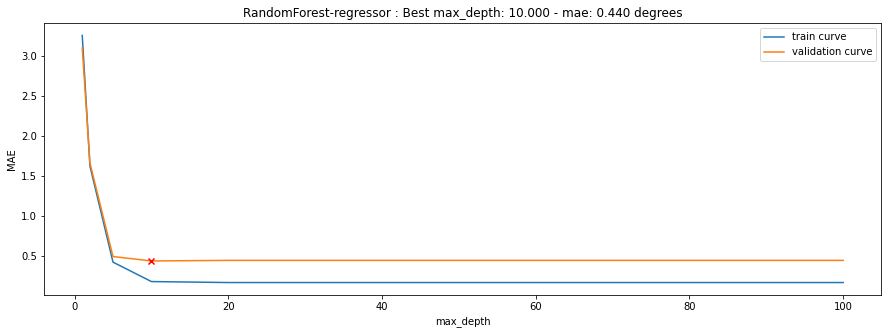

In [123]:
# best_rf_n = int(gs_results_rf2.df_best_res.gs_param)
best_rf_n = 70
print('Number of estimators :', best_rf_n)
gs_results_rf_depth = ML_modelize(None, RandomForestRegressor(), X_orig_tr_enc, X_orig_te_enc, y_tr, y_te, 'max_depth', [1, 2, 5, 10, 20, 50, 100], n_estimators=best_rf_n, random_state=0)
ML_plot_val_curves(gs_results_rf_depth, 'RandomForest-regressor', 'max_depth')

The best score with the default depth (`max_depth=None`, meanning nodes are expanded until all leaves are pure or contain less than 2 samples) is similar. For the final comparison, let's set the number of trees to 70 and the maximal depth to 10.

In [124]:
best_rf_d = 10
gs_results_rf_ok = ML_modelize(None, RandomForestRegressor(), X_orig_tr_enc, X_orig_te_enc, y_tr, y_te, 'n_estimators', [best_rf_n], max_depth=best_rf_d, random_state=0)
# Model performance
MAE_te_rf = gs_results_rf_ok.df_best_res.test_mae
print('RandomForest-regressor : Validation set - MAE score: {:.2f} degres'.format(MAE_te_rf))

RandomForestRegressor-regressor: Validation set - MAE score: 0.44 degrees
RandomForest-regressor : Validation set - MAE score: 0.44 degres


RandomForest-regressor: MAE score for predictions: 0.46 degrees


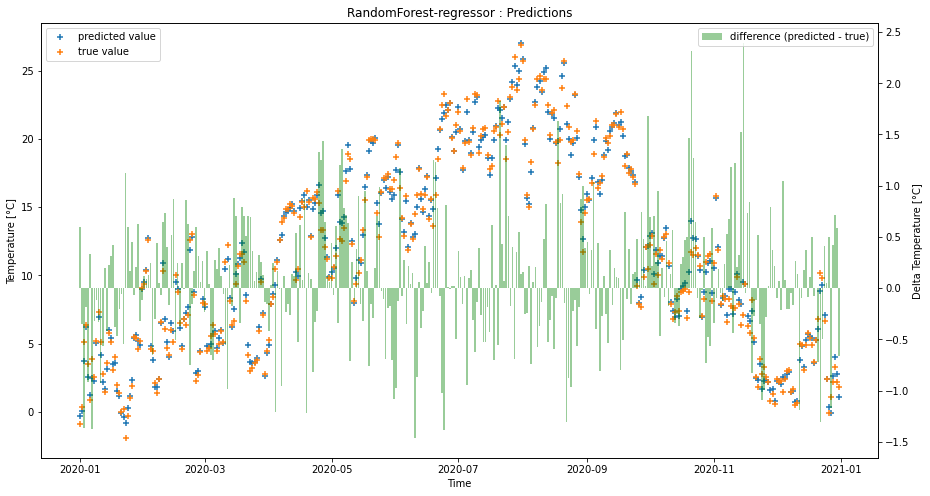

In [125]:
# Predictions from the model
y_pred_rf = gs_results_rf_ok.best_estim.predict(X_to_predict_enc)

# Predictions score (Model performance for the predictions)
MAE_pred_rf = model_error(y_to_predict, y_pred_rf)
print('RandomForest-regressor: MAE score for predictions: {:.2f} degrees'.format(MAE_pred_rf))

# Plot of the predictions
ML_plot_predictions(time_to_predict, y_to_predict, y_pred_rf, 'RandomForest-regressor')

#### **E.3. Intermediate comparison of ML models**

The Mean Absolute Error (MAE) will be used to compare the models. Mean Square Error (MSE) could also be used because no outliers seem to be present (which would have been a reason to use this latter).

Comparison of the models with a bar chart of the scores.

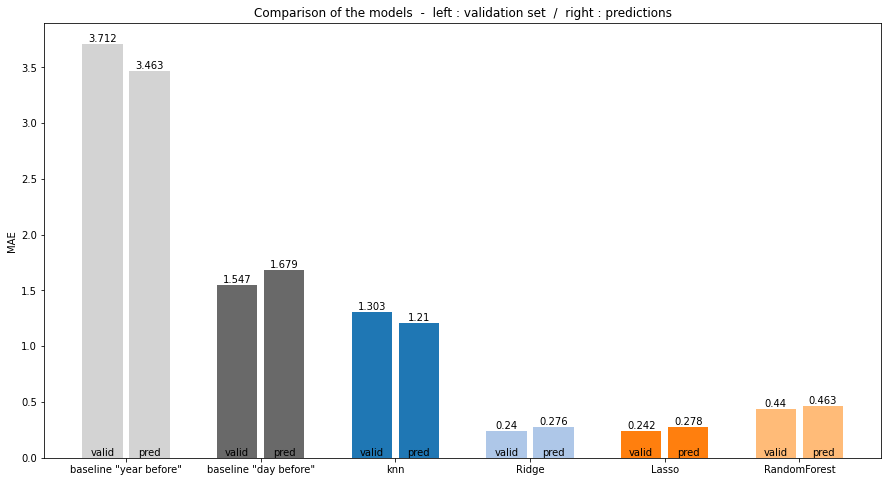

In [126]:
# scores
mae_te_values_mod = [MAE_te_baseline_y, MAE_te_baseline_1, MAE_te_knn, MAE_te_ridge_std, MAE_te_lasso_std, MAE_te_rf]
mae_pred_values_mod = [MAE_pred_baseline_y, MAE_pred_baseline_1, MAE_pred_knn, MAE_pred_ridge_std, MAE_pred_lasso_std, MAE_pred_rf]

# legend
mae_titles_mod = ['baseline "year before"', 'baseline "day before"', 'knn', 'Ridge', 'Lasso', 'RandomForest']

# colors
nb_mae_mod = len(mae_te_values_mod) # number of mae scores to plot
cmap = matplotlib.cm.get_cmap('tab20') # set a discrete colormap
mae_colors_mod = ['lightgrey', 'dimgrey'] +[cmap(i) for i in np.arange(nb_mae_mod)] # get color for each bar, two different greys for baselines

# plot
fig, ax = plt.subplots(figsize=(15,8)) # Size of the figure

width = .3
space = .05
xcor_te = np.arange(nb_mae_mod) - (width+space)/2
xcor_pred = np.arange(nb_mae_mod) + (width+space)/2
xcor = np.arange(nb_mae_mod)

plt.bar(xcor_te, mae_te_values_mod, width, color=mae_colors_mod)
plt.bar(xcor_pred, mae_pred_values_mod, width, color=mae_colors_mod)
plt.xticks(xcor, mae_titles_mod)

# display score values
for h_te, h_pred, v_te, v_pred in zip(xcor_te, xcor_pred, mae_te_values_mod, mae_pred_values_mod):
    ax.text(h_te, v_te + .02, str(round(v_te, 3)), horizontalalignment='center')
    ax.text(h_te, .02, 'valid', horizontalalignment='center')
    ax.text(h_pred, v_pred + .02, str(round(v_pred, 3)), horizontalalignment='center')
    ax.text(h_pred, .02, 'pred', horizontalalignment='center')

plt.title('Comparison of the models  -  left : validation set  /  right : predictions')
plt.ylabel('MAE')
plt.show()

So far, the Ridge model gives the best results for the predictions (and also for the validation set). This model (and its optimized hyperparameter) will be used to consider the various selections of variables. With this model, the standardization will be applied (to avoid ill-conditioned matrices).

Remark : As expected, the score on the validation set is lower than the one for predictions in the Machine Learning models. The baselines do not *learn* from the the data and it turns out that the opposite arises for the baseline "day before".

#### **E.4. Modelisation with various selections of variables**

Remark : The best model obtained is the Standardized Ridge regressor with parameter $\alpha=1.262$. We could also have optimized the parameter for each selection to get even more precise results in order to reach better predictions. Another approach would have been to merge train and validation sets to get a new larger training set for the Standardized Ridge regressor on the whole set of variables and get an optimal value of the hyperparameter $\alpha$. Then, this (fixed) hyperparameter and new training sets (namely years 2015 - 2019 for each selection of variables) would have been used to train the model. That way, the predictions based on the various selections would have been even better...

However, we focus on the selections themself not to lose the thread of the presentation...

##### **E.4.1 Variables with the highest correlation with the temperature in Neuchâtel**

Let's consider the set containing the $n$ highest correlated variables with temperature, then train the Ridge regressor with the hyperparameter found above and finally compute the best score for $n=1, ..., 20$.

In [127]:
corr_y_tr_abs = corr_y_tr.abs().sort_values(ascending=False)

In [128]:
results_sel = []
for n_var in 1+np.arange(20):
    print(n_var, 'highest correlated variables : ')
    sel_var = corr_y_tr_abs.index[:n_var]
    X_orig_tr_sel = X_orig_tr_enc[sel_var].copy()
    X_orig_te_sel = X_orig_te_enc[sel_var].copy()
    X_pred_sel = X_to_predict_enc[sel_var].copy()

    # Run the Standardized-Ridge-regressor only with the best hyperparameter on the selected variables
    res_sel = ML_modelize(StandardScaler(), Ridge(), X_orig_tr_sel, X_orig_te_sel, y_tr, y_te, 'alpha', [best_alpha_ridge_std]) # best_alpha_ridge_std: best hyperparameter
    # Predictions from the model
    y_pred_sel = res_sel.best_estim.predict(X_pred_sel)
    # Predictions score (Model performance for the predictions)
    MAE_pred_sel = model_error(y_to_predict, y_pred_sel)
    print('Ridge-regressor: MAE score for predictions: {:.2f} degrees'.format(MAE_pred_sel))

    results_sel.append({
            'n_var': n_var,
            'last_added_var': sel_var[-1],
            'test_mae':  res_sel.df_best_res.test_mae,
            'pred_mae':  MAE_pred_sel
        })
    
# Convert results to DataFrame
results_sel = pd.DataFrame(results_sel)
results_sel

1 highest correlated variables : 
Ridge-regressor: Validation set - MAE score: 3.48 degrees
Ridge-regressor: MAE score for predictions: 3.26 degrees
2 highest correlated variables : 
Ridge-regressor: Validation set - MAE score: 1.79 degrees
Ridge-regressor: MAE score for predictions: 1.76 degrees
3 highest correlated variables : 
Ridge-regressor: Validation set - MAE score: 1.73 degrees
Ridge-regressor: MAE score for predictions: 1.70 degrees
4 highest correlated variables : 
Ridge-regressor: Validation set - MAE score: 1.14 degrees
Ridge-regressor: MAE score for predictions: 1.21 degrees
5 highest correlated variables : 
Ridge-regressor: Validation set - MAE score: 1.11 degrees
Ridge-regressor: MAE score for predictions: 1.23 degrees
6 highest correlated variables : 
Ridge-regressor: Validation set - MAE score: 0.72 degrees
Ridge-regressor: MAE score for predictions: 0.72 degrees
7 highest correlated variables : 
Ridge-regressor: Validation set - MAE score: 0.53 degrees
Ridge-regresso

last_added_var  n_var  pred_mae  test_mae
0            t_y1      1  3.257199  3.483082
1           t_LUG      2  1.761776  1.785654
2           t_OTL      3  1.700365  1.727517
3           t_SIO      4  1.214723  1.137053
4         t_mean7      5  1.226509  1.111979
5           t_GVE      6  0.716872  0.716250
6           t_PUY      7  0.575204  0.526187
7           t_SAM      8  0.575487  0.524980
8           t_ZER      9  0.567962  0.519441
9           t_LUZ     10  0.531697  0.497430
10          t_SHA     11  0.440810  0.428944
11            t_1     12  0.441076  0.429056
12          t_BER     13  0.445844  0.418611
13            t_3     14  0.448035  0.419045
14            t_2     15  0.449767  0.417167
15            t_4     16  0.449969  0.418929
16          t_CHU     17  0.447422  0.410533
17            t_5     18  0.447343  0.410563
18          t_BAS     19  0.447347  0.410795
19            t_6     20  0.447218  0.410774

Plot the evolution of the score with respect to the selected variables.

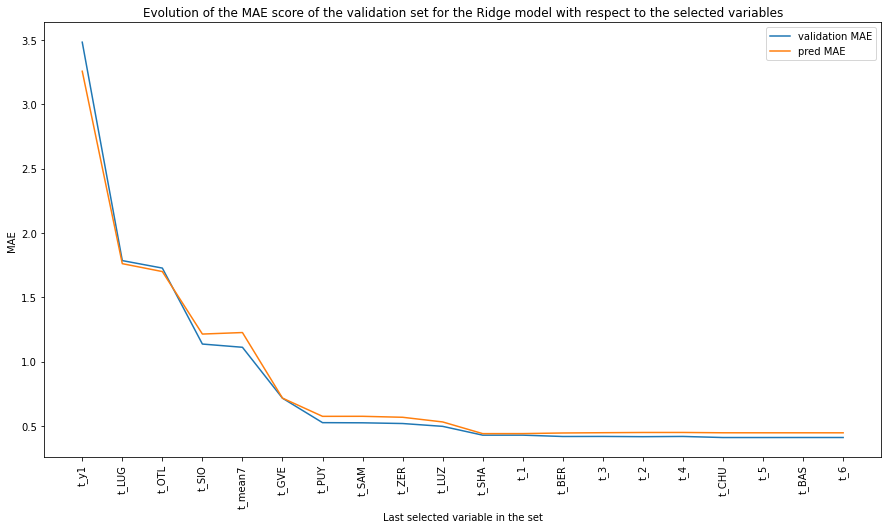

In [129]:
plt.figure(figsize=(15,8)) # Size of the figure

plt.plot(results_sel['n_var'], results_sel['test_mae'], label='validation MAE')
plt.plot(results_sel['n_var'], results_sel['pred_mae'], label='pred MAE')

xcor = 1+np.arange(len(sel_var))
plt.xticks(xcor, sel_var, rotation='vertical')

plt.title('Evolution of the MAE score of the validation set for the Ridge model with respect to the selected variables')
plt.xlabel('Last selected variable in the set')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [130]:
# Model performance for the Ridge-regressor over the 20 highest correlated variables with t.
MAE_te_sel_20_high_corr = results_sel.iloc[-1,:].loc['test_mae']
print('{}-regressor: Test set - MAE score: {:.2f} degrees'.format('Ridge_20_high_corr', MAE_te_sel_20_high_corr))    
MAE_pred_sel_20_high_corr = results_sel.iloc[-1,:].loc['pred_mae'] 
print('{}-regressor: MAE score for predictions: {:.2f} degrees'.format('Ridge_20_high_corr', MAE_pred_sel_20_high_corr))

Ridge_20_high_corr-regressor: Test set - MAE score: 0.41 degrees
Ridge_20_high_corr-regressor: MAE score for predictions: 0.45 degrees


Note that only 'temperature' variables are selected in the first 20 highly correlated variables. Let's select now the 5 variables which decrease the most the score. In the plot above, we can clearly determine them as `t_LUG`, `t_SIO`, `t_GVE`, `t_PUY` and `t_SHA`.

In [131]:
sel_var2 = ['t_LUG', 't_SIO', 't_GVE', 't_PUY', 't_SHA']
# sel_var2 = ['t_y1', 't_SIO', 't_GVE', 't_PUY', 't_SHA']
X_orig_tr_sel2 = X_orig_tr_enc[sel_var2].copy()
X_orig_te_sel2 = X_orig_te_enc[sel_var2].copy()
X_pred_sel2 = X_to_predict_enc[sel_var2].copy()

# With the 5 selected variables
res_sel_5_high_corr = ML_modelize(StandardScaler(), Ridge(), X_orig_tr_sel2, X_orig_te_sel2, y_tr, y_te, 'alpha', [best_alpha_ridge_std])
# Model performance for the Ridge-regressor over the 5 highest correlated variables with t which decrease the most the score.
MAE_te_sel_5_high_corr = model_error(y_te, res_sel_5_high_corr.y_te_pred)
# Predictions from the model
y_pred_sel_5_high_corr = res_sel_5_high_corr.best_estim.predict(X_pred_sel2)
# Predictions score (Model performance for the predictions)
MAE_pred_sel_5_high_corr = model_error(y_to_predict, y_pred_sel_5_high_corr)
print('{}-regressor: MAE score for predictions: {:.2f} degrees'.format('Ridge_5_high_corr', MAE_pred_sel_5_high_corr))

Ridge-regressor: Validation set - MAE score: 0.44 degrees
Ridge_5_high_corr-regressor: MAE score for predictions: 0.44 degrees


The score obtained on the validation set (about 0.44 degrees) is really near the score with the 20 selected variables above (about 0.41 degrees). The score for the predictions is even better (0.44 vs 0.45) !

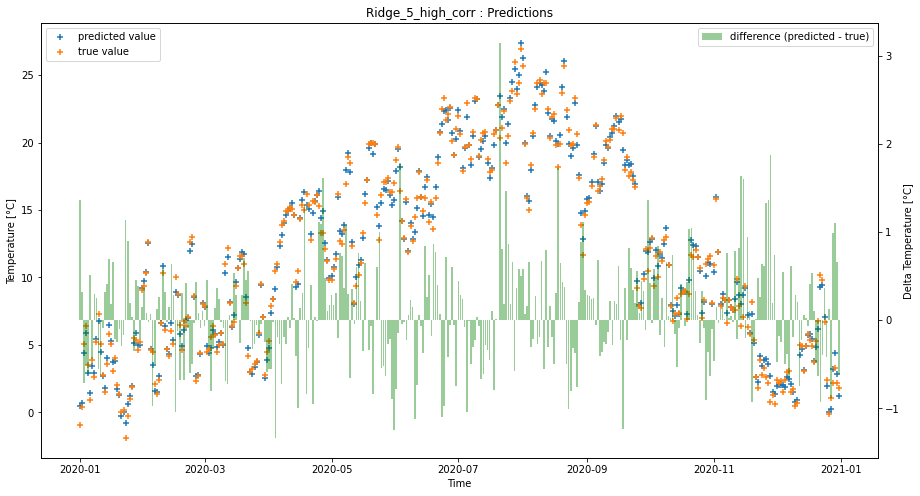

In [132]:
# Plot of the predictions
ML_plot_predictions(time_to_predict, y_to_predict, y_pred_sel_5_high_corr, 'Ridge_5_high_corr')

##### **E.4.2 Variables selected with SelectKBest**

In the Principal Component Analysis (section D.2), 5 variables were selected with SelectKBest.

In [133]:
var_skb_meas

Index(['t_1', 't_y1', 'radiation', 'sunshine', 'humidity'], dtype='object')

Let's compute the score for these 5 selected variables and plot the associated predictions.

In [134]:
# select the variables
X_orig_tr_skb = X_orig_tr_enc[var_skb_meas].copy()
X_orig_te_skb = X_orig_te_enc[var_skb_meas].copy()
X_pred_skb = X_to_predict_enc[var_skb_meas].copy()

In [135]:
# Without preprocessed standardization
res_sel_skb = ML_modelize(StandardScaler(), Ridge(), X_orig_tr_skb, X_orig_te_skb, y_tr, y_te, 'alpha', [best_alpha_ridge_std])
# Model performance for the Ridge-regressor over the selected variables with selectKBest.
MAE_te_sel_skb = model_error(y_te, res_sel_skb.y_te_pred)
# Predictions from the model
y_pred_sel_skb = res_sel_skb.best_estim.predict(X_pred_skb)
# Predictions score (Model performance for the predictions)
MAE_pred_sel_skb = model_error(y_to_predict, y_pred_sel_skb)
print('{}-regressor: MAE score for predictions: {:.2f} degrees'.format('Ridge_skb', MAE_pred_sel_skb))

Ridge-regressor: Validation set - MAE score: 1.36 degrees
Ridge_skb-regressor: MAE score for predictions: 1.41 degrees


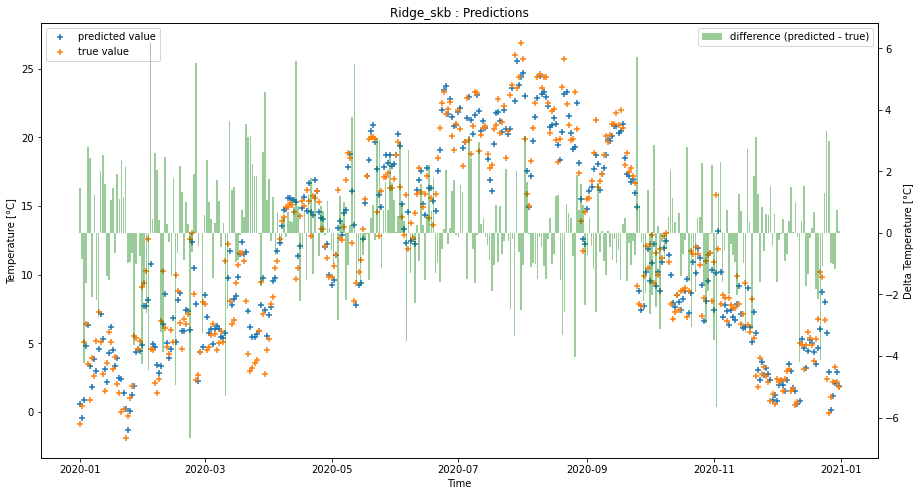

In [136]:
# Plot of the predictions
ML_plot_predictions(time_to_predict, y_to_predict, y_pred_sel_skb, 'Ridge_skb')

##### **E.4.3 Geographical nearest neighbour model**

##### **E.4.3.1 A single geographical nearest neighbour**

Let's compute the score for set containing only the data of the nearest neighbour of Neuchatel, namely `CDF`, and plot the associated predictions.

In [137]:
# select the variables
NEU_neigh = df_stn_ok.loc[df_stn_ok.stn=='NEU', 'neighbour_0'].iloc[0]
NEU_neigh_station = df_stn_ok.loc[df_stn_ok.stn==NEU_neigh, 'station'].iloc[0]
print('Nearest geographical neighbour of Neuchatel : {} ({})'.format(NEU_neigh_station, NEU_neigh))

neigh_var = list(X_orig_tr_enc.columns[[var[-3:]==NEU_neigh for var in X_orig_tr_enc.columns]])
sel_neigh_var = neigh_var + ['year', 'month', 'day', 'season', 'time']
X_orig_tr_neigh = X_orig_tr_enc[sel_neigh_var].copy()
X_orig_te_neigh = X_orig_te_enc[sel_neigh_var].copy()
X_pred_neigh = X_to_predict_enc[sel_neigh_var].copy()

Nearest geographical neighbour of Neuchatel : La Chaux-de-Fonds (CDF)


In [138]:
# Without preprocessed standardization
res_sel_neigh = ML_modelize(StandardScaler(), Ridge(), X_orig_tr_neigh, X_orig_te_neigh, y_tr, y_te, 'alpha', [best_alpha_ridge_std])
# Model performance for the Ridge-regressor over the neigbour's variables.
MAE_te_sel_neigh = model_error(y_te, res_sel_neigh.y_te_pred)
# Predictions from the model
y_pred_sel_neigh = res_sel_neigh.best_estim.predict(X_pred_neigh)
# Predictions score (Model performance for the predictions)
MAE_pred_sel_neigh = model_error(y_to_predict, y_pred_sel_neigh)
print('{}-regressor: MAE score for predictions: {:.2f} degrees'.format('Ridge_geo_nn', MAE_pred_sel_neigh))

Ridge-regressor: Validation set - MAE score: 1.03 degrees
Ridge_geo_nn-regressor: MAE score for predictions: 1.13 degrees


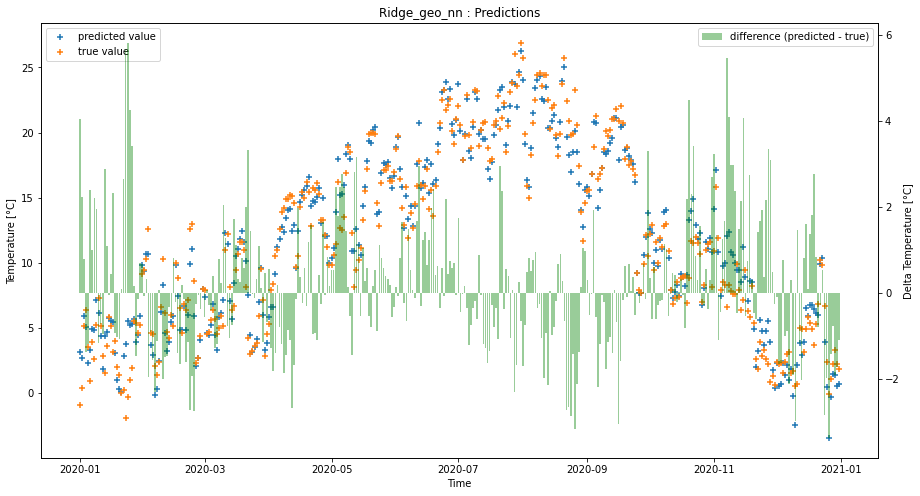

In [139]:
# Plot of the predictions
ML_plot_predictions(time_to_predict, y_to_predict, y_pred_sel_neigh, 'Ridge_geo_nn')

The score of this model is better than the previous one computed with the data available in Neuchatel (validation 1.03, predictions 1.13 vs 1.36 and 1.41). It means that the temperature the same day in another (near) location gives more information than the most correlated variables in the place where the temperature has to be predicted.

##### **E.4.3.2 Three geographical nearest neighbours**

Let's compute the score for set containing only the data of the 3 nearest neighbours of Neuchatel, namely `CDF`, `BER`and `PUY`, and plot the associated predictions.

In [140]:
# select the variables

neighs_var = []
for i in np.arange(number_of_nn):
    NEU_neigh_i = df_stn_ok.loc[df_stn_ok.stn=='NEU', 'neighbour_'+str(i)].iloc[0]
    NEU_neigh_station_i = df_stn_ok.loc[df_stn_ok.stn==NEU_neigh_i, 'station'].iloc[0]
    print('{}-th Nearest geographical neighbour of Neuchatel : {} ({})'.format(1+i, NEU_neigh_station_i, NEU_neigh_i))
    neighs_var = neighs_var + list(X_orig_tr_enc.columns[[var[-3:]==NEU_neigh_i for var in X_orig_tr_enc.columns]])

sel_neighs_var = neighs_var + ['year', 'month', 'day', 'season', 'time']
X_orig_tr_neighs = X_orig_tr_enc[sel_neighs_var].copy()
X_orig_te_neighs = X_orig_te_enc[sel_neighs_var].copy()
X_pred_neighs = X_to_predict_enc[sel_neighs_var].copy()

1-th Nearest geographical neighbour of Neuchatel : La Chaux-de-Fonds (CDF)
2-th Nearest geographical neighbour of Neuchatel : Bern / Zollikofen (BER)
3-th Nearest geographical neighbour of Neuchatel : Pully (PUY)


In [141]:
# Without preprocessed standardization
res_sel_neighs = ML_modelize(StandardScaler(), Ridge(), X_orig_tr_neighs, X_orig_te_neighs, y_tr, y_te, 'alpha', [best_alpha_ridge_std])
# Model performance for the Ridge-regressor over the 3 neighbours' variables.
MAE_te_sel_neighs = model_error(y_te, res_sel_neighs.y_te_pred)
# Predictions from the model
y_pred_sel_neighs = res_sel_neighs.best_estim.predict(X_pred_neighs)
# Predictions score (Model performance for the predictions)
MAE_pred_sel_neighs = model_error(y_to_predict, y_pred_sel_neighs)
print('{}-regressor: MAE score for predictions: {:.2f} degrees'.format('Ridge_3geo_nn', MAE_pred_sel_neighs))

Ridge-regressor: Validation set - MAE score: 0.40 degrees
Ridge_3geo_nn-regressor: MAE score for predictions: 0.44 degrees


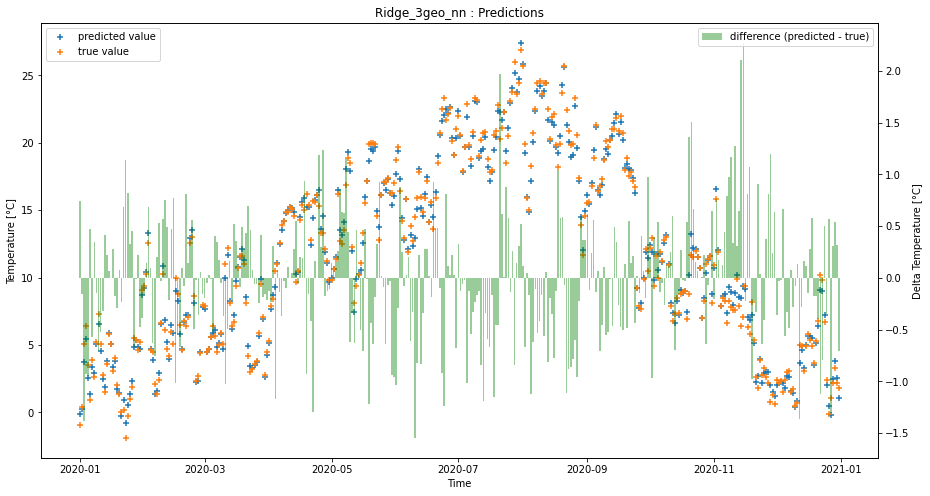

In [142]:
# Plot of the predictions
ML_plot_predictions(time_to_predict, y_to_predict, y_pred_sel_neighs, 'Ridge_3geo_nn')

With the nearest 3 neighbours, predictions are quite better (validation 0.4, predictions 0.44 vs 1.03 and 1.13). Note that the neighbours are *well* distributed around Neuchâtel geographically. But they are not the stations with the highest correlated temperature (LUG, OTL, SIO).

##### **E.4.4 Measurements in Neuchatel only**

Let's compute the score for set containing only the measurements in Neuchatel.

In [143]:
# select the variables
# var_meas = ['humidity', 'precipitation', 'pressure', 'sunshine', 'radiation']
sel_NEU_var = var_meas + ['t_1', 't_2', 't_3', 't_4', 't_5', 't_6', 't_7', 't_y1', 't_mean7'] + ['year', 'month', 'day', 'season', 'time']
X_orig_tr_NEU = X_orig_tr_enc[sel_NEU_var].copy()
X_orig_te_NEU = X_orig_te_enc[sel_NEU_var].copy()
X_pred_NEU = X_to_predict_enc[sel_NEU_var].copy()

In [144]:
# Without preprocessed standardization
res_sel_NEU = ML_modelize(StandardScaler(), Ridge(), X_orig_tr_NEU, X_orig_te_NEU, y_tr, y_te, 'alpha', [best_alpha_ridge_std])
# Model performance for the Ridge-regressor over the variables of NEU.
MAE_te_sel_NEU = model_error(y_te, res_sel_NEU.y_te_pred)
# Predictions from the model
y_pred_sel_NEU = res_sel_NEU.best_estim.predict(X_pred_NEU)
# Predictions score (Model performance for the predictions)
MAE_pred_sel_NEU = model_error(y_to_predict, y_pred_sel_NEU)
print('{}-regressor: MAE score for predictions: {:.2f} degrees'.format('Ridge_NEU', MAE_pred_sel_NEU))

Ridge-regressor: Validation set - MAE score: 1.32 degrees
Ridge_NEU-regressor: MAE score for predictions: 1.36 degrees


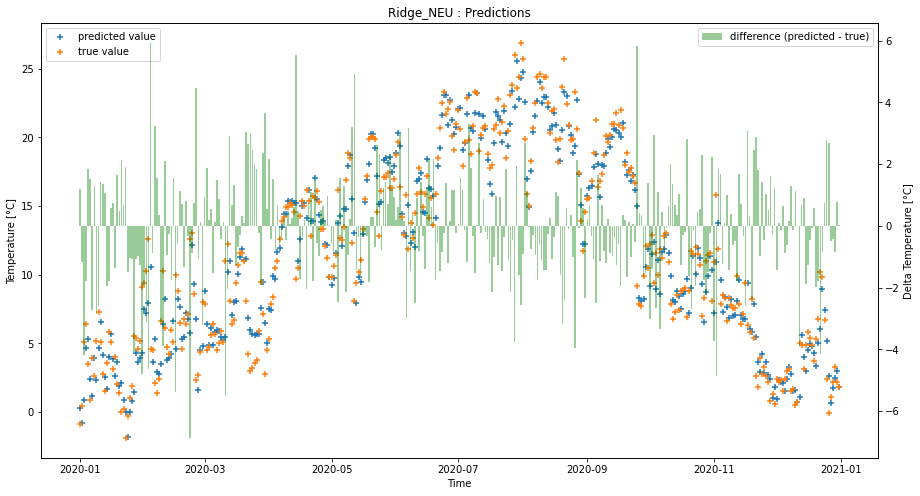

In [145]:
# Plot of the predictions
ML_plot_predictions(time_to_predict, y_to_predict, y_pred_sel_NEU, 'Ridge_NEU')

The score of this model is worse than the one computed with the measurements in Neuchatel (validation 1.32, predictions 1.36 vs 1.03 and 1.13). It means that the temperature the same day in another (near) location gives more information than the measurements in the place where the temperature has to be predicted.

##### **E.4.5 Without temperature variants**

##### **E.4.5.1 Without any temperature measurement in Neuchatel**

This corresponds to the "new station problem" mentioned at the beginning of the project.

In [146]:
# select the variables
sel_var_wo_t_NEU = list(X_orig_tr_enc.columns[[var not in ['t_1', 't_2', 't_3', 't_4', 't_5', 't_6', 't_7', 't_y1', 't_mean7', 't_adj'] for var in X_orig_tr_enc.columns]])

X_orig_tr_wo_t_NEU = X_orig_tr_enc[sel_var_wo_t_NEU].copy()
X_orig_te_wo_t_NEU = X_orig_te_enc[sel_var_wo_t_NEU].copy()
X_pred_wo_t_NEU = X_to_predict_enc[sel_var_wo_t_NEU].copy()

In [147]:
# Without preprocessed standardization
res_sel_wo_t_NEU = ML_modelize(StandardScaler(), Ridge(), X_orig_tr_wo_t_NEU, X_orig_te_wo_t_NEU, y_tr, y_te, 'alpha', [best_alpha_ridge_std])
# Model performance for the Ridge-regressor over the variables of NEU without t.
MAE_te_sel_wo_t_NEU = model_error(y_te, res_sel_wo_t_NEU.y_te_pred)
# Predictions from the model
y_pred_sel_wo_t_NEU = res_sel_wo_t_NEU.best_estim.predict(X_pred_wo_t_NEU)
# Predictions score (Model performance for the predictions)
MAE_pred_sel_wo_t_NEU = model_error(y_to_predict, y_pred_sel_wo_t_NEU)
print('{}-regressor: MAE score for predictions: {:.2f} degrees'.format('Ridge_wo_t_NEU', MAE_pred_sel_wo_t_NEU))

Ridge-regressor: Validation set - MAE score: 0.24 degrees
Ridge_wo_t_NEU-regressor: MAE score for predictions: 0.28 degrees


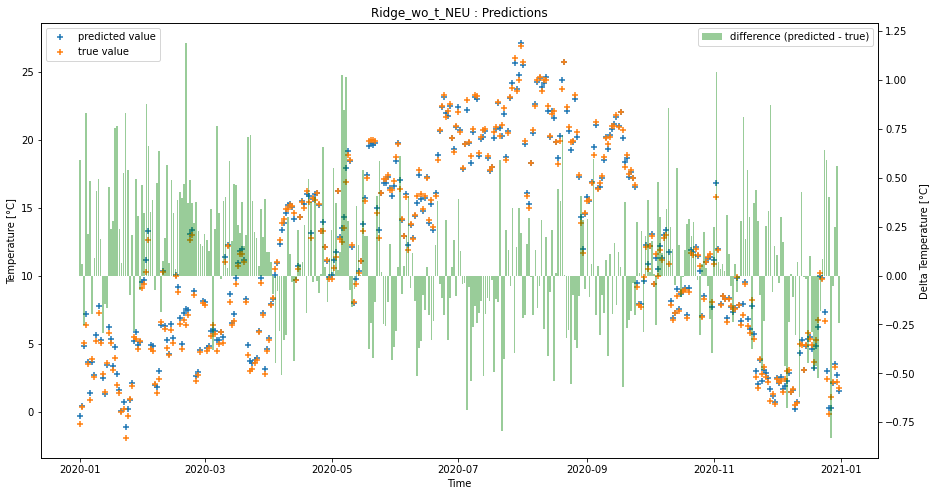

In [148]:
# Plot of the predictions
ML_plot_predictions(time_to_predict, y_to_predict, y_pred_sel_wo_t_NEU, 'Ridge_wo_t_NEU')

The score for the "new station problem" is similar to the one obtained for the "technical problem" (validation 0.24, predictions 0.28 vs 0.24 and 0.278).

Another version of the "new station problem" we could call "completely new station problem" consists in predicting the temperature for a station where no other records is avalaible. The difference with the other version is that the measurements are removed from the selected data.

In [149]:
# select the variables
sel_new_station = list(X_orig_tr_enc.columns[[var not in ['t_1', 't_2', 't_3', 't_4', 't_5', 't_6', 't_7', 't_y1', 't_mean7', 't_adj',
                                                         'radiation', 'pressure', 'precipitation', 'humidity', 'sunshine', 'r_rain_humidity'] for var in X_orig_tr_enc.columns]])

X_orig_tr_new_station = X_orig_tr_enc[sel_new_station].copy()
X_orig_te_new_station = X_orig_te_enc[sel_new_station].copy()
X_pred_new_station = X_to_predict_enc[sel_new_station].copy()

In [150]:
# Without preprocessed standardization
res_sel_new_station = ML_modelize(StandardScaler(), Ridge(), X_orig_tr_new_station, X_orig_te_new_station, y_tr, y_te, 'alpha', [best_alpha_ridge_std])
# Model performance for the Ridge-regressor over the variables of NEU without t.
MAE_te_sel_new_station = model_error(y_te, res_sel_new_station.y_te_pred)
# Predictions from the model
y_pred_sel_new_station = res_sel_new_station.best_estim.predict(X_pred_new_station)
# Predictions score (Model performance for the predictions)
MAE_pred_sel_new_station = model_error(y_to_predict, y_pred_sel_new_station)
print('{}-regressor: MAE score for predictions: {:.2f} degrees'.format('Ridge_wo_t_NEU', MAE_pred_sel_new_station))

Ridge-regressor: Validation set - MAE score: 0.35 degrees
Ridge_wo_t_NEU-regressor: MAE score for predictions: 0.41 degrees


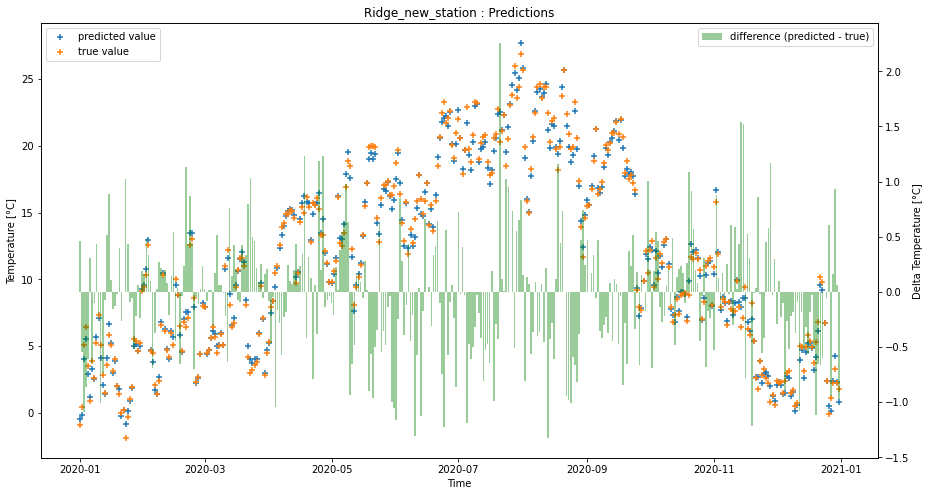

In [151]:
# Plot of the predictions
ML_plot_predictions(time_to_predict, y_to_predict, y_pred_sel_new_station, 'Ridge_new_station')

The score (validation 0.35 and 0.41) is this time significantly higher than the one of the "technical problem" (validation 0.24 and 0.278).

##### **E.4.5.2 Without any temperature measurement on D-day (only lags are considered)**

This corresponds to the problem of guessing the temperature on next day ("prediction problem") mentioned at the beginning of the project.

In [152]:
# select the variables
var_wo_t = list(X_orig_tr_enc.columns[[var[:2]!='t_' for var in X_orig_tr_enc.columns]]) # without temperature variables at all
# list(X_orig_tr_enc.columns[~X_orig_tr_enc.columns.str.startswith('t_')])
sel_var_lags = var_wo_t + ['t_1', 't_2', 't_3', 't_4', 't_5', 't_6', 't_7', 't_y1', 't_mean7']

In [153]:
# select the variables
X_orig_tr_lags = X_orig_tr_enc[sel_var_lags].copy()
X_orig_te_lags = X_orig_te_enc[sel_var_lags].copy()
X_pred_lags = X_to_predict_enc[sel_var_lags].copy()

In [154]:
# Without preprocessed standardization
res_sel_lags = ML_modelize(StandardScaler(), Ridge(), X_orig_tr_lags, X_orig_te_lags, y_tr, y_te, 'alpha', [best_alpha_ridge_std])
# Model performance for the Ridge-regressor over the variables without t but lags.
MAE_te_sel_lags = model_error(y_te, res_sel_lags.y_te_pred)
# Predictions from the model
y_pred_sel_lags = res_sel_lags.best_estim.predict(X_pred_lags)
# Predictions score (Model performance for the predictions)
MAE_pred_sel_lags = model_error(y_to_predict, y_pred_sel_lags)
print('{}-regressor: MAE score for predictions: {:.2f} degrees'.format('Ridge_lags', MAE_pred_sel_lags))

Ridge-regressor: Validation set - MAE score: 0.71 degrees
Ridge_lags-regressor: MAE score for predictions: 0.66 degrees


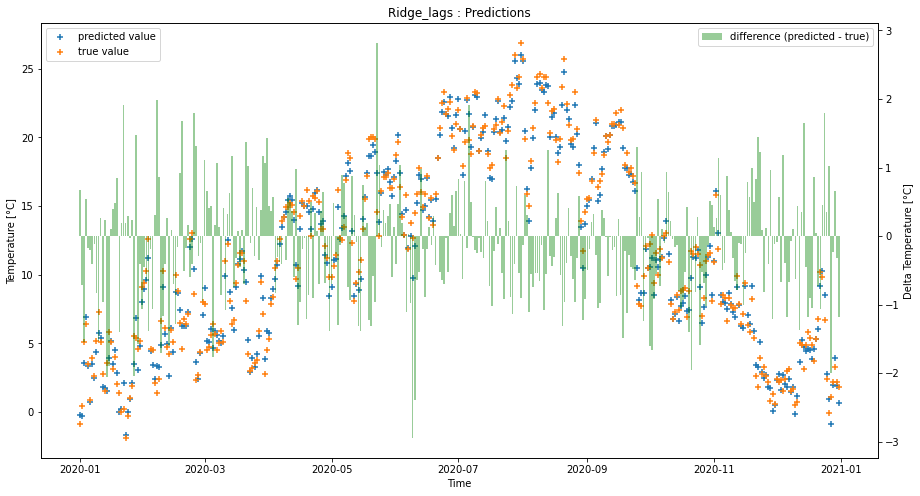

In [155]:
# Plot of the predictions
ML_plot_predictions(time_to_predict, y_to_predict, y_pred_sel_lags, 'Ridge_lags')

For this "prediction problem", the score are significantly higher than for the other two,namely the "new station" and "technical problem" (validation 0.71, predictions 0.66 vs 0.24 and 0.28).

##### **E.4.5.3 Without any temperature measurement at all**

In [156]:
# select the variables
X_orig_tr_wo_t_tot = X_orig_tr_enc[var_wo_t].copy()
X_orig_te_wo_t_tot = X_orig_te_enc[var_wo_t].copy()
X_pred_wo_t_tot = X_to_predict_enc[var_wo_t].copy()

In [157]:
# Without preprocessed standardization
res_sel_wo_t_tot = ML_modelize(StandardScaler(), Ridge(), X_orig_tr_wo_t_tot, X_orig_te_wo_t_tot, y_tr, y_te, 'alpha', [best_alpha_ridge_std])
# Model performance for the Ridge-regressor over the variables without t at all.
MAE_te_sel_wo_t_tot = model_error(y_te, res_sel_wo_t_tot.y_te_pred)
# Predictions from the model
y_pred_sel_wo_t_tot = res_sel_wo_t_tot.best_estim.predict(X_pred_wo_t_tot)
# Predictions score (Model performance for the predictions)
MAE_pred_sel_wo_t_tot = model_error(y_to_predict, y_pred_sel_wo_t_tot)
print('{}-regressor: MAE score for predictions: {:.2f} degrees'.format('Ridge_wo_t_tot', MAE_pred_sel_wo_t_tot))

Ridge-regressor: Validation set - MAE score: 0.74 degrees
Ridge_wo_t_tot-regressor: MAE score for predictions: 0.68 degrees


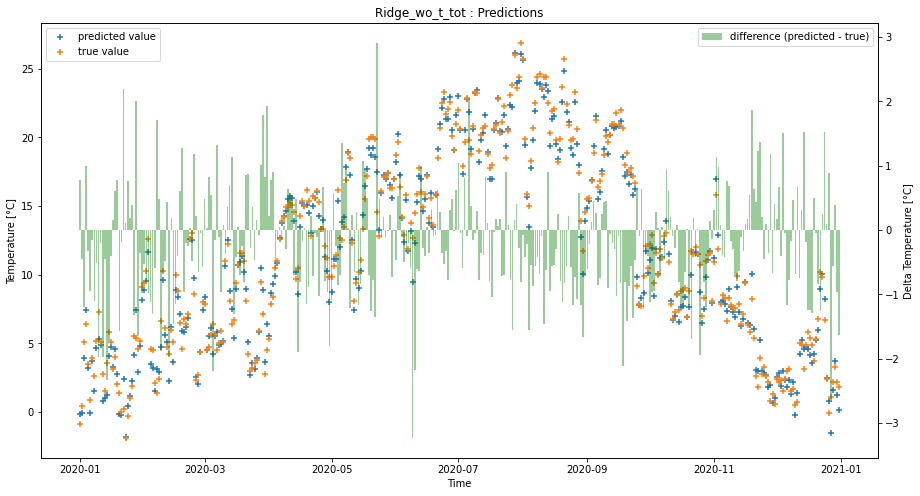

In [158]:
# Plot of the predictions
ML_plot_predictions(time_to_predict, y_to_predict, y_pred_sel_wo_t_tot, 'Ridge_wo_t_tot')

##### **E.4.6 Seasonal adjusted temperature**

See the additionnal notebook for a seasonal adjusted version.

#### **E.5. Intermediate comparison of variables selections**

As for th comparison of the ML models (Section E.3) , the Mean Absolute Error (MAE) will be used to compare the models based on the selections of variables presented above.

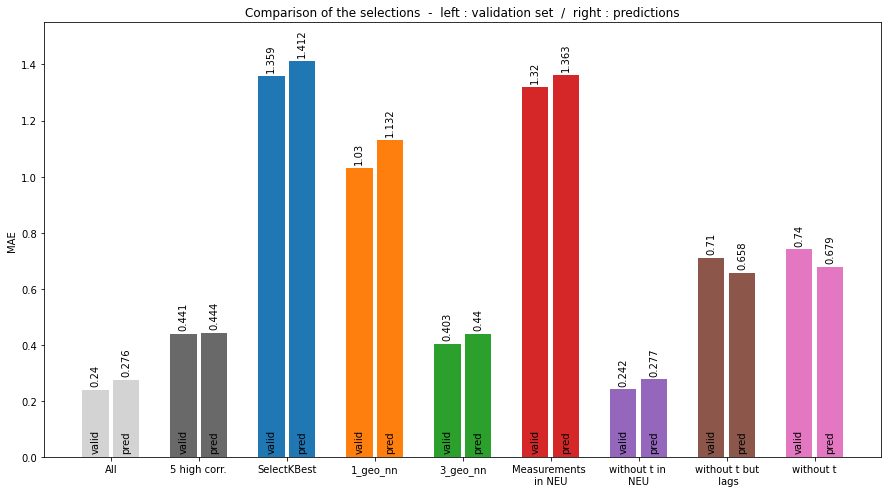

In [159]:
import re # Module used to display xticks labels on multiple lines.

# scores
mae_te_values_var = [MAE_te_ridge_std, MAE_te_sel_5_high_corr, MAE_te_sel_skb, MAE_te_sel_neigh, MAE_te_sel_neighs, MAE_te_sel_NEU, MAE_te_sel_wo_t_NEU, MAE_te_sel_lags, MAE_te_sel_wo_t_tot]
mae_pred_values_var = [MAE_pred_ridge_std, MAE_pred_sel_5_high_corr, MAE_pred_sel_skb, MAE_pred_sel_neigh, MAE_pred_sel_neighs, MAE_pred_sel_NEU, MAE_pred_sel_wo_t_NEU, MAE_pred_sel_lags, 
                       MAE_pred_sel_wo_t_tot]

# legend
mae_titles_var = ['All', '5 high corr.', 'SelectKBest', '1_geo_nn', '3_geo_nn', 'Measurements in NEU', 'without t in NEU', 'without t but lags', 'without t']

# colors
nb_mae_var = len(mae_te_values_var) # number of mae scores to plot
cmap = matplotlib.cm.get_cmap('tab10') # set a discrete colormap
mae_colors_var = ['lightgrey', 'dimgrey'] +[cmap(i) for i in np.arange(nb_mae_var)] # get color for each bar, two different greys for baselines

# plot
fig, ax = plt.subplots(figsize=(15,8)) # Size of the figure

width = .3
space = .05
xcor_te = np.arange(nb_mae_var) - (width+space)/2
xcor_pred = np.arange(nb_mae_var) + (width+space)/2
xcor = np.arange(nb_mae_var)

plt.bar(xcor_te, mae_te_values_var, width, color=mae_colors_var)
plt.bar(xcor_pred, mae_pred_values_var, width, color=mae_colors_var)

xlabels = [re.sub("(.{13})", "\\1\n", label, 0, re.DOTALL) for label in mae_titles_var] # to split the x_labels after 13 characters
plt.xticks(xcor, xlabels)
# plt.xticks(xcor, mae_titles_var)

# display score values
for h_te, h_pred, v_te, v_pred in zip(xcor_te, xcor_pred, mae_te_values_var, mae_pred_values_var):
    ax.text(h_te, v_te + .02, str(round(v_te, 3)), horizontalalignment='center', rotation=90)
    ax.text(h_te, .02, 'valid', horizontalalignment='center', rotation=90)
    ax.text(h_pred, v_pred + .02, str(round(v_pred, 3)), horizontalalignment='center', rotation=90)
    ax.text(h_pred, .02, 'pred', horizontalalignment='center', rotation=90)
ax.set_ylim(top=1.55)
plt.title('Comparison of the selections  -  left : validation set  /  right : predictions')
plt.ylabel('MAE')
plt.show()

Remarks on the predictions scores:
- The selection without the temperature in Neuchatel 'without t in NEU' is quite near of the complete model;
- The nearest neighbour selections indicate that 3 stations give a quite good prediction. It could be interesting to see the evolution of the score depending on the number of nearest neighbours considered;
- The information given by the other stations is really helpful ('Measurements in NEU' has a score of 1.363 compared to 0.276 for the complete model);
- The score  of the model based on the nearest neighbour ('1_geo_nn', score 1.13) is better than the one computed with the measurements in Neuchatel ('Measurements in NEU', score 1.36);
- Temperature lags add no significantly information compared to the model without temperature at all. This is visible by comparing 'All' and 'without t in NEU' scores (difference 0.001) on the first hand, and 'without t but lags' and 'without t' scores (difference 0.021) on the other hand;
- The "prediction problem" ('without t but lags', score 0.658) is quite more complicated than the "technical problem" ('All', score 0.276).
- The "new station problem" ('without t in NEU', score 0.277) is really near of the "technical problem" ('All', score 0.276), meanning that the knowledge of previous temperatures in a station does not inform very much. The variant "completely new station problem" is still affordable (score 0.41, see E.4.5.1).

#### **E.6. Final comparison**

For the sake of completeness, let's display all the scores together (models and variables selections) in a bar chart and compare the time series of the difference between the predicted and the real value for each model.

Comparison of the models with a bar chart of the scores.

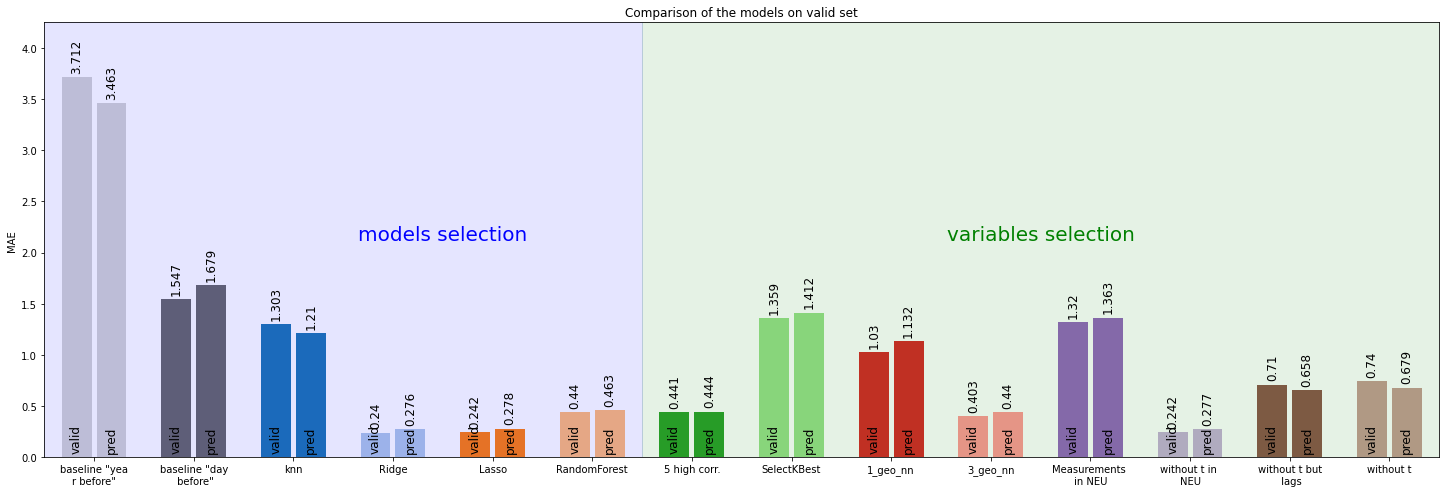

In [160]:
# scores
mae_te_values_tot = mae_te_values_mod + mae_te_values_var[1:] 
mae_pred_values_tot = mae_pred_values_mod + mae_pred_values_var[1:] 

# legend
mae_titles_tot = mae_titles_mod + mae_titles_var[1:] 

# colors
nb_mae_tot = len(mae_te_values_tot) # number of mae scores to plot
cmap = matplotlib.cm.get_cmap('tab20') # set a discrete colormap
mae_colors_tot = ['lightgrey', 'dimgrey'] +[cmap(i) for i in np.arange(nb_mae_tot)] # get color for each bar, two different greys for baselines

# plot
fig, ax = plt.subplots(figsize=(25,8)) # Size of the figure
width = .3
space = .05
xcor_te = np.arange(nb_mae_tot) - (width+space)/2
xcor_pred = np.arange(nb_mae_tot) + (width+space)/2
xcor = np.arange(nb_mae_tot)

plt.bar(xcor_te, mae_te_values_tot, width, color=mae_colors_tot)
plt.bar(xcor_pred, mae_pred_values_tot, width, color=mae_colors_tot)

xlabels = [re.sub("(.{13})", "\\1\n", label, 0, re.DOTALL) for label in mae_titles_tot] # to split the x_labels after 13 characters
plt.xticks(xcor, xlabels)
# plt.xticks(xcor, mae_titles_var)

# display score values
margin = .07
for h_te, h_pred, v_te, v_pred in zip(xcor_te, xcor_pred, mae_te_values_tot, mae_pred_values_tot):
    ax.text(h_te, v_te + margin, str(round(v_te, 3)), horizontalalignment='center', rotation=90, size=12)
    ax.text(h_te, margin, 'valid', horizontalalignment='center', rotation=90, size=12)
    ax.text(h_pred, v_pred + margin, str(round(v_pred, 3)), horizontalalignment='center', rotation=90, size=12)
    ax.text(h_pred, margin, 'pred', horizontalalignment='center', rotation=90, size=12)
ax.set_ylim(top=4.25)
plt.title('Comparison of the selections  -  left : valid set  /  right : predictions')
plt.ylabel('MAE')


# display "models selection zone"
start, end = -0.5, len(mae_te_values_mod) - .5
ax.axvspan(start, end, alpha=.1, color='blue')
trans = ax.get_xaxis_transform()
ax.text((start + end) / 2 + 1, .5, 'models selection', c='blue', size=20, horizontalalignment='center', transform=trans)

# display "variables selections zone"
start, end = len(mae_te_values_mod) - .5 , len(mae_te_values_tot) - .5 
ax.axvspan(start, end, alpha=.1, color='green')
trans = ax.get_xaxis_transform()
ax.text((start + end) / 2, .5, 'variables selection', c='green', size=20, horizontalalignment='center', transform=trans)

ax.set_xlim(xmin=-0.5, xmax=len(mae_te_values_tot) - .5)
    
plt.ylabel('MAE')
plt.title('Comparison of the models on valid set')
plt.show()

Comparison of the models by plotting the time series of the difference between the predicted and the real value for each model.

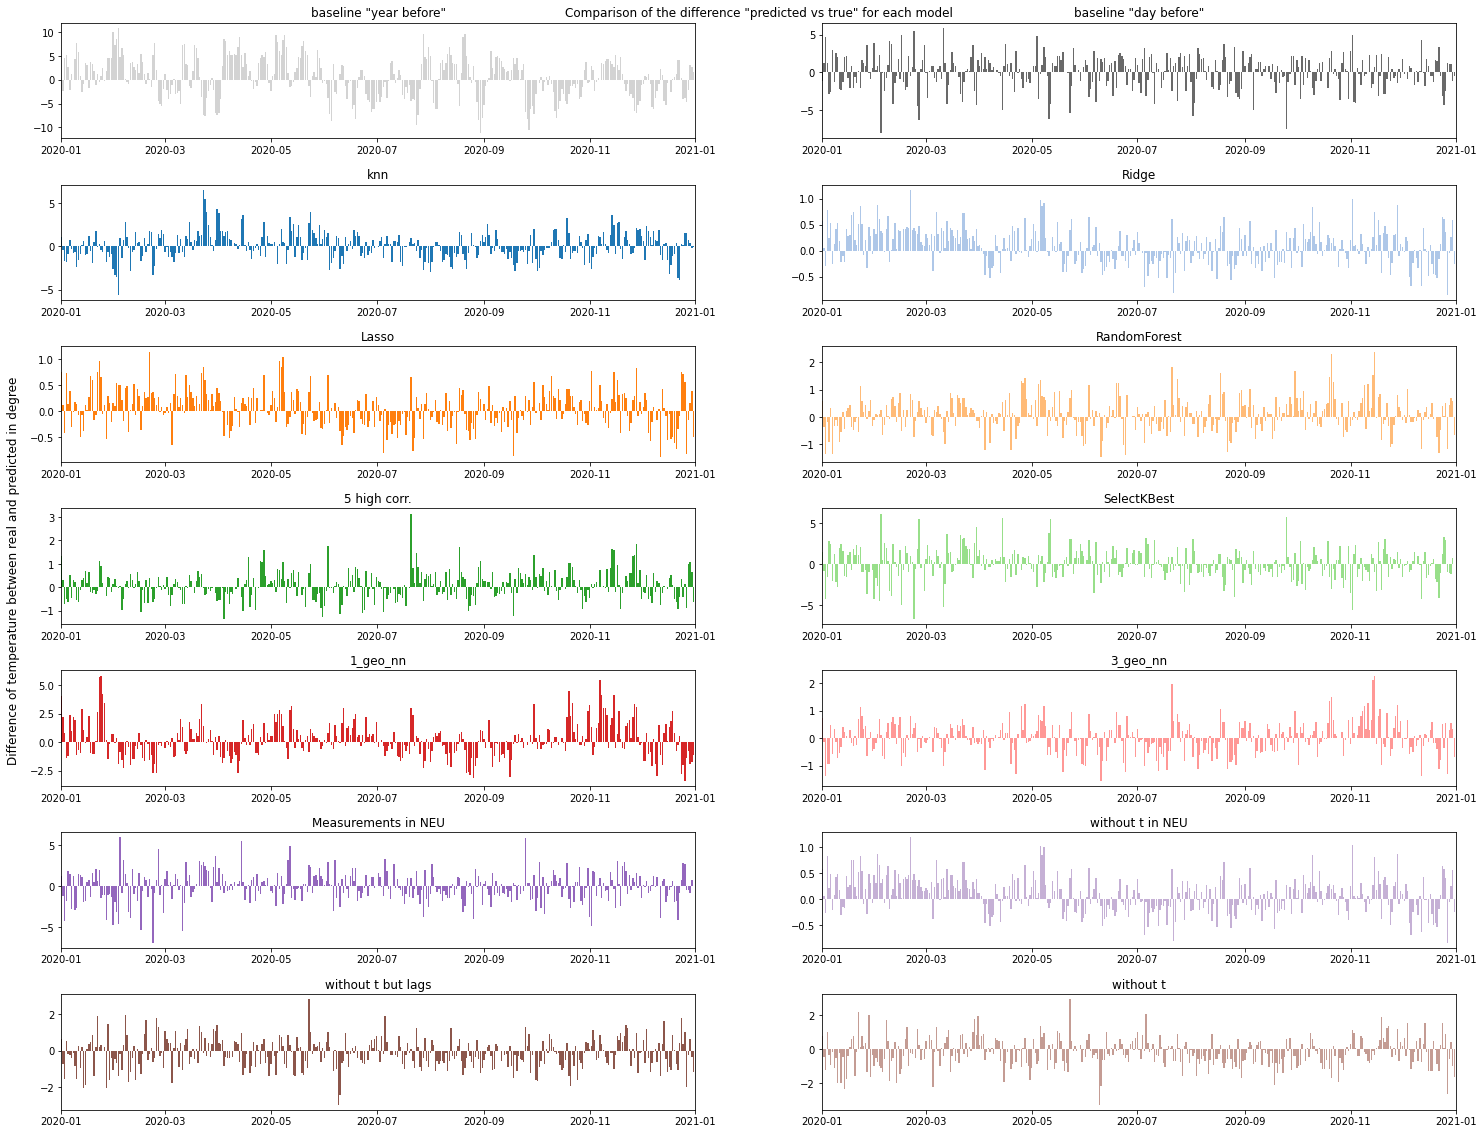

In [161]:
# differences
tot_text = ['knn', 'ridge_std', 'lasso_std', 'rf_ok', 'sel_5_high_corr', 'sel_skb', 'sel_neigh', 'sel_neighs', 'sel_NEU', 'sel_wo_t_NEU', 'sel_lags', 'sel_wo_t_tot']

delta_y_pred_knn= y_pred_knn - y_to_predict
delta_y_pred_ridge_std= y_pred_ridge_std - y_to_predict
delta_y_pred_lasso_std= y_pred_lasso_std - y_to_predict
delta_y_pred_rf= y_pred_rf - y_to_predict
delta_y_pred_sel_5_high_corr= y_pred_sel_5_high_corr - y_to_predict
delta_y_pred_sel_skb= y_pred_sel_skb - y_to_predict
delta_y_pred_sel_neigh= y_pred_sel_neigh - y_to_predict
delta_y_pred_sel_neighs= y_pred_sel_neighs - y_to_predict
delta_y_pred_sel_NEU= y_pred_sel_NEU - y_to_predict
delta_y_pred_sel_wo_t_NEU= y_pred_sel_wo_t_NEU - y_to_predict
delta_y_pred_sel_lags= y_pred_sel_lags - y_to_predict
delta_y_pred_sel_wo_t_tot= y_pred_sel_wo_t_tot - y_to_predict

deltas = [delta_y_pred_baseline_y, delta_y_pred_baseline_1, delta_y_pred_knn, delta_y_pred_ridge_std, delta_y_pred_lasso_std, delta_y_pred_rf, 
          delta_y_pred_sel_5_high_corr, delta_y_pred_sel_skb, delta_y_pred_sel_neigh, delta_y_pred_sel_neighs, delta_y_pred_sel_NEU, delta_y_pred_sel_wo_t_NEU, 
          delta_y_pred_sel_lags, delta_y_pred_sel_wo_t_tot]


fig = plt.figure(figsize=(25, 20))
fig.subplots_adjust(hspace=0.4)

plt.title('Comparison of the difference "predicted vs true" for each model')
plt.box(on=None)
plt.axis('off')

for mod in np.arange(len(deltas)):
    ax = fig.add_subplot(7, 2, mod + 1)
    ax.bar(time_to_predict, deltas[mod], label=mae_titles_tot[mod], color=mae_colors_tot[mod])
    ax.set_xlim(xmin='2020-01-01', xmax='2021-01-01')
    plt.title(mae_titles_tot[mod])
#     plt.ylabel('Difference of temperature in degree')
    
fig.text(0.095, 0.5, 'Difference of temperature between real and predicted in degree', verticalalignment='center', rotation='vertical', size=12) # ylabel trick
plt.show()

Remarks:
- As indicated by the scores, the baseline "year before" is noticeably worse thant the other models (see the y-axis scale).
- The baseline "year before" shows that some periods of several days were warmer/cooler than year before;
- No model has a typical pattern (e.g. rather warmer temperatures during the first half of year, and rather cooler for the second half, ...).
- Temperatures in March seem to be overvalued by several models (Ridge, Lasso, and to a lesser extent, RandomForest, kNN), especially the second half.

For this latter remark, let's display the predictions on March (and drop the kNN model which is less efficient).

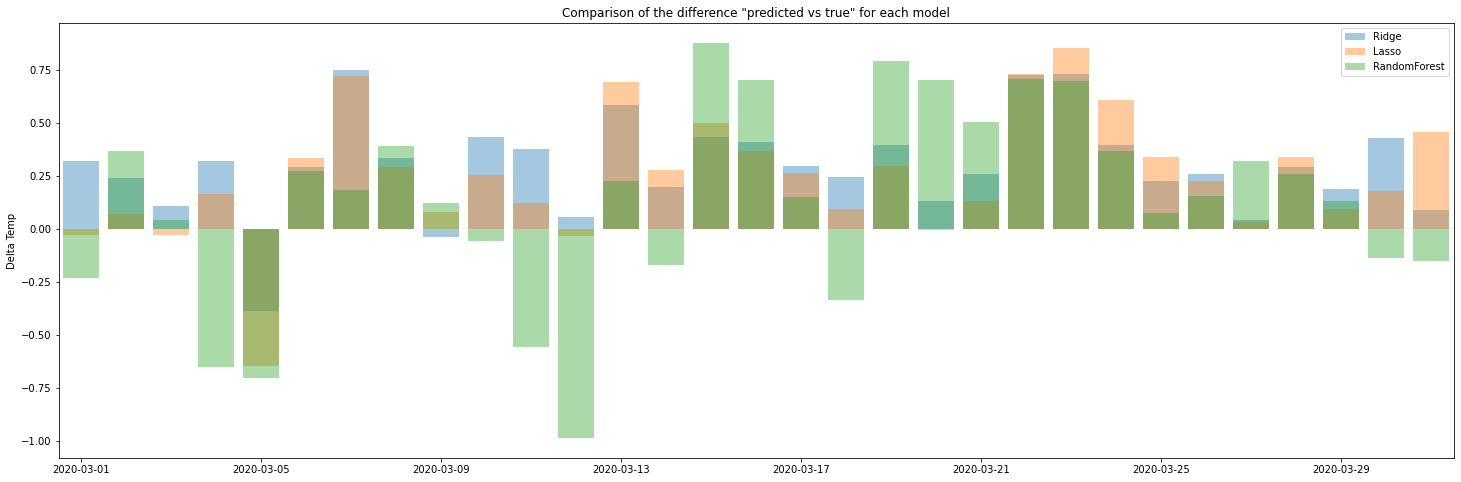

In [162]:
# Focus on Ridge, Lasso and Random Forest models
deltas_sel = [delta_y_pred_ridge_std, delta_y_pred_lasso_std, delta_y_pred_rf]

cmap = matplotlib.cm.get_cmap('tab10') # set a discrete colormap
mae_colors_sel = [cmap(i) for i in np.arange(len(deltas_sel))] # get color for each bar, two different greys for baselines

# Bar plot
fig, ax = plt.subplots(figsize=(25,8)) # Size of the figure

# Focus on March 2020
time_flt = (time_to_predict>="2020-03-01") & (time_to_predict<"2020-04-01")

for mod in np.arange(len(deltas_sel)):
     plt.bar(time_to_predict.loc[time_flt], deltas_sel[mod][time_flt], label=['Ridge', 'Lasso', 'RandomForest'][mod], color=mae_colors_sel[mod], alpha=.4)

ax.set_xlim(xmin='2020-02-29-12:00:00', xmax='2020-03-31-12:00:00')

plt.title('Comparison of the difference "predicted vs true" for each model')
plt.ylabel('Delta Temp')
plt.legend()
plt.show()

Let's focus on 2019-03-05. That day, the three models predicted a too low temperature.

In [163]:
d_day = "2020-03-05"

# Get the index of 2020-03-05 for y_to_predict
time_0305_flt = (time_to_predict==d_day)
id_0305 = time_to_predict.loc[time_0305_flt].index[0]

# Get the index of 2020-03-05 for the predictions
time_to_predict_id = time_to_predict.reset_index(drop=True)
time_0305_flt_id = (time_to_predict_id==d_day)
id_0305_mod = time_to_predict_id.loc[time_0305_flt_id].index[0]

print('Day considered: ', d_day)
print('True temperature : {}°C.'.format(y_to_predict.loc[id_0305]))
print('Predicted temperature with the Ridge model : {:.2f}°C.'.format(y_pred_ridge_std[id_0305_mod]))
print('Predicted temperature with the Lasso model : {:.2f}°C.'.format(y_pred_lasso_std[id_0305_mod]))
print('Predicted temperature with the RandomForest model : {:.2f}°C.'.format(y_pred_rf[id_0305_mod]))

Day considered:  2020-03-05
True temperature : 6.4°C.
Predicted temperature with the Ridge model : 6.01°C.
Predicted temperature with the Lasso model : 5.75°C.
Predicted temperature with the RandomForest model : 5.70°C.


Looking back to the plot of the predictions over the whole year, the models themselves (and not the selections of the variables) seem to predict too high temperatures on average.

In [164]:
# differences
# tot_text = ['knn', 'ridge_std', 'lasso_std', 'rf', 'sel_5_high_corr', 'sel_skb', 'sel_neigh', 'sel_neighs', 'sel_NEU', 'sel_wo_t_NEU', 'sel_lags', 'sel_wo_t_tot']
mae_titles_tot
pos_neg_diff_df = pd.DataFrame(columns=['Total positive difference', 'Total negative difference', 'Total balance'], 
                               index=mae_titles_tot)
for t, m in enumerate(deltas):
    sum_delta_pos = 0
    sum_delta_neg = 0
    for i in m.index:
        sum_delta_pos = sum_delta_pos + np.max([m[i], 0.])
        sum_delta_neg = sum_delta_neg + np.min([m[i], 0.])
#    print("The '{}'-model predicted too high temperatures for a total of {:.2f} °C and too low temperatures for a total of {:.2f} °C".format(mae_titles_tot[t], sum_delta_pos, sum_delta_neg))
    pos_neg_diff_df.loc[mae_titles_tot[t]] = pd.Series({'Total positive difference':sum_delta_pos, 'Total negative difference':sum_delta_neg, 'Total balance':sum_delta_pos+sum_delta_neg})

pos_neg_diff_df

Total positive difference Total negative difference  \
baseline "year before"                     711.4                    -556.2   
baseline "day before"                      308.1                    -306.5   
knn                                        228.6                  -214.093   
Ridge                                    67.1791                  -33.9951   
Lasso                                    58.6199                  -43.2924   
RandomForest                             99.2279                  -70.0636   
5 high corr.                             95.8582                  -66.6222   
SelectKBest                              256.862                  -259.984   
1_geo_nn                                 238.314                  -176.098   
3_geo_nn                                 79.1208                  -81.9465   
Measurements in NEU                      231.647                  -267.372   
without t in NEU                         67.0436                  -34.3878   
without t but lags                       92.4578                  -148.245   
without t                                85.1553                  -163.504   

                       Total balance  
baseline "year before"         155.2  
baseline "day before"            1.6  
knn                          14.5067  
Ridge                         33.184  
Lasso                        15.3275  
RandomForest                 29.1642  
5 high corr.                  29.236  
SelectKBest                 -3.12173  
1_geo_nn                     62.2155  
3_geo_nn                     -2.8257  
Measurements in NEU         -35.7245  
without t in NEU             32.6558  
without t but lags          -55.7868  
without t                   -78.3492

The DataFrame above shows that both baselines and the four models predicted too high temperature on average ('Total balance' column). It is maybe due to the fact that 2020 was warmer than the previous years...

In [165]:
print("Mean temperature of year 2015 : {:.2f}°C.".format(df_NEU.loc[(df_NEU.time>='2015-01-01') & (df_NEU.time<'2016-01-01')].temperature.mean()))
print("Mean temperature of year 2016 : {:.2f}°C.".format(df_NEU.loc[(df_NEU.time>='2016-01-01') & (df_NEU.time<'2017-01-01')].temperature.mean()))
print("Mean temperature of year 2017 : {:.2f}°C.".format(df_NEU.loc[(df_NEU.time>='2017-01-01') & (df_NEU.time<'2018-01-01')].temperature.mean()))
print("Mean temperature of year 2018 : {:.2f}°C.".format(df_NEU.loc[(df_NEU.time>='2018-01-01') & (df_NEU.time<'2019-01-01')].temperature.mean()))
print("Mean temperature of year 2019 : {:.2f}°C.".format(df_NEU.loc[(df_NEU.time>='2019-01-01') & (df_NEU.time<'2020-01-01')].temperature.mean()))
print('')
print("Mean temperature of years 2015-2019 : {:.2f}°C.".format(df_NEU.loc[(df_NEU.time>='2015-01-01') & (df_NEU.time<'2020-01-01')].temperature.mean()))
print('')
print("Mean temperature of year 2020 : {:.2f}°C.".format(df_NEU.loc[(df_NEU.time>='2020-01-01') & (df_NEU.time<'2021-01-01')].temperature.mean()))

Mean temperature of year 2015 : 11.53°C.
Mean temperature of year 2016 : 10.84°C.
Mean temperature of year 2017 : 11.19°C.
Mean temperature of year 2018 : 11.82°C.
Mean temperature of year 2019 : 11.30°C.

Mean temperature of years 2015-2019 : 11.34°C.

Mean temperature of year 2020 : 11.72°C.


### F. Conclusion

#### **F.1. Final discussion**

The model with the whole data information beats significantly the baseline "day before". Concreatly, it means that if a technical problem arise in the temperature sensor in Neuchatel, our model (namely 'Ridge') gives a significantly better estimations than taking the temperature the day before. More challenging was the "prediction problem" : our model (namely 'without t but lags') gives also better estimations than taking the temperature the day before. Finally, creating a whole serie of temperatures in a station where this measurement was never recorded is also well answered with our model (namely 'without t in NEU'). Its score is similar to the one of the "Technical problem", which means that the knowledge of the past temperature does not add helpful information. This is maybe the most expected observation of this project.

#### **F.2. Summary of the three problems**

- Technical problem's score : 0.276;
- Prediction problem's score : 0.658;
- New station problem's score : 0.277;
- Baseline's score : 1.679.

#### **F.3. Going further**

- Compute the lag of the other measurements to can address a *true* prediction problem, that is a prediction of the temperature on d-day without any measurement that day. In other word to address the question: *what will be the temperature tomorrow ?*;
- Adapt the code to automatically apply all the process done for Neuchatel to any other station, any time period, any measurement, ... ;
- Take into account a longer period of time in order to catch climate changes or at least to get more precise results. The last remark of part E. (about the overestimation of the predicted temperature) seems to indicate that the predictions depends on the mean temperature of the previous years. For very long time series, maybe some aspects of climate change could be addressed;
- Reinforce the topographical/geographical aspect of the models to be able to predict temperature for any location without any measurements, but only topographical/geographical information;
- As mentioned in part E.4, it could be interesting to see the evolution of the score depending on the number of nearest neighbours considered in the selected variables in the Ridge-regressor.